# <h3 align="center"> 
# **Deep Contextual Reinforcement Learning Approach for MO Power Scheduling** (work in progress)
<h3>

<h3 align="center"> Awol Seid and Professor Young Jin Kim 
<h3 align="center">  2022 © Departiment of Industrial and Data Engineering, Pukyong National University
<h3 align="center"> Busan, The Republic of Korea


Four types of units:
* $n_1$ Thermal
* $n_2$ Hydro
* $n_3$ Wind
* $n_4$ Solar

Multi-objectives - cost and emission:
$Z_t^{(1)}=\sum_{i=1}^{n_1}c_{it}^{Thermal}x_{it}+\sum_{j=1}^{n_2}c_{jt}^{Hydro}x_{jt}+\sum_{k=1}^{n_3}c_{kt}^{Wind}x_{kt}+\sum_{l=1}^{n_4}c_{lt}^{Solar}x_{lt}; \ \ t=mdh; h=1,2, ..., 24; d=1,2, ..., 28/29/30/31; m=1,2, ..., 12$
and
$Z_t^{(2)}=\sum_{i=1}^{n_1}e_{it}^{Thermal}x_{it}; \ \ t=mdh; h=1,2, ..., 24; d=1,2, ..., 28/29/30/31; m=1,2, ..., 12$


where:
$$c_{jt}^{Thermal}=a_jP_{jt}^2+b_jP_{jt}+c_j+|sin(e_j[P_j^{min}-P_{jt}])|; j=,2,....,n_1.$$

and:
$$e_{jt}^{Thermal}=\alpha_jP_{jt}^2+\beta_jP_{jt}+\gamma_j+exp(\eta_jP_{jt}); j=,2,....,n_1.$$

subject to:
* Generation Capacity Constraint:
    * $P_{it}^{Thermal, min}<P_{it}^{Thermal}<P_{it}^{Thermal, max}; \ \ \ i=1,2,...,n_1$
    * $0<P_{jt}^{Hydro}<P_{jt}^{Hydro, max}\times \min (\mu_{Month}^{Hydro},\mu_{Day}^{Hydro}, \mu_{Hour}^{Hydro}); \ \ \ j=1,2,...,n_2$
    * $0<P_{kt}^{Wind}<P_{kt}^{Wind, max}\times \min (\mu_{Month}^{Wind}, \mu_{Day}^{Wind}, \mu_{Hour}^{Wind}); \ \ \ k=1,2,...,n_3$
    * $0<P_{lt}^{Solar}<P_{lt}^{Solar, max}\times \min (\mu_{Month}^{Solar}, \mu_{Day}^{Solar}, \mu_{Hour}^{Solar}); \ \ \ l=1,2,...,n_4$
* Load Generation Constraint:
    * $\sum_{i=1}^{n_1}P_{it}^{Thermal}+\sum_{j=1}^{n_2}P_{jt}^{Hydro}+\sum_{k=1}^{n_3}P_{kt}^{Wind}+\sum_{l=1}^{n_4}P_{lt}^{Solar}=D_{t}$

where
$$D_{t}\sim \max_{i\in \{1, ..., n_1\}}P_{it}^{Thermal}+{\cal N}\left[\frac{\sum_{i=1}^{n_1}P_{it}^{Thermal}-\max_{i\in \{1, ..., n_1\}}P_{it}^{Thermal}}{2}, \frac{(\sum_{i=1}^{n_1}P_{it}^{Thermal}-\max_{i\in \{1, ..., n_1\}}P_{it}^{Thermal})^2}{12\times 4^2} \right]\times \min (\mu_{Month}^{DD}, \mu_{Day}^{DD}, \mu_{Hour}^{DD})$$



* **State**: Power supply units' characteristics.
* **Agents**: Each of the power supply units.
* **Action**: Decison of each agent to be excusively ON or OFF ($2^n-1$ combinations).
* **Environment**: Custom RL environment.

In [94]:
#from skfuzzy import membership
import pandas as pd
import numpy as np
import random
from numpy import random
import math
from scipy.optimize import minimize, LinearConstraint
from collections import deque
import itertools
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import os
from typing import List, Tuple, Any
from tqdm.auto import tqdm
from timeit import default_timer
%matplotlib inline
pd.set_option('display.max_columns', 100)
os.getcwd() # %pwd

'C:\\Users\\esawo\\EconomicCost&EmissionLevel'

In [95]:
def set_global_seed(seed_value=123):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value) # gpu vars
      torch.backends.cudnn.deterministic = True  #needed
      torch.backends.cudnn.benchmark = False

In [96]:
def get_schedules(environ, trained_agents):
  commits_array = []
  loads_array = []
  max_capacity = []

  start_costs = [] 
  prod_costs = [] 
  shut_costs = [] 
  total_costs = []
  start_emiss = []
  shut_emiss = []
  prod_emiss = []
  total_emiss = []
  start_CO2s = [] 
  shut_CO2s = []
  prod_CO2s = []
  total_CO2s = []

  start_SO2s = [] 
  shut_SO2s = []
  prod_SO2s = []
  total_SO2s = []

  n_periods = 0
  done = False
  state_vec = flatten(environ.reset())
  while not done:
    action_vec = trained_agents.act(state_vec)
    next_state_dict, _ , done, info_dict = environ.step(action_vec)
    commits_array.append(list(info_dict["action_vec"]))
    max_capacity.append(np.sum(info_dict["action_vec"] * environ.p_max_vec))
    loads_array.append(list(info_dict["loads"]))
    start_costs.append(info_dict["start_cost"])
    shut_costs.append(info_dict["shut_cost"])
    prod_costs.append(info_dict["prod_cost"])
    total_costs.append(info_dict["total_cost"])
    if environ.n_objs == "bi":
        start_emiss.append(info_dict["start_emis"])
        shut_emiss.append(info_dict["shut_emis"])
        prod_emiss.append(info_dict["prod_emis"])
        total_emiss.append(info_dict["total_emis"]) 
    elif environ.n_objs == "tri":
        start_CO2s.append(info_dict["start_CO2"])
        shut_CO2s.append(info_dict["shut_CO2"])
        prod_CO2s.append(info_dict["prod_CO2"])
        total_CO2s.append(info_dict["total_CO2"]) 
        
        start_SO2s.append(info_dict["start_SO2"])
        shut_SO2s.append(info_dict["shut_SO2"])
        prod_SO2s.append(info_dict["prod_SO2"])
        total_SO2s.append(info_dict["total_SO2"]) 
        
    
    n_periods += 1
  
  demands_vec = environ.demands_vec[ : n_periods]
  reserves_vec = ((max_capacity / demands_vec - 1) * 100).round(1).reshape(-1, 1)
  periods_vec = np.arange(1, n_periods + 1).reshape(-1, 1)

  n_units = environ.n_units
  commit_names = ["U" + str(i) for i in range(1, n_units + 1)]
  load_names = ["P_" + str(i) for i in range(1, n_units + 1)]
  if environ.n_objs == "bi":
      dispatch_df = pd.DataFrame(np.concatenate([periods_vec, demands_vec.reshape(-1, 1), 
                                                 np.array(commits_array), np.array(loads_array),
                                                 reserves_vec,
                                                 np.array(start_costs).reshape(-1, 1),
                                                 np.array(shut_costs).reshape(-1, 1),
                                                 np.array(prod_costs).reshape(-1, 1),
                                                 np.array(total_costs).reshape(-1, 1),
                                                 
                                                 np.array(start_emiss).reshape(-1, 1),
                                                 np.array(shut_emiss).reshape(-1, 1),
                                                 np.array(prod_emiss).reshape(-1, 1),
                                                 np.array(total_emiss).reshape(-1, 1)
                                                ], axis=1),
                                 columns = ["Hour","Demand", *commit_names, *load_names, "Reserve (%)",
                                            "Startup Cost", 
                                            "Shutdown Cost",
                                            "Production Cost", 
                                            "Total Cost",

                                            "Startup Emission", 
                                            "Shutdown Emission",
                                            "Production Emission",
                                            "Total Emission"
                                           ])
      dispatch_df[["Hour", *commit_names]] = dispatch_df[["Hour", *commit_names]].astype(int)
      print(f"Total cost = $ {round(np.sum(total_costs), 1)}/day.")
      print(f"Total emis = lb {round(np.sum(total_emiss), 1)}/day.")
  elif environ.n_objs == "tri":
      dispatch_df = pd.DataFrame(np.concatenate([periods_vec, demands_vec.reshape(-1, 1), 
                                                 np.array(commits_array), np.array(loads_array),
                                                 reserves_vec,
                                                 np.array(start_costs).reshape(-1, 1),
                                                 np.array(shut_costs).reshape(-1, 1),
                                                 np.array(prod_costs).reshape(-1, 1),
                                                 np.array(total_costs).reshape(-1, 1),
                                                 
                                                 np.array(start_CO2s).reshape(-1, 1),
                                                 np.array(shut_CO2s).reshape(-1, 1),
                                                 np.array(prod_CO2s).reshape(-1, 1),
                                                 np.array(total_CO2s).reshape(-1, 1),

                                                 np.array(start_SO2s).reshape(-1, 1),
                                                 np.array(shut_SO2s).reshape(-1, 1),
                                                 np.array(prod_SO2s).reshape(-1, 1),
                                                 np.array(total_SO2s).reshape(-1, 1),
                                                ], axis=1),
                                 columns = ["Hour","Demand", *commit_names, *load_names, "Reserve (%)",
                                            "Startup Cost", 
                                            "Shutdown Cost",
                                            "Production Cost", 
                                            "Total Cost",

                                            "Startup CO2", 
                                            "Shutdown CO2",
                                            "Production CO2",
                                            "Total CO2",
                                            
                                            "Startup SO2", 
                                            "Shutdown SO2",
                                            "Production SO2",
                                            "Total SO2"
                                           ])
      dispatch_df[["Hour", *commit_names]] = dispatch_df[["Hour", *commit_names]].astype(int)
      print(f"Total cost = $ {round(np.sum(total_costs), 1)}/day.")
      print(f"Total CO2 = lb {round(np.sum(total_CO2s), 1)}/day.")
      print(f"Total SO2 = lb {round(np.sum(total_SO2s), 1)}/day.")
    
  return (round(np.sum(total_costs), 1), 
          round(np.sum(total_emiss), 1) if environ.n_objs == "bi" else None,
          round(np.sum(total_CO2s), 1) if environ.n_objs == "tri" else None, 
          round(np.sum(total_SO2s), 1) if environ.n_objs == "tri" else None, 
          dispatch_df)

In [97]:
# cost, emis, CO2, SO2, schedules_10_df = get_schedules(environ = env_10, trained_agents = RL_agents_10)

In [98]:
def flatten(state_dict):
    obs_vec = np.concatenate(
        (
         np.array([state_dict["timestep"]]),
         state_dict["operating_statuses"],
         state_dict["commitments"],
         np.array([state_dict["demand"]])
        ))
    return obs_vec

def get_membership_value(var_vec: np.ndarray, var_best: float, var_worst: float):
    mu_var = np.where(var_vec <= var_best, 1, np.where(var_vec >= var_worst, 0, 
                                                       (var_worst - var_vec) / (var_worst - var_best)))
    return mu_var
def get_performance_index(var_vec: np.ndarray, var_best, var_worst):
    return (var_vec - var_best) / (var_worst - var_best) * 100

In [99]:
power_supply_df = pd.read_csv('Supply_Profiles_Data.csv')
power_supply_df

,Unit_ID,Unit_Type,P_max,P_min,ac,bc,cc,ae,be,ce,aCO2,bCO2,cCO2,aSO2,bSO2,cSO2,Up_time,Down_time,Hot_Cost,Cold_Cost,Cold_Start_hrs,Shutdown_Cost,Status
0,Thermal_1,Thermal,455,150,0.00048,16.19,1000,0.0046,-0.5112,42.90,0.022,-2.86,130.0,0.00019,2.06,198.33,8,8,4500,9000,5,0,8
1,Thermal_2,Thermal,455,150,0.00031,17.26,970,0.0046,-0.5112,42.90,0.020,-2.72,132.0,0.00018,2.09,195.34,8,8,5000,10000,5,0,8
2,Thermal_3,Thermal,130,20,0.00200,16.60,700,0.0068,0.5455,40.27,0.044,-2.94,137.7,0.00220,2.14,155.15,5,5,550,1100,4,0,-5
3,Thermal_4,Thermal,130,20,0.00211,16.50,680,0.0068,-0.5455,40.27,0.058,-2.35,130.0,0.00220,2.25,152.26,5,5,560,1120,4,0,-5
4,Thermal_5,Thermal,162,25,0.00398,19.70,450,0.0042,0.3277,13.86,0.065,-2.36,125.0,0.00210,2.11,152.26,6,6,900,1800,4,0,-6
5,Thermal_6,Thermal,80,20,0.00712,22.26,370,0.0042,0.3277,13.86,0.080,-2.28,110.0,0.00250,3.45,101.43,3,3,170,340,2,0,-3
6,Thermal_7,Thermal,85,25,0.00079,27.74,480,0.0465,-3.9023,330.00,0.075,-2.36,135.0,0.00220,2.62,111.87,3,3,260,520,2,0,-3
7,Thermal_8,Thermal,55,10,0.00413,25.92,660,0.0465,-3.9023,330.00,0.082,-1.29,157.0,0.00420,5.18,126.62,1,1,30,60,0,0,-1
8,Thermal_9,Thermal,55,10,0.00222,27.27,665,0.0465,-3.9524,350.00,0.090,-1.14,160.0,0.00540,5.38,134.15,1,1,30,60,0,0,-1
9,Thermal_10,Thermal,55,10,0.00173,27.79,670,0.0470,-3.9864,360.00,0.084,-2.14,137.7,0.00550,5.40,142.26,1,1,30,60,0,0,-1


In [100]:
load_profile_df = pd.read_csv('Demand_Profiles_Data.csv')
load_profile_df

,Hour,Demand,mu_Hydro,mu_Wind,mu_Solar,mu_DD
0,1,700,NaN,NaN,NaN,NaN
1,2,750,NaN,NaN,NaN,NaN
2,3,850,NaN,NaN,NaN,NaN
3,4,950,NaN,NaN,NaN,NaN
4,5,1000,NaN,NaN,NaN,NaN
5,6,1100,NaN,NaN,NaN,NaN
6,7,1150,NaN,NaN,NaN,NaN
7,8,1200,NaN,NaN,NaN,NaN
8,9,1300,NaN,NaN,NaN,NaN
9,10,1400,NaN,NaN,NaN,NaN


In [101]:
# power_supply_df = pd.read_csv('Supply_Profiles_with_VPE_Data.csv')
# power_supply_df
# def plot_unit_profiles(objective: str, supply_df: pd.DataFrame = power_supply_df, n_points = 100):
#     if objective.lower() == "cost":
#         a = supply_df["ac"].to_numpy()
#         b = supply_df["bc"].to_numpy()
#         c = supply_df["cc"].to_numpy()
#         d = supply_df["dc"].to_numpy()
#         e = supply_df["cc"].to_numpy()
#     elif objective.lower() == "emis":
#         a = supply_df["ae"].to_numpy()
#         b = supply_df["be"].to_numpy()
#         c = supply_df["ce"].to_numpy()
#         d = supply_df["de"].to_numpy()
#         e = supply_df["ce"].to_numpy()
#     elif objective.lower() == "co2":
#         a = supply_df["aCO2"].to_numpy()
#         b = supply_df["bCO2"].to_numpy()
#         c = supply_df["cCO2"].to_numpy()
#         d = supply_df["dCO2"].to_numpy()
#         e = supply_df["cCO2"].to_numpy()
#     elif objective.lower() == "so2":
#         a = supply_df["aSO2"].to_numpy()
#         b = supply_df["bSO2"].to_numpy()
#         c = supply_df["cSO2"].to_numpy()
#         d = supply_df["dSO2"].to_numpy()
#         e = supply_df["cSO2"].to_numpy()

#     p_min = supply_df["P_min"].to_numpy()
#     p_max = supply_df["P_max"].to_numpy()
#     pow_values = np.vstack([np.linspace(p_min[i], p_max[i], n_points) for i in range(len(supply_df))])
#     if objective.lower() == "cost":
#         obj_values = (a[:, np.newaxis] * pow_values**2 + b[:, np.newaxis] * pow_values + c[:, np.newaxis] 
#                       + np.abs(d[:, np.newaxis] * np.sin(e[:, np.newaxis] * (p_min[:, np.newaxis] - pow_values)))
#                      )
#     else:
#         obj_values = (a[:, np.newaxis] * pow_values**2 + b[:, np.newaxis] * pow_values + c[:, np.newaxis] 
#                       + d[:, np.newaxis] * np.exp(e[:, np.newaxis] * pow_values)
#                      )
        
#     plt.figure(figsize=(15, 9))
#     for i, value in enumerate(obj_values):
#         plt.plot(pow_values[i], value, label=f'Unit {i+1}')

#     plt.xlabel('Power')
#     plt.ylabel('Objective')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
# plot_unit_profiles("emis")

# # too large value in np.exp occurred, normalization required, to be done later.

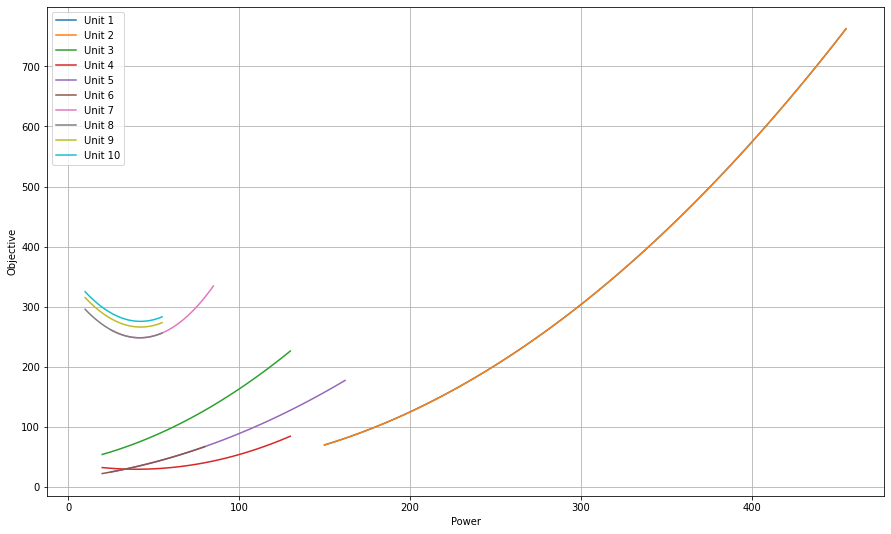

In [102]:
power_supply_df = pd.read_csv('Supply_Profiles_with_VPE_Data.csv')
power_supply_df
def plot_unit_profiles(objective: str, supply_df: pd.DataFrame = power_supply_df, n_points = 100):
    if objective.lower() == "cost":
        a = supply_df["ac"].to_numpy()
        b = supply_df["bc"].to_numpy()
        c = supply_df["cc"].to_numpy()
#         d = supply_df["dc"].to_numpy()
#         e = supply_df["cc"].to_numpy()
    elif objective.lower() == "emis":
        a = supply_df["ae"].to_numpy()
        b = supply_df["be"].to_numpy()
        c = supply_df["ce"].to_numpy()
#         d = supply_df["de"].to_numpy()
#         e = supply_df["ce"].to_numpy()
    elif objective.lower() == "co2":
        a = supply_df["aCO2"].to_numpy()
        b = supply_df["bCO2"].to_numpy()
        c = supply_df["cCO2"].to_numpy()
#         d = supply_df["dCO2"].to_numpy()
#         e = supply_df["cCO2"].to_numpy()
    elif objective.lower() == "so2":
        a = supply_df["aSO2"].to_numpy()
        b = supply_df["bSO2"].to_numpy()
        c = supply_df["cSO2"].to_numpy()
#         d = supply_df["dSO2"].to_numpy()
#         e = supply_df["cSO2"].to_numpy()

    p_min = supply_df["P_min"].to_numpy()
    p_max = supply_df["P_max"].to_numpy()
    pow_values = np.vstack([np.linspace(p_min[i], p_max[i], n_points) for i in range(len(supply_df))])
    obj_values = a[:, np.newaxis] * pow_values**2 + b[:, np.newaxis] * pow_values + c[:, np.newaxis]
    plt.figure(figsize=(15, 9))
    for i, value in enumerate(obj_values):
        plt.plot(pow_values[i], value, label=f'Unit {i+1}')

    plt.xlabel('Power')
    plt.ylabel('Objective')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_unit_profiles("emis")

In [103]:
power_supply_df

,Unit_ID,Unit_Type,P_max,P_min,ac,bc,cc,dc,ec,ae,be,ce,de,ee,Ramp_down,Ramp_up,Up_time,Down_time,Hot_Cost,Cold_Cost,Cold_Start_hrs,Shutdown_Cost,Status
0,Thermal_2,Thermal,455,150,0.00048,16.19,1000,450,0.041,0.00460,-0.5112,42.8955,0.25470,0.01234,80,80,8,8,5000,10000,5,0,8
1,Thermal_1,Thermal,455,150,0.00031,17.26,970,600,0.036,0.00460,-0.5112,42.8955,0.25470,0.01234,80,80,8,8,4500,9000,5,0,8
2,Thermal_3,Thermal,130,20,0.00200,16.60,700,320,0.028,0.00680,0.5455,40.2669,0.24990,0.01203,80,80,5,5,550,1100,4,0,-5
3,Thermal_4,Thermal,130,20,0.00211,16.50,680,260,0.052,0.00680,-0.5455,40.2669,0.24800,0.01290,50,50,5,5,560,1120,4,0,-5
4,Thermal_5,Thermal,162,25,0.00398,19.70,450,280,0.063,0.00420,0.3277,13.8593,0.24970,0.01200,50,50,6,6,900,1800,4,0,-6
5,Thermal_6,Thermal,80,20,0.00712,22.26,370,310,0.048,0.00420,0.3277,13.8593,0.24970,0.01200,50,50,3,3,170,340,2,0,-3
6,Thermal_7,Thermal,85,25,0.00079,27.74,480,300,0.086,0.04652,-3.9023,330.0056,0.25163,0.01215,30,30,3,3,260,520,2,0,-3
7,Thermal_8,Thermal,55,10,0.00413,25.92,660,340,0.082,0.04652,-3.9023,330.0056,0.25163,0.01215,30,30,1,1,30,60,0,0,-1
8,Thermal_9,Thermal,55,10,0.00222,27.27,665,270,0.098,0.04652,-3.9524,350.0056,0.25475,0.01234,30,30,1,1,30,60,0,0,-1
9,Thermal_10,Thermal,55,10,0.00173,27.79,670,380,0.094,0.04702,-3.9864,360.0012,0.25475,0.01234,30,30,1,1,30,60,0,0,-1


### **The UC Simulation Environment**

In [104]:
class ABRLEnv4UC():
  def __init__(self, supply_df: pd.DataFrame, demand_df: pd.DataFrame, 
               sr: float = 0.0, n_objs = "bi", 
               w = None,
               mode = "TRAIN", duplicates: int = None):
    if not isinstance(supply_df, pd.DataFrame): raise TypeError("Supply info must be a Pandas data frame.")
    if not isinstance(demand_df, pd.DataFrame): raise TypeError("Demand profile must be a Pandas data frame.")
        
    if not isinstance(float(sr), float): raise TypeError("Reserve percentage must be a number.")
    else: 
        if (sr < 0.0 or sr > 1.0): raise Exception("Reserve percentage must be between 0.0 and 1.0.")

    if str(n_objs).isalpha() == False:
        raise Exception('Obj. funs must be string specified as "bi" for bijective or "tri" for trijective.')
    else:
        if n_objs.lower() not in ["bi", "tri"]: 
            raise Exception('Obj. funs must be "bi" for bijective or "tri" for trijective.')
            
    if w is None: w = np.random.dirichlet(np.ones(3 if n_objs == "tri" else 2), size = 1)[0]
    elif not isinstance(np.array(w), np.ndarray): raise TypeError("Weight must be a a list or numpy array.")
    else:
        if abs(sum(w) - 1) > 0.001: raise Exception("Weights sum != 1.")
        
    if duplicates == None: duplicates = 1
    elif not isinstance(duplicates, int): raise TypeError("Duplicates must be an integer.")
    else:
        if (duplicates < 0.0): raise Exception("Duplicates must be a positive integer.")
        
    self.mode = mode
    self.duplicates = duplicates
    self.supply_df = supply_df.reindex(supply_df.index.repeat(self.duplicates)).reset_index(drop=True)
    self.demand_df = demand_df * self.duplicates
    self.sr = sr
    self.n_objs = n_objs.lower()
    self.w = w
    self.w_cost = self.w[0]
    
    self.n_units = self.supply_df.shape[0]
    self.n_timesteps = self.demand_df.shape[0]
    self.demands_vec = self.demand_df["Demand"].to_numpy()

    self.p_min_vec = self.supply_df["P_min"].to_numpy()
    self.p_max_vec = self.supply_df["P_max"].to_numpy()
    self.ramp_dn_vec = self.supply_df["Ramp_down"].to_numpy() if "Ramp_down" in self.supply_df.columns else None  
    self.ramp_up_vec = self.supply_df["Ramp_up"].to_numpy() if "Ramp_up" in self.supply_df.columns else None  
    self.dn_times_vec = self.supply_df["Down_time"].to_numpy()
    self.up_times_vec = self.supply_df["Up_time"].to_numpy()
    self.statuses_vec = self.supply_df["Status"].to_numpy()
    self.hot_costs_vec = self.supply_df["Hot_Cost"].to_numpy()
    self.cold_costs_vec = self.supply_df["Cold_Cost"].to_numpy()
    self.cold_times_vec = self.supply_df["Cold_Start_hrs"].to_numpy()
    self.shut_costs_vec = (self.supply_df["shut_Cost"].to_numpy() 
                               if "shut_Cost" in self.supply_df.columns else np.zeros(self.n_units))
    self.ac_vec = self.supply_df["ac"].to_numpy() if "ac" in self.supply_df.columns else None
    self.bc_vec = self.supply_df["bc"].to_numpy() if "bc" in self.supply_df.columns else None
    self.cc_vec = self.supply_df["cc"].to_numpy() if "cc" in self.supply_df.columns else None
    self.dc_vec = self.supply_df["dc"].to_numpy() if "dc" in self.supply_df.columns else np.zeros(self.n_units)
    self.ec_vec = self.supply_df["ec"].to_numpy() if "ec" in self.supply_df.columns else np.zeros(self.n_units)
    if self.n_objs == "bi":
        self.ae_vec = self.supply_df["ae"].to_numpy() if "ae" in self.supply_df.columns else None
        self.be_vec = self.supply_df["be"].to_numpy() if "be" in self.supply_df.columns else None
        self.ce_vec = self.supply_df["ce"].to_numpy() if "ce" in self.supply_df.columns else None
        self.de_vec = self.supply_df["de"].to_numpy() if "de" in self.supply_df.columns else np.zeros(self.n_units)
        self.ee_vec = self.supply_df["ee"].to_numpy() if "ee" in self.supply_df.columns else np.zeros(self.n_units)
        self.start_emiss_vec = (self.supply_df["Start_Emission"].to_numpy() 
                                 if "Start_Emission" in self.supply_df.columns else np.zeros(self.n_units))
        self.shut_emiss_vec = (self.supply_df["Shut_Emission"].to_numpy() 
                                 if "Shut_Emission" in self.supply_df.columns else np.zeros(self.n_units))
        self.w_emis = self.w[1]
 
    elif self.n_objs == "tri":
        self.aCO2_vec = self.supply_df["aCO2"].to_numpy() if "aCO2" in self.supply_df.columns else None
        self.bCO2_vec = self.supply_df["bCO2"].to_numpy() if "bCO2" in self.supply_df.columns else None
        self.cCO2_vec = self.supply_df["cCO2"].to_numpy() if "cCO2" in self.supply_df.columns else None
        self.dCO2_vec = self.supply_df["dCO2"].to_numpy() if "dCO2" in self.supply_df.columns else np.zeros(self.n_units)
        self.eCO2_vec = self.supply_df["eCO2"].to_numpy() if "eCO2" in self.supply_df.columns else np.zeros(self.n_units)
        self.start_CO2s_vec = (self.supply_df["Start_CO2"].to_numpy()
                              if "Start_CO2" in self.supply_df.columns else np.zeros(self.n_units))
        self.shut_CO2s_vec = (self.supply_df["Shut_CO2"].to_numpy() 
                             if "Shut_CO2" in self.supply_df.columns else np.zeros(self.n_units))

        self.aSO2_vec = self.supply_df["aSO2"].to_numpy() if "aSO2" in self.supply_df.columns else None
        self.bSO2_vec = self.supply_df["bSO2"].to_numpy() if "bSO2" in self.supply_df.columns else None
        self.cSO2_vec = self.supply_df["cSO2"].to_numpy() if "cSO2" in self.supply_df.columns else None
        self.dSO2_vec = self.supply_df["dSO2"].to_numpy() if "dSO2" in self.supply_df.columns else np.zeros(self.n_units)
        self.eSO2_vec = self.supply_df["eSO2"].to_numpy() if "eSO2" in self.supply_df.columns else np.zeros(self.n_units)
        self.start_SO2s_vec = (self.supply_df["Start_SO2"].to_numpy()
                               if "Start_SO2" in self.supply_df.columns else np.zeros(self.n_units))
        self.shut_SO2s_vec = (self.supply_df["Shut_SO2"].to_numpy()
                              if "Shut_SO2" in self.supply_df.columns else np.zeros(self.n_units))
        self.w_CO2 = self.w[1]
        self.w_SO2 = self.w[2]
        
    self.check_parameters_and_input_data()
    self.timestep = 0
    self.commits_vec = np.where(self.statuses_vec > 0, 1, 0)
    self.startup_costs_and_emissions_if_ON()
    self.shutdown_costs_and_emissions_if_OFF()
    self.summarize_marginal_functions()
    self.cost_penalty_factors()
    self.penalties_for_incomplete_episodes()
    self.determine_priority_orders()
    self.identify_must_ON_and_must_OFF_units()

    self.incomplete_episode = False
    self.done = False
    self.probs_vec = np.array([(self.demands_vec[i] * (1 + self.sr)) / sum(self.p_max_vec) 
                               for i in range(self.n_timesteps)])
    

  def check_parameters_and_input_data(self):
    if self.n_objs == "bi":
        if self.w_cost == 1:
            is_any_cost_params_null = np.any([self.ac_vec == None, self.bc_vec == None, self.cc_vec == None])
            if is_any_cost_params_null: raise Exception("Cost parameters are None.")
        elif self.w_emis == 1:
            is_any_emis_params_null = np.any([self.ae_vec == None, self.be_vec == None, self.ce_vec == None])
            if is_any_emis_params_null: raise Exception("Emission parameters are None.")
        else:
            is_any_cost_params_null = np.any([self.ac_vec == None, self.bc_vec == None, self.cc_vec == None])
            if is_any_cost_params_null: raise Exception("Cost parameters are None.")
            is_any_emis_params_null = np.any([self.ae_vec == None, self.be_vec == None, self.ce_vec == None])
            if is_any_emis_params_null: raise Exception("Emission parameters are None.")
    elif self.n_objs == "tri":
        if self.w_cost == 1:
            is_any_cost_params_null = np.any([self.ac_vec == None, self.bc_vec == None, self.cc_vec == None])
            if is_any_cost_params_null: raise Exception("Cost parameters are None.")
        elif self.w_CO2 == 1: 
            is_any_CO2_params_null = np.any([self.aCO2_vec == None, self.bCO2_vec == None, self.cCO2_vec == None])
            if is_any_CO2_params_null: raise Exception("CO2 emission parameters are None.")
        elif self.w_SO2 == 1: 
            is_any_SO2_params_null = np.any([self.aSO2_vec == None, self.bSO2_vec == None, self.cSO2_vec == None])
            if is_any_SO2_params_null: raise Exception("SO2 emission parameters are None.")
        else:
            is_any_cost_params_null = np.any([self.ac_vec == None, self.bc_vec == None, self.cc_vec == None])
            if is_any_cost_params_null: raise Exception("Cost parameters are None.")
            is_any_CO2_params_null = np.any([self.aCO2_vec == None, self.bCO2_vec == None, self.cCO2_vec == None])
            if is_any_CO2_params_null: raise Exception("CO2 emission parameters are None.")
            is_any_SO2_params_null = np.any([self.aSO2_vec == None, self.bSO2_vec == None, self.cSO2_vec == None])
            if is_any_SO2_params_null: raise Exception("SO2 emission parameters are None.")                  

                
  def startup_costs_and_emissions_if_ON(self):  
    OFF_times_vec = np.abs(np.minimum(self.statuses_vec, 0))
    cold_OFF_times_vec = self.dn_times_vec + self.cold_times_vec
    is_hot_cost = np.logical_and(self.dn_times_vec <= OFF_times_vec, OFF_times_vec <= cold_OFF_times_vec)
    is_cold_cost = OFF_times_vec > cold_OFF_times_vec
    self.start_costs_vec = np.where(is_hot_cost, self.hot_costs_vec, np.where(is_cold_cost, self.cold_costs_vec, 0))
    if self.n_objs == "bi":
        self.start_emiss_vec *= np.where(OFF_times_vec > 0, 1, 0)
    elif self.n_objs == "tri":
        self.start_CO2s_vec *= np.where(OFF_times_vec > 0, 1, 0)
        self.start_SO2s_vec *= np.where(OFF_times_vec > 0, 1, 0)        

        
  def shutdown_costs_and_emissions_if_OFF(self):  
    ON_times_vec = np.maximum(self.statuses_vec, 0)
    self.shut_costs_vec *= np.where(ON_times_vec > 0, 1, 0)
    if self.n_objs == "bi":
        self.shut_emiss_vec *= np.where(ON_times_vec > 0, 1, 0)
    elif self.n_objs == "tri":
        self.shut_CO2s_vec *= np.where(ON_times_vec > 0, 1, 0)
        self.shut_SO2s_vec *= np.where(ON_times_vec > 0, 1, 0)

  def prod_cost_funs(self, loads_vec: np.ndarray):
    return np.where(loads_vec > 0, 1, 0) * (self.ac_vec * loads_vec**2 + self.bc_vec * loads_vec + self.cc_vec +
                                            np.abs(self.dc_vec * np.sin(self.ec_vec * (self.p_min_vec - loads_vec))))

  def prod_emis_funs(self, loads_vec: np.ndarray, cost_to_emis_factors_vec: np.ndarray = 1):
        return np.where(loads_vec > 0, 1, 0) * cost_to_emis_factors_vec * (
            self.ae_vec * loads_vec**2 + self.be_vec * loads_vec + self.ce_vec + 
            self.de_vec * np.exp(self.ee_vec * loads_vec)) if self.n_objs == "bi" else None
    
  def prod_CO2_funs(self, loads_vec: np.ndarray, cost_to_CO2_factors_vec: np.ndarray = 1):
    return np.where(loads_vec > 0, 1, 0) * cost_to_CO2_factors_vec * (
        self.aCO2_vec * loads_vec**2 + self.bCO2_vec * loads_vec + self.cCO2_vec + 
        self.dCO2_vec * np.exp(self.eCO2_vec * loads_vec)) if self.n_objs == "tri" else None

  def prod_SO2_funs(self, loads_vec: np.ndarray, cost_to_SO2_factors_vec: np.ndarray = 1):
        return np.where(loads_vec > 0, 1, 0) * cost_to_SO2_factors_vec * (
            self.aSO2_vec * loads_vec**2 + self.bSO2_vec * loads_vec + self.cSO2_vec + 
            self.dSO2_vec * np.exp(self.eSO2_vec * loads_vec)) if self.n_objs == "tri" else None
    

  def summarize_marginal_functions(self):
    # The cost, CO2 and SO2 functions are all upward functions for all units.
    # But, there are some units whose "emission" functions are u shaped.
    # Hence, the min obj value is not necssarily at the min capacity, and 
    # the same is true for max obj values.
    # Thus, the necessity of the min and max value points are below are for this purpose. 
    # I will think of adjusting for non-convex/non smooth functions also.
    self.max_cap_prod_cost = np.sum(self.prod_cost_funs(self.p_max_vec)) # I do not include the time dependent SU costs
    min_prod_cost_points_vec = np.where(self.p_min_vec > (p_min_vec := -self.bc_vec / (2 * self.ac_vec)),
                                       self.p_min_vec, p_min_vec)
    max_prod_cost_points_vec = np.where(self.prod_cost_funs(self.p_min_vec) > self.prod_cost_funs(self.p_max_vec), 
                                   self.p_min_vec, self.p_max_vec)
    
    self.min_prod_costs_vec = self.prod_cost_funs(min_prod_cost_points_vec)
    self.max_prod_costs_vec = self.prod_cost_funs(max_prod_cost_points_vec)
    
    self.min_prod_costs_MW_vec = self.max_prod_costs_vec / self.p_max_vec
    self.max_prod_costs_MW_vec = self.min_prod_costs_vec / self.p_min_vec
    
    self.min_prod_cost = np.min(self.min_prod_costs_MW_vec * self.p_min_vec)
    self.max_prod_cost = np.sum(self.max_prod_costs_MW_vec * self.p_max_vec)
    
    
    if self.n_objs == "bi":
        self.max_cap_prod_emis = np.sum(self.prod_emis_funs(self.p_max_vec))
        min_prod_emis_points_vec = np.where(self.p_min_vec > (p_min_vec := -self.be_vec / (2 * self.ae_vec)),
                                       self.p_min_vec, p_min_vec)
        max_prod_emis_points_vec = np.where(self.prod_emis_funs(self.p_min_vec) > self.prod_emis_funs(self.p_max_vec), 
                                       self.p_min_vec, self.p_max_vec)
        
        self.min_prod_emiss_vec = self.prod_emis_funs(min_prod_emis_points_vec)
        self.max_prod_emiss_vec = self.prod_emis_funs(max_prod_emis_points_vec)
        # Here, I found that f(Pmax)/Pmax <= f(Pmin)/Pmin is not true for all units
        # It results a negative reward; so I made some adjustments
        min_prod_emiss_MW_vec = self.max_prod_emiss_vec / max_prod_emis_points_vec
        max_prod_emiss_MW_vec = self.min_prod_emiss_vec / min_prod_emis_points_vec
        
        self.min_prod_emiss_MW_vec = np.where(min_prod_emiss_MW_vec < max_prod_emiss_MW_vec, 
                                              min_prod_emiss_MW_vec, max_prod_emiss_MW_vec)
        self.max_prod_emiss_MW_vec = np.where(min_prod_emiss_MW_vec > max_prod_emiss_MW_vec, 
                                              min_prod_emiss_MW_vec, max_prod_emiss_MW_vec)
    
        self.min_prod_emis = np.min(self.min_prod_emiss_MW_vec * self.p_min_vec) 
        self.max_prod_emis = np.sum(self.max_prod_emiss_MW_vec * self.p_max_vec) 
        

    elif self.n_objs == "tri":
        self.max_cap_prod_CO2 = np.sum(self.prod_CO2_funs(self.p_max_vec))
        min_prod_CO2_points_vec = np.where(self.p_min_vec > (p_min_vec := -self.bCO2_vec / (2 * self.aCO2_vec)),
                                      self.p_min_vec, p_min_vec) # same as "self.p_min_vec", no difference
        max_prod_CO2_points_vec = np.where(self.prod_CO2_funs(self.p_min_vec) > self.prod_CO2_funs(self.p_max_vec),
                                      self.p_min_vec, self.p_max_vec) # same as "self.p_max_vec", no difference

        self.min_prod_CO2s_vec = self.prod_CO2_funs(min_prod_CO2_points_vec)
        self.max_prod_CO2s_vec = self.prod_CO2_funs(max_prod_CO2_points_vec)
        # So I made some adjustments as above
        min_prod_CO2s_MW_vec = self.max_prod_CO2s_vec / min_prod_CO2_points_vec
        max_prod_CO2s_MW_vec = self.min_prod_CO2s_vec / max_prod_CO2_points_vec 
        
        self.min_prod_CO2s_MW_vec = np.where(min_prod_CO2s_MW_vec < max_prod_CO2s_MW_vec, 
                                             min_prod_CO2s_MW_vec, max_prod_CO2s_MW_vec)
        self.max_prod_CO2s_MW_vec = np.where(min_prod_CO2s_MW_vec > max_prod_CO2s_MW_vec, 
                                             min_prod_CO2s_MW_vec, max_prod_CO2s_MW_vec)
        
        self.min_prod_CO2 = np.min(self.min_prod_CO2s_MW_vec * self.p_min_vec) 
        self.max_prod_CO2 = np.sum(self.max_prod_CO2s_MW_vec * self.p_max_vec)
        
        self.max_cap_prod_SO2 = np.sum(self.prod_SO2_funs(self.p_max_vec))
        min_prod_SO2_points_vec = np.where(self.p_min_vec > (p_min_vec := -self.bSO2_vec / (2 * self.aSO2_vec)),
                                      self.p_min_vec, p_min_vec)
        max_prod_SO2_points_vec = np.where(self.prod_SO2_funs(self.p_min_vec) > self.prod_SO2_funs(self.p_max_vec),
                                      self.p_min_vec, self.p_max_vec)
        self.min_prod_SO2s_vec = self.prod_SO2_funs(min_prod_SO2_points_vec)
        self.max_prod_SO2s_vec = self.prod_SO2_funs(max_prod_SO2_points_vec)
        # It is true that f(Pmax)/Pmax <= f(Pmin)/Pmin for all units
        # I just added it for consistency
        min_prod_SO2s_MW_vec = self.max_prod_SO2s_vec / self.p_max_vec
        max_prod_SO2s_MW_vec = self.min_prod_SO2s_vec / self.p_min_vec

        self.min_prod_SO2s_MW_vec = np.where(min_prod_SO2s_MW_vec < max_prod_SO2s_MW_vec, 
                                             min_prod_SO2s_MW_vec, max_prod_SO2s_MW_vec)
        self.max_prod_SO2s_MW_vec = np.where(min_prod_SO2s_MW_vec > max_prod_SO2s_MW_vec, 
                                             min_prod_SO2s_MW_vec, max_prod_SO2s_MW_vec)
        
        self.min_prod_SO2 = np.min(self.min_prod_SO2s_MW_vec * self.p_min_vec) 
        self.max_prod_SO2 = np.sum(self.max_prod_SO2s_MW_vec * self.p_max_vec)
        
    
  def cost_penalty_factors(self):
    max_cap_prod_costs_vec = self.prod_cost_funs(self.p_max_vec)
    min_cap_prod_costs_vec = self.prod_cost_funs(self.p_min_vec)
    
    if self.n_objs == "bi":
        self.eta_min_min_vec = self.min_prod_costs_vec / self.min_prod_emiss_vec
        self.eta_min_max_vec = self.min_prod_costs_vec / self.max_prod_emiss_vec
        self.eta_max_min_vec = self.max_prod_costs_vec / self.min_prod_emiss_vec
        self.eta_max_max_vec = self.max_prod_costs_vec / self.max_prod_emiss_vec
        self.eta_mean_vec = (self.eta_min_min_vec + self.eta_min_max_vec + 
                             self.eta_max_min_vec + self.eta_max_max_vec) / 4 
        
        max_cap_prod_emiss_vec = self.prod_emis_funs(self.p_max_vec)
        min_cap_prod_emiss_vec = self.prod_emis_funs(self.p_min_vec)
        emis_slopes_vec = (max_cap_prod_costs_vec - min_cap_prod_costs_vec) / (max_cap_prod_emiss_vec - min_cap_prod_emiss_vec)
        standardized_slopes_vec = emis_slopes_vec / (max(emis_slopes_vec) - min(emis_slopes_vec))
        self.cost_to_emis_factors_vec = np.exp(standardized_slopes_vec) 
    elif self.n_objs == "tri":
        self.eta1_min_min_vec = self.min_prod_costs_vec / self.min_prod_CO2s_vec
        self.eta1_min_max_vec = self.min_prod_costs_vec / self.max_prod_CO2s_vec
        self.eta1_max_min_vec = self.max_prod_costs_vec / self.min_prod_CO2s_vec
        self.eta1_max_max_vec = self.max_prod_costs_vec / self.max_prod_CO2s_vec
        self.eta1_mean_vec = (self.eta1_min_min_vec + self.eta1_min_max_vec + 
                              self.eta1_max_min_vec + self.eta1_max_max_vec) / 4 
        self.eta1_common = np.sum(self.eta1_mean_vec) / self.n_units
        
        
        max_cap_prod_CO2s_vec = self.prod_CO2_funs(self.p_max_vec)
        min_cap_prod_CO2s_vec = self.prod_CO2_funs(self.p_min_vec)
        CO2_slopes_vec = (max_cap_prod_costs_vec - min_cap_prod_costs_vec)/ (max_cap_prod_CO2s_vec - min_cap_prod_CO2s_vec)
        standardized_CO2_slopes_vec = CO2_slopes_vec / (max(CO2_slopes_vec) - min(CO2_slopes_vec))
        self.cost_to_CO2_factors_vec = np.exp(standardized_CO2_slopes_vec)
        
        self.eta2_min_min_vec = self.min_prod_costs_vec / self.min_prod_SO2s_vec
        self.eta2_min_max_vec = self.min_prod_costs_vec / self.max_prod_SO2s_vec
        self.eta2_max_min_vec = self.max_prod_costs_vec / self.min_prod_SO2s_vec
        self.eta2_max_max_vec = self.max_prod_costs_vec / self.max_prod_SO2s_vec
        self.eta2_mean_vec = (self.eta1_min_min_vec + self.eta1_min_max_vec + 
                              self.eta1_max_min_vec + self.eta1_max_max_vec) / 4 
        self.eta2_common = np.sum(self.eta1_mean_vec) / self.n_units
        
        max_cap_prod_SO2s_vec = self.prod_SO2_funs(self.p_max_vec)
        min_cap_prod_SO2s_vec = self.prod_SO2_funs(self.p_min_vec)
        SO2_slopes_vec = (max_cap_prod_costs_vec - min_cap_prod_costs_vec)/ (max_cap_prod_SO2s_vec - min_cap_prod_SO2s_vec)
        standardized_SO2_slopes_vec = SO2_slopes_vec / (max(SO2_slopes_vec) - min(SO2_slopes_vec))
        self.cost_to_SO2_factors_vec = np.exp(standardized_SO2_slopes_vec)  

  def penalties_for_incomplete_episodes(self):
    # startup values are not included
    self.cost_penalties_vec = np.linspace(self.max_prod_cost, self.max_cap_prod_cost, num = self.n_timesteps)
    if self.n_objs == "bi":  
        self.emis_penalties_vec = np.linspace(self.max_prod_emis, self.max_cap_prod_emis, num = self.n_timesteps)
    elif self.n_objs == "tri":
        self.CO2_penalties_vec = np.linspace(self.max_prod_CO2, self.max_cap_prod_CO2, num = self.n_timesteps)
        self.SO2_penalties_vec = np.linspace(self.max_prod_SO2, self.max_cap_prod_SO2, num = self.n_timesteps)
    
  def determine_priority_orders(self): 
    up_times_vec = np.maximum(self.up_times_vec, 0.001) # setting the minimum up time durations to 0.001
    dn_times_vec = np.maximum(self.dn_times_vec, 0.001) # setting the minimum off time durations to 0.001
    ON_costs_vec = (self.min_prod_costs_MW_vec + (self.start_costs_vec / self.p_max_vec)) / up_times_vec
    if self.n_objs == "bi":
        ON_emiss_vec = (self.min_prod_emiss_MW_vec + (self.start_emiss_vec / self.p_max_vec)) / up_times_vec
        if self.w_cost == 1: self.ON_priorities_vec = ON_costs_vec
        elif self.w_emis == 1: self.ON_priorities_vec = ON_emiss_vec
        else: self.ON_priorities_vec = (ON_costs_vec + ON_emiss_vec) / 2
        self.ON_priority_idx_vec = self.ON_priorities_vec.argsort() 
    elif self.n_objs =="tri":
        ON_CO2_vec = (self.min_prod_CO2s_MW_vec + (self.start_CO2s_vec / self.p_max_vec)) / up_times_vec
        ON_SO2_vec = (self.min_prod_SO2s_MW_vec + (self.start_SO2s_vec / self.p_max_vec)) / up_times_vec
        if self.w_cost == 1: self.ON_priorities_vec = ON_costs_vec
        elif self.w_CO2 == 1: self.ON_priorities_vec = ON_CO2_vec
        elif self.w_SO2 == 1: self.ON_priorities_vec = ON_SO2_vec
        else: self.ON_priorities_vec = (ON_costs_vec + ON_CO2_vec + ON_SO2_vec) / 3
        self.ON_priority_idx_vec = self.ON_priorities_vec.argsort()
        
  def identify_must_ON_and_must_OFF_units(self): 
    initial_durations_vec = self.supply_df["Status"].to_numpy()
    initial_OFF_times_vec = np.where(initial_durations_vec < 0, np.abs(initial_durations_vec), 0)
    self.must_OFF_vec = np.logical_and(-self.dn_times_vec < self.statuses_vec, self.statuses_vec < 0)
    initial_ON_times_vec = np.where(initial_durations_vec > 0, initial_durations_vec, 0)
    self.must_ON_vec = np.logical_and(0 < self.statuses_vec, self.statuses_vec < self.up_times_vec)
    if np.any(self.commits_vec): # future demand satisfaction
        prev_ON_idx_vec = np.where(self.commits_vec == 1)[0]
        priority_idx_vec = np.array([i for i in self.ON_priority_idx_vec if i in prev_ON_idx_vec])
        demands_sr_vec = (1 + self.sr) * self.demands_vec
        for idx in priority_idx_vec:
            max_timestep = min(self.timestep + self.dn_times_vec[idx], self.n_timesteps)
            for timestep in range(self.timestep, max_timestep):
                act_vec = np.ones(self.n_units)
                act_vec[idx] = 0
                if np.sum(act_vec * self.p_max_vec) < demands_sr_vec[timestep]:
                    self.must_ON_vec[idx] = True
                    break
#     if self.w == 0.0:
#         if len(cc := np.where(self.must_ON_vec == True)[0]) > 0 :
#             for idx in self.ON_priority_idx_vec[: max(cc) + 1]:
#                 self.must_ON_vec[idx] = True

  def step(self, action_vec: np.ndarray):
    if not isinstance(action_vec, np.ndarray):
        raise TypeError("Action vector must be a NumPy array.")
        print(action_vec)
    state_dict = self.get_current_state()
    self.demand = state_dict["demand"]
    demand_sr = round((1 + self.sr) * self.demand, 1)
    self.action_vec = self.ensure_action_legitimacy(demand_sr, action_vec)
    self.get_operation_costs_and_emissions(self.demand, self.action_vec)
    reward = self.evaluate_action_reward(demand_sr, self.action_vec)     
    dispatch_info = self.dispatch_info() 
    is_done = self.is_terminal()
    if self.timestep < self.n_timesteps - 1: 
        next_state_dict = self.get_next_state(self.action_vec)
    else: next_state_dict = self.reset()
        
    return next_state_dict, reward, is_done, dispatch_info                                 

  def get_current_state(self):
    self.startup_costs_and_emissions_if_ON()
    self.shutdown_costs_and_emissions_if_OFF()
    self.determine_priority_orders()
    self.identify_must_ON_and_must_OFF_units()
    
    state_dict = {
        "timestep": self.timestep,
        "demand": self.demands_vec[self.timestep],
        "min_capacities": self.p_min_vec,
        "max_capacities": self.p_max_vec, 
        "operating_statuses": self.statuses_vec,
        "commitments": self.commits_vec,
        
        "start_costs_if_ON": self.start_costs_vec,
        "shut_costs_if_OFF": self.shut_costs_vec,
        
        "start_emiss_if_ON": self.start_emiss_vec if self.n_objs == "bi" else None,
        "shut_emiss_if_OFF": self.shut_emiss_vec if self.n_objs == "bi" else None,
        
        "start_CO2s_if_ON": self.start_CO2s_vec if self.n_objs == "tri" else None,
        "shut_CO2s_if_OFF": self.shut_CO2s_vec if self.n_objs == "tri" else None,
        
        "start_SO2s_if_ON": self.start_SO2s_vec if self.n_objs == "tri" else None,
        "shut_SO2s_if_OFF": self.shut_SO2s_vec if self.n_objs == "tri" else None, 
        }
    return state_dict

  def ensure_action_legitimacy(self, demand: float, action_vec: np.ndarray):  
    if self._is_action_illegal(action_vec): 
        action_vec = self._legalize_action(action_vec) 
    if np.sum(action_vec * self.p_max_vec) < demand: 
        action_vec = self._adjust_low_capacity(demand, action_vec)
    elif np.sum(action_vec * self.p_min_vec) > demand: 
        action_vec = self._adjust_excess_capacity(demand, action_vec)
    return action_vec

  def _is_action_illegal(self, action_vec: np.ndarray):
    any_illegal_ON = np.any(action_vec[self.must_ON_vec] == 0)              
    any_illegal_OFF = np.any(action_vec[self.must_OFF_vec] == 1)             
    return any([any_illegal_ON, any_illegal_OFF])

  def _legalize_action(self, action_vec: np.ndarray): 
    illegal_action_vec = action_vec.copy()                                   
    action_vec = np.array(np.logical_or(illegal_action_vec, self.must_ON_vec)
                          * np.logical_not(self.must_OFF_vec), dtype = int) 
    return action_vec

  def _adjust_low_capacity(self, demand: float, action_vec: np.ndarray):
    low_action_vec = action_vec.copy()
    already_OFF_idx_vec = np.where(action_vec == 0)[0]
    must_not_OFF_idx_vec = np.where(self.must_OFF_vec == False)[0]
    can_ON_idx_vec = np.intersect1d(already_OFF_idx_vec, must_not_OFF_idx_vec)
    if len(can_ON_idx_vec) > 0:
        priority_idx_vec = np.array([i for i in self.ON_priority_idx_vec if i in can_ON_idx_vec])
        remaining_supply = demand - np.sum(action_vec * self.p_max_vec)
        for idx in priority_idx_vec:
            action_vec[idx] = 1
            remaining_supply = remaining_supply - self.p_max_vec[idx]
            if remaining_supply <= 0.0001: break           
    return action_vec

  def _adjust_excess_capacity(self, demand: float, action_vec: np.ndarray):
    excess_action_vec = action_vec.copy()
    print("excess capacity", excess_action_vec)
    already_ON_idx_vec = np.where(action_vec == 1)[0]
    must_not_ON_idx_vec = np.where(self.must_ON_vec == False)[0]
    can_OFF_idx_vec = np.intersect1d(already_ON_idx_vec, must_not_ON_idx_vec)
    if len(can_OFF_idx_vec) > 0:
        OFF_priority_idx_vec = np.array([i for i in self.ON_priority_idx_vec[::-1] if i in can_OFF_idx_vec])
        excess_supply = np.sum(action_vec * self.p_min_vec) - demand
        for idx in OFF_priority_idx_vec:
            action_vec[idx] = 0
            excess_supply -= self.p_min_vec[idx]
            if excess_supply <= 0.0001:
                if np.sum(action_vec * self.p_max_vec) < demand:
                    action_vec[idx] = 1
                    break
                break            
    return action_vec

  def get_operation_costs_and_emissions(self, demand: float, action_vec: np.ndarray):
    self._get_startup_results(action_vec)
    self._get_shutdown_results(action_vec)
    self._get_production_results(demand, action_vec)

    self.total_cost = self.start_cost + self.shut_cost + self.prod_cost
    if self.n_objs == "bi":
        self.total_emis = self.start_emis + self.shut_emis + self.prod_emis
    elif self.n_objs == "tri":
        self.total_CO2 = self.start_CO2 + self.shut_CO2 + self.prod_CO2 
        self.total_SO2 = self.start_SO2 + self.shut_SO2 + self.prod_SO2

  def _get_startup_results(self, action_vec: np.ndarray):
    self.start_cost = np.sum(action_vec * (1 - self.commits_vec) * self.start_costs_vec)
    if self.n_objs == "bi":
        self.start_emis = np.sum(action_vec * (1 - self.commits_vec) * self.start_emiss_vec)

    elif self.n_objs == "tri":
        self.start_CO2 = np.sum(action_vec * (1 - self.commits_vec) * self.start_CO2s_vec)
        self.start_SO2 = np.sum(action_vec * (1 - self.commits_vec) * self.start_SO2s_vec)
        
  def _get_shutdown_results(self, action_vec: np.ndarray):
    self.shut_cost = np.sum((1 - action_vec) * self.commits_vec * self.shut_costs_vec)
    if self.n_objs == "bi":
        self.shut_emis = np.sum((1 - action_vec) * self.commits_vec * self.shut_emiss_vec)
        self.shut_emis_penalty = np.sum((1 - action_vec) * self.commits_vec * 
                                        self.cost_to_emis_factors_vec * self.shut_emiss_vec)
    elif self.n_objs == "tri":
        self.shut_CO2 = np.sum((1 - action_vec) * self.commits_vec * self.shut_CO2s_vec)
        self.shut_SO2 = np.sum((1 - action_vec) * self.commits_vec * self.shut_SO2s_vec)

        
  def _get_production_results(self, demand: float, action_vec: np.ndarray):
    if np.sum(action_vec * self.p_max_vec) < demand:
        self.incomplete_episode = True 
        loads_vec = action_vec * self.p_max_vec
        prod_cost = self.cost_penalties_vec[self.timestep] 
        if self.n_objs == "bi":
            prod_emis = self.emis_penalties_vec[self.timestep]
        elif self.n_objs == "tri":
            prod_CO2 = self.CO2_penalties_vec[self.timestep]
            prod_SO2 = self.SO2_penalties_vec[self.timestep]
    elif np.sum(action_vec * self.p_min_vec) > demand:
        self.incomplete_episode = True 
        loads_vec = action_vec * self.p_min_vec
        prod_cost = self.cost_penalties_vec[self.timestep] 
        if self.n_objs == "bi":
            prod_emis = self.emis_penalties_vec[self.timestep]
        elif self.n_objs == "tri":
            prod_CO2 = self.CO2_penalties_vec[self.timestep]
            prod_SO2 = self.SO2_penalties_vec[self.timestep]
    else:
        EC_EM_D = self.optimize_production(action_vec, demand)     
        loads_vec = EC_EM_D["loads_vec"]
        prod_cost = np.sum(self.prod_cost_funs(loads_vec))
        if self.n_objs == "bi":
            prod_emis = np.sum(self.prod_emis_funs(loads_vec))
        elif self.n_objs == "tri":
            prod_CO2 = np.sum(self.prod_CO2_funs(loads_vec))
            prod_SO2 = np.sum(self.prod_SO2_funs(loads_vec))

    self.loads_vec = loads_vec
    self.prod_cost = prod_cost
    if self.n_objs == "bi":
        self.prod_emis = prod_emis
    elif self.n_objs == "tri":
        self.prod_CO2 = prod_CO2
        self.prod_SO2 = prod_SO2

  def optimize_production(self, action_vec: np.ndarray, demand: float):
        idx = np.where(action_vec == 1)[0] 
        n_ON_units = len(idx)
        p_min_vec = self.p_min_vec[idx].reshape(-1, 1)
        p_max_vec = self.p_max_vec[idx].reshape(-1, 1)        
        
        def objective_function(p_vec):
            cost_obj_values_vec = (self.ac_vec[idx] * p_vec**2 + self.bc_vec[idx] * p_vec + 
                                   self.cc_vec[idx] + np.abs(self.dc_vec[idx] * 
                                                             np.sin(self.ec_vec[idx] * (p_min_vec - p_vec))))
            emis_obj_values_vec = (self.ae_vec[idx] * p_vec**2 + self.be_vec[idx] * p_vec + 
                                   self.ce_vec[idx] + self.de_vec[idx] * 
                                   np.exp(self.ee_vec[idx] * p_vec)) if self.n_objs == "bi" else None
            CO2_obj_values_vec = (self.aCO2_vec[idx] * p_vec**2 + self.bCO2_vec[idx] * p_vec + 
                                  self.cCO2_vec[idx] + self.dCO2_vec[idx] * 
                                  np.exp(self.eCO2_vec[idx] * p_vec)) if self.n_objs == "tri" else None
            SO2_obj_values_vec = (self.aSO2_vec[idx] * p_vec**2 + self.bSO2_vec[idx] * p_vec + 
                                  self.cSO2_vec[idx] + self.dSO2_vec[idx] * 
                                  np.exp(self.eSO2_vec[idx] * p_vec)) if self.n_objs == "tri" else None
            
            if self.n_objs == "bi":
                combined_obj_value = np.sum(self.w_cost * cost_obj_values_vec 
                                            + (self.w_emis * self.cost_to_emis_factors_vec[idx] * emis_obj_values_vec
                                               if self.w_emis != 1 else emis_obj_values_vec)
                                           )
            elif self.n_objs == "tri":
                combined_obj_value = np.sum(self.w_cost * cost_obj_values_vec 
                                            + (self.w_CO2 * self.cost_to_CO2_factors_vec[idx] * CO2_obj_values_vec 
                                               if self.w_CO2 != 1 else CO2_obj_values_vec)
                                            + (self.w_SO2 * self.cost_to_SO2_factors_vec[idx] * SO2_obj_values_vec
                                               if self.w_SO2 != 1 else SO2_obj_values_vec)
                                           )

#             if self.n_objs == "bi":
#                 combined_obj_value = np.sum(self.w_cost * cost_obj_values_vec 
#                                             + (self.w_emis * self.cost_to_emis_factors_vec[idx] * emis_obj_values_vec
#                                                if self.w_emis != 1 else emis_obj_values_vec)
#                                            )
#             elif self.n_objs == "tri":
#                 combined_obj_value = np.sum(self.w_cost *(cost_obj_values_vec - self.min_prod_cost) / (self.max_prod_cost - self.min_prod_cost)
#                                             + (self.w_CO2 *  (CO2_obj_values_vec - self.min_prod_CO2) / (self.max_prod_CO2 - self.min_prod_CO2)
#                                                if self.w_CO2 != 1 else CO2_obj_values_vec)
#                                             + (self.w_SO2 * (SO2_obj_values_vec - self.min_prod_SO2) / (self.max_prod_SO2 - self.min_prod_SO2)
#                                                if self.w_SO2 != 1 else SO2_obj_values_vec)
#                                            )
            if self.n_objs == "bi":
                if 0 <= self.w_cost < 1 and emis_obj_values_vec is None:
                    raise Exception(f"Cost weight = {self.w_cost} but emission obj. values vector is None.")
            elif self.n_objs == "tri":
                if 0 <= self.w_CO2 < 1:
                    if CO2_obj_values_vec is None:
                        raise Exception(f"CO2 weight = {self.w_CO2} but CO2 obj. values vector is None.")
                if 0 <= self.w_SO2 < 1:
                    if SO2_obj_values_vec is None:
                        raise Exception(f"SO2 weight = {self.w_SO2} but SO2 obj. values vector is None.")
            return combined_obj_value

        load_bounds = np.concatenate([p_min_vec, p_max_vec], axis=1)
        constraint = LinearConstraint(np.ones(n_ON_units), lb = demand, ub = demand) 
        optimal_results = minimize(objective_function, x0 = np.random.uniform(p_min_vec, p_max_vec),
                                   method = 'SLSQP', constraints = constraint, bounds = load_bounds) 
        loads_vec = np.zeros(len(action_vec))
        loads_vec[idx] = optimal_results["x"]
        obj_value = optimal_results["fun"]
        return {"loads_vec": loads_vec, "obj_value": obj_value}

  def dispatch_info(self):
    info_dict = {
        "timestep": self.timestep,
        "commitments": self.commits_vec,
        "demand": self.demands_vec[self.timestep],
        "action_vec": self.action_vec, 
        "loads": self.loads_vec.round(1),
        "start_cost": round(self.start_cost, 1),
        "shut_cost": round(self.shut_cost, 1),
        "prod_cost": round(self.prod_cost, 1),
        "total_cost": round(self.total_cost, 1),
        
        "start_emis": round(self.start_emis, 1) if self.n_objs == "bi" else None,
        "shut_emis": round(self.shut_emis, 1) if self.n_objs == "bi" else None,
        "prod_emis": round(self.prod_emis, 1) if self.n_objs == "bi" else None,
        "total_emis": round(self.total_emis, 1) if self.n_objs == "bi" else None,
        
        "start_CO2": round(self.start_CO2, 1) if self.n_objs == "tri" else None,
        "shut_CO2": round(self.shut_CO2, 1) if self.n_objs == "tri" else None,
        "prod_CO2": round(self.prod_CO2, 1) if self.n_objs == "tri" else None,
        "total_CO2": round(self.total_CO2, 1) if self.n_objs == "tri" else None,

        "start_SO2": round(self.start_SO2, 1) if self.n_objs == "tri" else None,
        "shut_SO2": round(self.shut_SO2, 1) if self.n_objs == "tri" else None,
        "prod_SO2": round(self.prod_SO2, 1) if self.n_objs == "tri" else None,
        "total_SO2": round(self.total_SO2, 1) if self.n_objs == "tri" else None,
        }
    return info_dict

  def evaluate_action_reward(self, demand: float, action_vec: np.ndarray):
    CPI = (self.total_cost - self.min_prod_cost) / (self.max_prod_cost - self.min_prod_cost)
    if self.n_objs == "bi":
        EPI = (self.total_emis - self.min_prod_emis) / (self.max_prod_emis - self.min_prod_emis)
        PI = (self.w_cost == 1) * CPI + (self.w_emis == 1) * EPI + (0 < self.w_cost < 1) * (CPI + EPI) / 2
    elif self.n_objs == "tri":
        CO2PI = (self.total_CO2 - self.min_prod_CO2) / (self.max_prod_CO2 - self.min_prod_CO2)
        SO2PI = (self.total_SO2 - self.min_prod_SO2) / (self.max_prod_SO2 - self.min_prod_SO2)
        if self.w_cost == 1: PI = CPI
        elif self.w_CO2 == 1: PI = CO2PI
        elif self.w_SO2 == 1: PI = SO2PI
        else: PI = (CPI + CO2PI + SO2PI) / 3

    reward = (1 - PI) * 10000

    if reward < 0: 
        raise Exception(f"Negative reward = {reward/100}!")
    elif reward > 10000: 
        raise Exception(f"Reward > 100%; {reward/100}!")
    
    return reward

  def get_next_state(self, action_vec: np.ndarray):
    self.timestep += 1        
    self._update_operating_statuses(action_vec)
    if (self.ramp_dn_vec is not None) and (self.ramp_up_vec is not None): 
        self._update_production_capacities(action_vec)    
    self.commits_vec = action_vec 
    next_state_dict = self.get_current_state()   
    return next_state_dict


  def _update_production_capacities(self, action_vec: np.ndarray):  
    p_min_vec = self.supply_df["P_min"].to_numpy()
    p_max_vec = self.supply_df["P_max"].to_numpy() 

    self.p_min_vec = np.maximum(p_min_vec, self.commits_vec * action_vec * (self.loads_vec - self.ramp_dn_vec))
    self.p_max_vec = np.minimum(p_max_vec, self.commits_vec * action_vec * (self.loads_vec + self.ramp_up_vec) +
                                np.where((self.commits_vec * action_vec) == 0, 1, 0) * p_max_vec)   
    
    if np.any(self.p_min_vec > self.p_max_vec) == True: raise Exception("p_min > p_max")
        

  def _update_operating_statuses(self, action_vec: np.ndarray):
    self.statuses_vec = np.array([(self.statuses_vec[i] + 1 if action_vec[i] == 1 else -1)
                                  if self.statuses_vec[i] > 0 else (1 if action_vec[i] == 1 
                                                                    else self.statuses_vec[i] - 1)
                                  for i in range(self.n_units)])

  def is_terminal(self):
    if (self.mode == "TRAIN" and self.incomplete_episode == True) or self.timestep == self.n_timesteps - 1: 
        self.done = True
    return self.done


  def reset(self):
    self.p_min_vec = self.supply_df["P_min"].to_numpy()
    self.p_max_vec = self.supply_df["P_max"].to_numpy()
    self.statuses_vec = self.supply_df["Status"].to_numpy()
    self.commits_vec = np.where(self.statuses_vec > 0, 1, 0)
    self.timestep = 0
    self.incomplete_episode = False
    self.done = False
    inital_state = self.get_current_state()
    return inital_state

In [105]:
env = ABRLEnv4UC(pd.read_csv('Supply_Profiles_with_VPE_Data.csv'), load_profile_df, n_objs = "bi", sr = 0.10, duplicates = 1)

In [111]:
np.round(env.cost_to_emis_factors_vec,2)

array([1.09, 1.11, 1.15, 1.64, 1.29, 1.53, 1.42, 0.63, 0.62, 0.6 ])

In [76]:
# env.step(np.array([1,1,0, 0, 0,0,0,0,0,0]))

[375.4670766 324.5329234   0.          0.          0.          0.
   0.          0.          0.          0.       ]
[150 150  20  20  25  20  25  10  10  10]
[455 455 130 130 162  80  85  55  55  55]
[295.4670766 244.5329234  20.         20.         25.         20.
  25.         10.         10.         10.       ]
[455.        404.5329234 130.        130.        162.         80.
  85.         55.         55.         55.       ]


({'timestep': 1,
  'demand': 750,
  'min_capacities': array([295.4670766, 244.5329234,  20.       ,  20.       ,  25.       ,
          20.       ,  25.       ,  10.       ,  10.       ,  10.       ]),
  'max_capacities': array([455.       , 404.5329234, 130.       , 130.       , 162.       ,
          80.       ,  85.       ,  55.       ,  55.       ,  55.       ]),
  'operating_statuses': array([ 9,  9, -6, -6, -7, -4, -4, -2, -2, -2], dtype=int64),
  'commitments': array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
  'start_costs_if_ON': array([  0,   0, 550, 560, 900, 170, 260,  60,  60,  60], dtype=int64),
  'shut_costs_if_OFF': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'start_emiss_if_ON': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'shut_emiss_if_OFF': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'start_CO2s_if_ON': None,
  'shut_CO2s_if_OFF': None,
  'start_SO2s_if_ON': None,
  'shut_SO2s_if_OFF': None},
 8380.726560550462,
 False,
 {'timestep': 0,
  'commitments': ar

In [26]:
# env.step(np.array([1,1,0,0,0,1,0,0,0,0]))

## **Experience Replay Memory**

In [27]:
class ReplayMemory(object):
  def __init__(self, environ, buffer_size):
    self.buffer_size = buffer_size
    self.input_dim = len(flatten(environ.reset()))
    self.action_dim = environ.n_units
    
    self.states_buffer_mat = np.zeros((self.buffer_size, self.input_dim))
    self.actions_buffer_mat = np.zeros((self.buffer_size, self.action_dim))
    self.rewards_buffer_vec = np.zeros(self.buffer_size)
    self.next_states_buffer_mat = np.zeros((self.buffer_size, self.input_dim))
    
    self.num_memory_used = 0
    
  def store(self, state, action, reward, next_state):
    idx = self.num_memory_used % self.buffer_size
    
    self.states_buffer_mat[idx] = state
    self.actions_buffer_mat[idx] = action
    self.rewards_buffer_vec[idx] = reward
    self.next_states_buffer_mat[idx] = next_state
    
    self.num_memory_used += 1

  def sample(self, batch_size):
    idx = np.random.choice(np.arange(self.buffer_size), size = batch_size, replace = False)
    
    experiences_dict = {
        'states_mat': self.states_buffer_mat[idx],
        'actions_mat': self.actions_buffer_mat[idx],
        'rewards_vec': self.rewards_buffer_vec[idx],
        'next_states_mat': self.next_states_buffer_mat[idx]
    }
    return experiences_dict
    
  def is_full(self):
    return (self.num_memory_used >= self.buffer_size)
    
  def reset(self):
    self.num_memory_used = 0 

## **DQN**

In [28]:
class DQNAgents:
    def __init__(self, environ, model, epsilon_max, epsilon_min, epsilon_decay, lr = 0.003, lr_gamma = 1.0, gamma = 0.99):
        self.environ = environ
        self.n_units = self.environ.n_units
        self.model = model
        self.lr = lr
        self.optimizer = optim.Adam(self.model.parameters(), self.lr)
        self.lr_gamma = lr_gamma
        self.lr_sheduler = lr_scheduler.ExponentialLR(self.optimizer, self.lr_gamma)
        self.epsilon_max = epsilon_max  
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.criterion = nn.MSELoss()
    
    def act(self, state_vec):
        if np.random.rand() <= self.epsilon_max:
#             action_vec = np.array(np.random.choice([1, 0], size = self.n_units))
            prob = self.environ.probs_vec[self.environ.timestep]
            action_vec = np.random.choice([1, 0], size = self.n_units, p = [prob, 1 - prob])
        else:
            q_values_vec = self.model(state_vec)
            q_values_mat = q_values_vec.reshape(self.n_units, 2)
            action_vec = q_values_mat.argmax(axis = 1).detach().numpy()   
        return action_vec
                       
    def update(self, memory, batch_size):       
        sampled_experiences_dict = memory.sample(batch_size)
        sampled_states_mat = torch.Tensor(sampled_experiences_dict["states_mat"]) # batch_size x input_nodes
        sampled_actions_mat = sampled_experiences_dict["actions_mat"] #  batch_size x n_units
        sampled_rewards_vec = sampled_experiences_dict["rewards_vec"]                      # batch_size x 1   
        sampled_next_states_mat = torch.Tensor(sampled_experiences_dict["next_states_mat"]) # batch_size x input_nodes  
        
        q_preds_vec = self.model(sampled_states_mat)                      # batch_size x output_nodes
        q_preds_mat = q_preds_vec.reshape(batch_size, self.n_units, 2) # batch_size x n_units  x 2

        b_size, a_dim =  sampled_actions_mat.shape
        b_idx_mat, u_idx_mat = np.ogrid[ : b_size, : a_dim] # Use actions [batch_size, n_units] to index Q-values
        q_preds_mat = q_preds_mat[b_idx_mat, u_idx_mat, sampled_actions_mat] # batch_size x n_units

        next_q_preds_vec = self.model(sampled_next_states_mat)                      # batch_size x output_nodes
        next_q_preds_mat = next_q_preds_vec.reshape(batch_size, self.n_units, 2) # batch_size x n_units  x 2


        rewards_mat = np.broadcast_to(sampled_rewards_vec, (self.n_units, batch_size)).T # reshape to n_units x batch_size 
        rewards_mat = torch.as_tensor(rewards_mat.copy()).float() 

        next_actions_mat = next_q_preds_mat.argmax(axis=2).detach().numpy()              # batch_size x n_units 
        b_size, a_dim =  next_actions_mat.shape
        b_idx_mat, u_idx_mat = np.ogrid[ : b_size, : a_dim]  # Use actions [batch_size, n_units] to index Q-values
        next_q_preds_mat = next_q_preds_mat[b_idx_mat, u_idx_mat, next_actions_mat] # batch_size x n_units = same shape as reward_vec

        target_q_values_mat = rewards_mat + self.gamma * next_q_preds_mat
        return {"predicted_q_values": q_preds_mat, "target_q_values": target_q_values_mat}
    
    def learn_step(self, buffer_size = 32, batch_size = None):        
        memory = ReplayMemory(self.environ, buffer_size)

        epoch_timesteps = []
        epoch_rewards = []
        while memory.is_full() == False:
          done = False
          state_dict = self.environ.reset()
          state_vec = flatten(state_dict)
          num_timesteps = 0
          total_reward = 0
          while not done:
            action_vec = self.act(state_vec)
            next_state_dict, reward, done, info_dict = self.environ.step(action_vec)
            corr_action_vec = info_dict["action_vec"]
            next_state_vec = flatten(next_state_dict)
            memory.store(state_vec, action_vec, reward, next_state_vec)
            state_vec = next_state_vec
            if memory.is_full(): break
            num_timesteps += 1
            total_reward += reward
            if done:
                epoch_timesteps.append(num_timesteps)
                epoch_rewards.append(reward)

        if batch_size == None: batch_size = memory.buffer_size
        elif batch_size > buffer_size: raise Exception("Batch size > Buffer size.")

        q_values_dict = self.update(memory, batch_size)
        q_pred_mat = q_values_dict["predicted_q_values"]
        q_target_mat = q_values_dict["target_q_values"]
        loss = self.criterion(q_pred_mat, q_target_mat)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.lr_sheduler.step()
        memory.reset()
        return np.mean(epoch_timesteps), np.mean(epoch_rewards)

    def test_step(self, test_environ = None):
        if test_environ == None: test_environ = self.environ
        start_cost = 0
        shut_cost = 0
        prod_cost = 0
        total_cost = 0
        start_emis = 0
        shut_emis = 0
        prod_emis = 0
        total_emis = 0
        start_CO2 = 0
        shut_CO2 = 0
        prod_CO2 = 0
        total_CO2 = 0
        start_SO2 = 0
        shut_SO2 = 0
        prod_SO2 = 0
        total_SO2 = 0

        period = 0
        done = False
        state_vec = flatten(test_environ.reset())
        while not done:
            action_vec = self.act(state_vec)
            next_state_dict, _ , done, info_dict = test_environ.step(action_vec)
            start_cost = start_cost + info_dict["start_cost"]
            shut_cost = shut_cost + info_dict["shut_cost"]
            prod_cost = prod_cost + info_dict["prod_cost"]
            total_cost = total_cost + info_dict["total_cost"]
            if test_environ.n_objs == "bi":
                start_emis = start_emis + info_dict["start_emis"]
                shut_emis = shut_emis + info_dict["shut_emis"]
                prod_emis = prod_emis + info_dict["prod_emis"]
                total_emis = total_emis + info_dict["total_emis"]
            elif test_environ.n_objs == "tri":
                start_CO2 = start_CO2 + info_dict["start_CO2"]
                shut_CO2 = shut_CO2 + info_dict["shut_CO2"]
                prod_CO2 = prod_CO2 + info_dict["prod_CO2"]
                total_CO2 = total_CO2 + info_dict["total_CO2"]
                
                start_SO2 = start_SO2 + info_dict["start_SO2"]
                shut_SO2 = shut_SO2 + info_dict["shut_SO2"]
                prod_SO2 = prod_SO2 + info_dict["prod_SO2"]
                total_SO2 = total_SO2 + info_dict["total_SO2"]

            state_vec = flatten(next_state_dict)
            period += 1
        return {"start_cost": start_cost, 
                "shut_cost": shut_cost, 
                "prod_cost": prod_cost,  
                "total_cost": total_cost,
                "start_emis": start_emis if test_environ.n_objs == "bi" else None, 
                "shut_emis": shut_emis if test_environ.n_objs == "bi" else None, 
                "prod_emis": prod_emis if test_environ.n_objs == "bi" else None,  
                "total_emis": total_emis if test_environ.n_objs == "bi" else None,
                
                "start_CO2": start_CO2 if test_environ.n_objs == "tri" else None, 
                "shut_CO2": shut_CO2 if test_environ.n_objs == "tri" else None, 
                "prod_CO2": prod_CO2 if test_environ.n_objs == "tri" else None,  
                "total_CO2": total_CO2 if test_environ.n_objs == "tri" else None,

                "start_SO2": start_SO2 if test_environ.n_objs == "tri" else None, 
                "shut_SO2": shut_SO2 if test_environ.n_objs == "tri" else None, 
                "prod_SO2": prod_SO2 if test_environ.n_objs == "tri" else None,  
                "total_SO2": total_SO2 if test_environ.n_objs == "tri" else None,
               }

    def train(self, test_environ = None, buffer_size = 32, batch_size = None, num_epochs = 100):
      if self.environ.n_objs == "bi":
        if self.environ.w_cost == 1: print('"ECONOMIC COST" Optimization')
        elif self.environ.w_emis == 1: print('"ENVIRONMENTAL EMISSION" Optimization')
        else: print("DUAL OBJECTIVES: Economic Cost and Enviornmental Emission")
      elif self.environ.n_objs == "tri":
        if self.environ.w_CO2 == 1: print('"CO2 EMISSIONS" Optimization')
        elif self.environ.w_SO2 == 1: print('"SO2 EMISSIONS" Optimization')
        else: print("THREE OBJECTIVES: Joint Economic Cost, CO2 and SO2 Emissions")

      start_time = default_timer()
      mean_timesteps = []
      mean_rewards = []

      start_costs = []
      shut_costs = []
      prod_costs = []
      total_costs = []

      start_emiss = []
      shut_emiss = []
      prod_emiss = []
      total_emiss = []
    
      start_CO2s = []
      shut_CO2s = []
      prod_CO2s = []
      total_CO2s = []
    
      start_SO2s = []
      shut_SO2s = []
      prod_SO2s = []
      total_SO2s = []

      for epoch in tqdm(range(1, num_epochs + 1)):
        mean_timestep, mean_reward = self.learn_step(buffer_size, batch_size)
        mean_timesteps.append(mean_timestep)
        mean_rewards.append(mean_reward)

        results_dict = self.test_step(test_environ)
        start_costs.append(results_dict["start_cost"])
        shut_costs.append(results_dict["shut_cost"])
        prod_costs.append(results_dict["prod_cost"])
        total_costs.append(results_dict["total_cost"])
        if self.environ.n_objs == "bi":
            start_emiss.append(results_dict["start_emis"])
            shut_emiss.append(results_dict["shut_emis"])
            prod_emiss.append(results_dict["prod_emis"])
            total_emiss.append(results_dict["total_emis"])
        elif self.environ.n_objs == "tri":
            start_CO2s.append(results_dict["start_CO2"])
            shut_CO2s.append(results_dict["shut_CO2"])
            prod_CO2s.append(results_dict["prod_CO2"])
            total_CO2s.append(results_dict["total_CO2"])

            start_SO2s.append(results_dict["start_SO2"])
            shut_SO2s.append(results_dict["shut_SO2"])
            prod_SO2s.append(results_dict["prod_SO2"])
            total_SO2s.append(results_dict["total_SO2"])

        if epoch % (num_epochs / 10) == 0:

            if self.environ.n_objs == "bi":    
                print(f"Epoch: {epoch} | "
                      f"Steps = {mean_timestep:.1f} | "
                      f"Rewards = {mean_reward:.2f} | "
                      f"Eps. = {self.epsilon_max:.3f} | "
                      f"LR = {self.optimizer.param_groups[0]['lr']:.3f} | "
                      f"Cost = {results_dict['total_cost']:.1f} | "
                      f"Emis. = {results_dict['total_emis']:.1f} | "
                     )
            elif self.environ.n_objs == "tri":
                print(f"Epoch: {epoch} | "
                      f"Steps = {mean_timestep:.1f} | "
                      f"Rewards = {mean_reward:.2f} | "
                      f"Eps. = {self.epsilon_max:.3f} | "
                      f"LR = {self.optimizer.param_groups[0]['lr']:.3f} | "
                      f"Cost = {results_dict['total_cost']:.1f} | "
                      f"CO2 = {results_dict['total_CO2']:.1f} | "
                      f"SO2 = {results_dict['total_SO2']:.1f} | "
                     )   

        if self.epsilon_max > self.epsilon_min: self.epsilon_max *= self.epsilon_decay
      if self.environ.n_objs == "bi":
          training_results_df = pd.DataFrame(np.concatenate([
              np.array(np.arange(1, num_epochs + 1).reshape(-1, 1)), 
              np.array(mean_timesteps).reshape(-1, 1), np.array(mean_rewards).reshape(-1, 1), 
              np.array(start_costs).reshape(-1, 1), 
              np.array(shut_costs).reshape(-1, 1), 
              np.array(prod_costs).reshape(-1, 1),
              np.array(total_costs).reshape(-1, 1),

              np.array(start_emiss).reshape(-1, 1),
              np.array(shut_emiss).reshape(-1, 1),
              np.array(prod_emiss).reshape(-1, 1),
              np.array(total_emiss).reshape(-1, 1)
          ], axis = 1),
                                             columns=["Epoch", "Timesteps", "Rewards", "Startup Cost",
                                             "Shutdown Cost", "Production Cost", "Total Cost",
                                             "Startup Emission", "Shutup Emission", 
                                             "Production Emission", "Total Emission"])
      elif self.environ.n_objs == "tri": 
          training_results_df = pd.DataFrame(np.concatenate([
              np.array(np.arange(1, num_epochs + 1).reshape(-1, 1)), 
              np.array(mean_timesteps).reshape(-1, 1), np.array(mean_rewards).reshape(-1, 1), 
              np.array(start_costs).reshape(-1, 1), 
              np.array(shut_costs).reshape(-1, 1), 
              np.array(prod_costs).reshape(-1, 1),
              np.array(total_costs).reshape(-1, 1),

              np.array(start_CO2s).reshape(-1, 1),
              np.array(shut_CO2s).reshape(-1, 1),
              np.array(prod_CO2s).reshape(-1, 1),
              np.array(total_CO2s).reshape(-1, 1),
              
              np.array(start_SO2s).reshape(-1, 1),
              np.array(shut_SO2s).reshape(-1, 1),
              np.array(prod_SO2s).reshape(-1, 1),
              np.array(total_SO2s).reshape(-1, 1)
          ], axis = 1),
                                             columns=["Epoch", "Timesteps", "Rewards", "Startup Cost",
                                             "Shutdown Cost", "Production Cost", "Total Cost",
                                             "Startup CO2", "Shutup CO2", 
                                             "Production CO2", "Total CO2",
                                             "Startup SO2", "Shutup SO2", 
                                             "Production SO2", "Total SO2"                                                     
                                                     ])        
    
      training_results_df[["Timesteps"]] = training_results_df[["Timesteps"]].astype(int)  
      end_time = default_timer()
      print(f"Training completed: time = {(end_time - start_time):.3f} seconds.!") 
      return training_results_df

### Model

In [29]:
# class DQNet(nn.Module):
#     def __init__(self, environ, hidden_nodes):
#         super(DQNet, self).__init__()
#         self.environ = environ
#         self.input_nodes = len(flatten(self.environ.reset()))
#         self.output_nodes = 2 * self.environ.n_units
        
#         self.model = nn.Sequential(
#             nn.Linear(self.input_nodes, hidden_nodes),
#             nn.ReLU(),
#             nn.Linear(hidden_nodes, self.output_nodes),
#             nn.ReLU()
#         )
    
#     def forward(self, state_vec):
#         return self.model(torch.as_tensor(state_vec).float())

### Model Instance

In [30]:
# env_10 = ABRLEnv4UC(supply_df = power_supply10_df, demand_df = load_profile10_df, sr = 0.10, c2e = 0.0)
# model_10_units = DQNet(env_10, 32)
# print(model_10_units)

#### Pesudo Prediction

In [31]:
# state_dict_10_0 = env_10.reset()
# flat_obs_10_0 = flatten(state_dict_10_0)
# q_values_10_0 = DQN_Model_10.forward(flat_obs_10_0)
# print(f"Environment states: {state_dict_10_0}")
# print(f"Flatten obs: {flat_obs_10_0}")
# print(f"Predicted Q values: {q_values_10_0}")

### Agents

In [32]:
# RL_agents = DQNAgents(environ = env_10, 
#                          model = DQN_Model_10, 
#                          epsilon_max = 1.0,
#                          epsilon_min = 0.0,
#                          epsilon_decay = 0.999,
#                          lr = 0.003,
#                          lr_gamma = 1.0)

#### Pseudo decision of agents

In [33]:
# RL_agents.act(flat_obs_10_0)

#### Memory Update

In [34]:
# memory = ReplayMemory(environ = env_10, buffer_size = 32)
# q_values_dict = RL_agents.update(memory, batch_size = 8)
# q_values_dict

## **Learn Step**

In [35]:
# mean_timestep, mean_reward = RL_agents.learn_step(buffer_size = 32)
# mean_timestep, mean_reward

## **Test Step**

In [36]:
# one_step_results_dict = RL_agents.test_step(test_environ = env_10)
# one_step_results_dict

## **Training: Learn + Test**

In [37]:
# one_step_learn_test_results_df = RL_agents.train(buffer_size = 64, batch_size = 32, num_epochs = 100)
# one_step_learn_test_results_df

In [38]:
# np.random.seed(42)
# num_objs = 3
# min_w_cost = 0.4
# num_weights_combinations = 200
# w_array = np.random.dirichlet(np.ones(num_objs), size = num_weights_combinations)
# len(w_array)

# hidden_nodes = [32, 256, 256]
# dupls = [1, 8, 10]
# weights_exploration = {} 

# for i in range(len(dupls)):
#     results = []
#     print("********************************************************************************************************")
#     print(f"UNITS {dupls[i] * 10}")
#     for w_idx in range(len(w_array)):
#         w_vec = w_array[w_idx]
#         class DQNet(nn.Module):
#             def __init__(self, environ, hidden_nodes):
#                 super(DQNet, self).__init__()
#                 self.environ = environ
#                 self.input_nodes = len(flatten(self.environ.reset()))
#                 self.output_nodes = 2 * self.environ.n_units

#                 self.model = nn.Sequential(
#                     nn.Linear(self.input_nodes, hidden_nodes),
#                     nn.ReLU(),
#                     nn.Linear(hidden_nodes, self.output_nodes),
#                     nn.ReLU()
#                 )

#             def forward(self, state_vec):
#                 return self.model(torch.as_tensor(state_vec).float())

#         env = ABRLEnv4UC(supply_df = pd.read_csv('Supply_Profiles_Data.csv'), 
#                          demand_df = pd.read_csv('Demand_Profiles_Data.csv'), n_objs = "tri", 
#                          sr = 0.10, w = w_vec, duplicates = dupls[i])
#         DQN_model = DQNet(env, hidden_nodes[i])
#         print(DQN_model)

#         RL_agents = DQNAgents(environ = env,  model = DQN_model, epsilon_max = 0.0, epsilon_min = 0.0,
#                               epsilon_decay = 0.999, lr = 0.02, lr_gamma = 1.0)

#         results_df = RL_agents.train(buffer_size = 32, batch_size = 32, num_epochs = 20)
#         cost, emis, CO2, SO2, schedules_df = get_schedules(environ = env, trained_agents = RL_agents)
#         results.append([*w_vec, cost, emis, CO2, SO2])
#         print(f"Units = {dupls[i] * 10}, Weight = {w_vec}, Cost = {cost}, Emis = {emis}, CO2 = {CO2}, SO2 = {SO2}")
        
#     weights_exploration["Units " + str(dupls[i] * 10)] = results
#     print("********************************************************************************************************")

# Units_10_df = pd.DataFrame(weights_exploration['Units 10'], columns=["w_cost", "w_CO2", "w_SO2", 'Cost10', 'Emission10', 'CO210', 'SO210'])
# Units_80_df = pd.DataFrame(weights_exploration['Units 80'], columns=["w_cost", "w_CO2", "w_SO2", 'Cost80', 'Emission80', 'CO280', 'SO280'])
# Units_100_df = pd.DataFrame(weights_exploration['Units 100'],
#                             columns=["w_cost", "w_CO2", "w_SO2", 'Cost100', 'Emission100', 'CO2100', 'SO2100'])
# trijective_weights_df = pd.concat([Units_10_df, Units_80_df, Units_100_df], axis=1)
# # trijective_weights_df.to_excel('trijective_weights.xlsx', index = False)
        

## 10 Units

### Bijective

In [39]:
bi_weights_df = pd.read_excel("bijective_weights.xlsx")
bi_weights_df

,w,cost_10,emis_10,cost_20,emis_20,cost_40,emis_40,cost_60,emis_60,cost_80,emis_80,cost_100,emis_100
0,0.01,580422.4,37019.1,1158077.6,77233.1,2328929.3,157260.4,3510118.3,237431.0,4644286.7,316148.1,5848506.1,400880.9
1,0.02,580333.0,37025.0,1157915.4,77243.8,2328405.6,157046.6,3571195.4,245503.0,4643617.9,316193.7,5843208.3,401784.8
2,0.03,580241.3,37031.7,1157751.0,77256.2,2346067.4,159391.6,3524766.5,239338.0,4701423.4,324277.5,5898170.7,408088.8
3,0.04,587601.0,35905.3,1157582.6,77269.9,2327864.2,157340.6,3471649.6,235796.6,4732618.0,330522.5,5812316.5,395578.7
4,0.05,582974.6,36337.4,1157410.6,77285.1,2354976.7,158624.6,3516904.2,241526.3,4680075.1,320677.3,5866166.4,403889.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.95,563977.1,44505.8,1129294.3,90858.2,2271158.0,183419.6,3424208.9,280239.9,4534590.4,365460.7,5690321.5,462680.7
95,0.96,563977.1,44505.8,1158014.8,98026.9,2277268.3,185971.4,3392434.1,272729.9,4544635.4,368895.5,5688209.8,462730.4
96,0.97,563977.1,44505.8,1129293.9,90869.2,2271156.3,183449.4,3392433.0,272755.6,4534586.9,365520.8,5743474.5,475413.0
97,0.98,563977.1,44505.8,1129293.7,90880.3,2271155.1,183483.7,3392431.6,272801.4,4534584.5,365590.4,5704527.3,469097.8


In [40]:
c10_best = 563937.7
c10_worst = 601601.8
e10_best = 32872.5
e10_worst = 445120.0

c10_vec = bi_weights_df["cost_10"].to_numpy()
e10_vec = bi_weights_df["emis_10"].to_numpy()
mu_c10_vec = get_membership_value(c10_vec, c10_best, c10_worst)
mu_e10_vec = get_membership_value(e10_vec, e10_best, e10_worst)
mu_10_vec = mu_c10_vec + mu_e10_vec
mu_10_cardinal_vec = mu_10_vec / sum(mu_10_vec)
bi_weights_df["cardinal_10"] = mu_10_cardinal_vec
PI_c10_vec = get_performance_index(c10_vec, c10_best, c10_worst)
PI_e10_vec = get_performance_index(e10_vec, e10_best, e10_worst)
PI_10_vec = (mu_c10_vec + mu_e10_vec) / 2
bi_weights_df["PI_10"] = PI_10_vec
PI_10_vec
bi_weights_df[:20]

,w,cost_10,emis_10,cost_20,emis_20,cost_40,emis_40,cost_60,emis_60,cost_80,emis_80,cost_100,emis_100,cardinal_10,PI_10
0,0.01,580422.4,37019.1,1158077.6,77233.1,2328929.3,157260.4,3510118.3,237431.0,4644286.7,316148.1,5848506.1,400880.9,0.008621,0.776132
1,0.02,580333.0,37025.0,1157915.4,77243.8,2328405.6,157046.6,3571195.4,245503.0,4643617.9,316193.7,5843208.3,401784.8,0.008634,0.777312
2,0.03,580241.3,37031.7,1157751.0,77256.2,2346067.4,159391.6,3524766.5,239338.0,4701423.4,324277.5,5898170.7,408088.8,0.008647,0.778521
3,0.04,587601.0,35905.3,1157582.6,77269.9,2327864.2,157340.6,3471649.6,235796.6,4732618.0,330522.5,5812316.5,395578.7,0.007577,0.682186
4,0.05,582974.6,36337.4,1157410.6,77285.1,2354976.7,158624.6,3516904.2,241526.3,4680075.1,320677.3,5866166.4,403889.7,0.008254,0.743078
5,0.06,579954.0,37057.5,1157235.6,77302.7,2327117.6,157411.6,3470633.7,235893.1,4640806.4,316440.5,5810464.4,395755.6,0.008689,0.782304
6,0.07,579842.9,37069.4,1157056.6,77321.6,2326732.6,157453.0,3470109.6,235949.3,4640067.2,316519.9,5884955.3,406164.7,0.008706,0.783764
7,0.08,579729.8,37082.4,1156874.2,77342.7,2326339.7,157498.5,3560926.5,250270.4,4639311.9,316607.8,5829614.6,401213.2,0.008722,0.785250
8,0.09,579614.7,37096.5,1173938.3,80585.7,2325938.5,157548.7,3469028.9,236079.9,4693687.5,319930.5,5839622.3,401227.8,0.008739,0.786761
9,0.10,579497.0,37112.4,1156497.4,77391.3,2354101.1,163679.8,3553194.4,246772.6,4705819.4,327557.6,5862715.1,403341.7,0.008756,0.788304


In [21]:
max_value = 0.02
min_vale = 0.001
n_epochs = 10000
decay = (min_vale/max_value)**(1/n_epochs)
decay

0.9997004716402234

In [27]:
class DQNet(nn.Module):
    def __init__(self, environ, hidden_nodes):
        super(DQNet, self).__init__()
        self.environ = environ
        self.input_nodes = len(flatten(self.environ.reset()))
        self.output_nodes = 2 * self.environ.n_units
        
        self.model = nn.Sequential(
            nn.Linear(self.input_nodes, hidden_nodes),
            nn.ReLU(),
            nn.Linear(hidden_nodes, self.output_nodes),
            nn.ReLU()
        )
    
    def forward(self, state_vec):
        return self.model(torch.as_tensor(state_vec).float())
    
env_10 = ABRLEnv4UC(supply_df = pd.read_csv('Supply_Profiles_Data.csv'), 
                         demand_df = pd.read_csv('Demand_Profiles_Data.csv'), 
                         n_objs = "bi", 
                         sr = 0.10, w = [0.17, 1-0.17]
                   )
DQN_model_10 = DQNet(env_10, 64)
print(DQN_model_10)

RL_agents_10 = DQNAgents(environ = env_10, 
                         model = DQN_model_10, 
                         epsilon_max = 1.0,
                         epsilon_min = 0.00,
                         epsilon_decay = 0.9993,
                         lr = 0.02,
                         lr_gamma = 0.9997)

results_10_df = RL_agents_10.train(buffer_size = 128, batch_size = 128, num_epochs = 10000)
cost, emis, CO2, SO2, schedules_10_df = get_schedules(environ = env_10, trained_agents = RL_agents_10)
schedules_10_df

DQNet(
  (model): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=20, bias=True)
    (3): ReLU()
  )
)
DUAL OBJECTIVES: Economic Cost and Enviornmental Emission


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1000 | Steps = 24.0 | Rewards = 8104.37 | Eps. = 0.497 | LR = 0.015 | Cost = 620517.8 | Emis. = 40114.0 | 
Epoch: 2000 | Steps = 24.0 | Rewards = 8064.71 | Eps. = 0.247 | LR = 0.011 | Cost = 595692.8 | Emis. = 38492.6 | 
Epoch: 3000 | Steps = 24.0 | Rewards = 8080.05 | Eps. = 0.122 | LR = 0.008 | Cost = 585577.9 | Emis. = 37944.6 | 
Epoch: 4000 | Steps = 24.0 | Rewards = 7992.93 | Eps. = 0.061 | LR = 0.006 | Cost = 580819.9 | Emis. = 37648.2 | 
Epoch: 5000 | Steps = 24.0 | Rewards = 8080.05 | Eps. = 0.030 | LR = 0.004 | Cost = 578445.4 | Emis. = 37302.9 | 
Epoch: 6000 | Steps = 24.0 | Rewards = 8080.05 | Eps. = 0.015 | LR = 0.003 | Cost = 578445.3 | Emis. = 37302.9 | 
Epoch: 7000 | Steps = 24.0 | Rewards = 8080.05 | Eps. = 0.007 | LR = 0.002 | Cost = 578445.4 | Emis. = 37302.9 | 
Epoch: 8000 | Steps = 24.0 | Rewards = 8080.05 | Eps. = 0.004 | LR = 0.002 | Cost = 578445.4 | Emis. = 37302.9 | 
Epoch: 9000 | Steps = 24.0 | Rewards = 8080.05 | Eps. = 0.002 | LR = 0.001 | Cost = 5796

,Hour,Demand,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,Reserve (%),Startup Cost,Shutdown Cost,Production Cost,Total Cost,Startup Emission,Shutdown Emission,Production Emission,Total Emission
0,1,700.0,1,1,0,0,0,0,0,0,0,0,360.2,339.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,13764.6,13764.6,0.0,0.0,855.9,855.9
1,2,750.0,1,1,0,0,0,0,0,0,0,0,385.2,364.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.3,0.0,0.0,14615.3,14615.3,0.0,0.0,997.1,997.1
2,3,850.0,1,1,0,0,1,0,0,0,0,0,356.4,336.0,0.0,0.0,157.6,0.0,0.0,0.0,0.0,0.0,26.1,900.0,0.0,17289.0,18189.0,0.0,0.0,1005.3,1005.3
3,4,950.0,1,1,0,0,1,0,0,0,0,0,404.2,383.8,0.0,0.0,162.0,0.0,0.0,0.0,0.0,0.0,12.8,0.0,0.0,19008.3,19008.3,0.0,0.0,1289.3,1289.3
4,5,1000.0,1,1,0,1,1,0,0,0,0,0,364.2,343.8,0.0,130.0,162.0,0.0,0.0,0.0,0.0,0.0,20.2,560.0,0.0,20507.2,21067.2,0.0,0.0,1139.2,1139.2
5,6,1100.0,1,1,1,1,1,0,0,0,0,0,352.9,332.4,130.0,130.0,154.7,0.0,0.0,0.0,0.0,0.0,21.1,1100.0,0.0,22860.0,23960.0,0.0,0.0,1292.1,1292.1
6,7,1150.0,1,1,1,1,1,0,0,0,0,0,374.2,353.8,130.0,130.0,162.0,0.0,0.0,0.0,0.0,0.0,15.8,0.0,0.0,23739.2,23739.2,0.0,0.0,1421.1,1421.1
7,8,1200.0,1,1,1,1,1,0,0,0,0,0,399.2,378.8,130.0,130.0,162.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,24590.4,24590.4,0.0,0.0,1568.8,1568.8
8,9,1300.0,1,1,1,1,1,1,1,0,0,0,384.2,363.7,130.0,130.0,162.0,80.0,50.1,0.0,0.0,0.0,15.2,860.0,0.0,28145.7,29005.7,0.0,0.0,1796.7,1796.7
9,10,1400.0,1,1,1,1,1,1,1,1,0,0,405.8,385.4,130.0,130.0,162.0,80.0,51.8,55.0,0.0,0.0,10.9,60.0,0.0,31028.6,31088.6,0.0,0.0,2185.3,2185.3


In [28]:
# results_10_df.to_excel('results_bijective_10units_w_pt17.xlsx', index = False)

### Trijective

In [29]:
class DQNet(nn.Module):
    def __init__(self, environ, hidden_nodes):
        super(DQNet, self).__init__()
        self.environ = environ
        self.input_nodes = len(flatten(self.environ.reset()))
        self.output_nodes = 2 * self.environ.n_units
        
        self.model = nn.Sequential(
            nn.Linear(self.input_nodes, hidden_nodes),
            nn.ReLU(),
            nn.Linear(hidden_nodes, self.output_nodes),
            nn.ReLU()
        )
    
    def forward(self, state_vec):
        return self.model(torch.as_tensor(state_vec).float())
    
env_10 = ABRLEnv4UC(supply_df = pd.read_csv('Supply_Profiles_Data.csv'), 
                         demand_df = pd.read_csv('Demand_Profiles_Data.csv'), 
                         n_objs = "tri", 
                         sr = 0.10, w = [0.60778, 0.33654, 0.05568]
                   )
DQN_model_10 = DQNet(env_10, 64)
print(DQN_model_10)

RL_agents_10 = DQNAgents(environ = env_10, 
                         model = DQN_model_10, 
                         epsilon_max = 1.0,
                         epsilon_min = 0.00,
                         epsilon_decay = 0.9993,
                         lr = 0.02,
                         lr_gamma = 0.9997)

results_10_df = RL_agents_10.train(buffer_size = 128, batch_size = 128, num_epochs = 10000)
cost, emis, CO2, SO2, schedules_10_df = get_schedules(environ = env_10, trained_agents = RL_agents_10)
schedules_10_df

DQNet(
  (model): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=20, bias=True)
    (3): ReLU()
  )
)
THREE OBJECTIVES: Joint Economic Cost, CO2 and SO2 Emissions


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1000 | Steps = 24.0 | Rewards = 8151.23 | Eps. = 0.497 | LR = 0.015 | Cost = 597072.5 | CO2 = 154843.6 | SO2 = 88733.8 | 
Epoch: 2000 | Steps = 24.0 | Rewards = 8245.39 | Eps. = 0.247 | LR = 0.011 | Cost = 584766.7 | CO2 = 156614.6 | SO2 = 85907.9 | 
Epoch: 3000 | Steps = 24.0 | Rewards = 8244.37 | Eps. = 0.122 | LR = 0.008 | Cost = 570064.5 | CO2 = 161625.8 | SO2 = 82653.2 | 
Epoch: 4000 | Steps = 24.0 | Rewards = 8201.77 | Eps. = 0.061 | LR = 0.006 | Cost = 577082.0 | CO2 = 163629.7 | SO2 = 84004.6 | 
Epoch: 5000 | Steps = 24.0 | Rewards = 8201.77 | Eps. = 0.030 | LR = 0.004 | Cost = 568091.1 | CO2 = 161403.4 | SO2 = 82261.0 | 
Epoch: 6000 | Steps = 24.0 | Rewards = 8189.61 | Eps. = 0.015 | LR = 0.003 | Cost = 568091.1 | CO2 = 161403.6 | SO2 = 82261.0 | 
Epoch: 7000 | Steps = 24.0 | Rewards = 8240.41 | Eps. = 0.007 | LR = 0.002 | Cost = 568091.2 | CO2 = 161403.7 | SO2 = 82261.0 | 
Epoch: 8000 | Steps = 24.0 | Rewards = 8245.39 | Eps. = 0.004 | LR = 0.002 | Cost = 568090.9 | CO

,Hour,Demand,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,Reserve (%),Startup Cost,Shutdown Cost,Production Cost,Total Cost,Startup CO2,Shutdown CO2,Production CO2,Total CO2,Startup SO2,Shutdown SO2,Production SO2,Total SO2
0,1,700.0,1,1,0,0,0,0,0,0,0,0,357.9,342.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,13766.8,13766.8,0.0,0.0,3466.5,3466.5,0.0,0.0,1891.3,1891.3
1,2,750.0,1,1,0,0,0,0,0,0,0,0,382.1,367.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.3,0.0,0.0,14618.2,14618.2,0.0,0.0,4087.5,4087.5,0.0,0.0,2001.8,2001.8
2,3,850.0,1,1,0,0,1,0,0,0,0,0,391.8,378.3,0.0,0.0,79.9,0.0,0.0,0.0,0.0,0.0,26.1,900.0,0.0,17010.0,17910.0,0.0,0.0,4703.5,4703.5,0.0,0.0,2380.6,2380.6
3,4,950.0,1,1,0,0,1,0,0,0,0,0,434.2,423.4,0.0,0.0,92.4,0.0,0.0,0.0,0.0,0.0,12.8,0.0,0.0,18757.8,18757.8,0.0,0.0,6063.6,6063.6,0.0,0.0,2606.3,2606.3
4,5,1000.0,1,1,1,0,1,0,0,0,0,0,400.3,387.3,130.0,0.0,82.4,0.0,0.0,0.0,0.0,0.0,20.2,550.0,0.0,20251.1,20801.1,0.0,0.0,5460.2,5460.2,0.0,0.0,2896.1,2896.1
5,6,1100.0,1,1,1,1,1,0,0,0,0,0,391.3,377.8,130.0,121.2,79.7,0.0,0.0,0.0,0.0,0.0,21.1,1120.0,0.0,22591.7,23711.7,0.0,0.0,5884.6,5884.6,0.0,0.0,3305.7,3305.7
6,7,1150.0,1,1,1,1,1,0,0,0,0,0,410.0,397.7,130.0,127.1,85.2,0.0,0.0,0.0,0.0,0.0,15.8,0.0,0.0,23462.4,23462.4,0.0,0.0,6532.2,6532.2,0.0,0.0,3421.5,3421.5
7,8,1200.0,1,1,1,1,1,0,0,0,0,0,430.0,418.9,130.0,130.0,91.1,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,24335.3,24335.3,0.0,0.0,7223.2,7223.2,0.0,0.0,3536.1,3536.1
8,9,1300.0,1,1,1,1,1,1,1,0,0,0,442.3,432.1,130.0,130.0,94.8,45.9,25.0,0.0,0.0,0.0,15.2,860.0,0.0,27425.2,28285.2,0.0,0.0,7944.8,7944.8,0.0,0.0,4045.8,4045.8
9,10,1400.0,1,1,1,1,1,1,1,1,0,0,455.0,455.0,130.0,130.0,117.2,59.7,27.7,25.4,0.0,0.0,10.9,60.0,0.0,30213.5,30273.5,0.0,0.0,9026.7,9026.7,0.0,0.0,4502.8,4502.8


In [30]:
# results_10_df.to_excel('results_trijective_10units_w_pt60778_33654_05568.xlsx', index = False)

In [113]:
tri_data = pd.read_excel("results_trijective_10units_w_pt60778_33654_05568.xlsx")
tri_data

,Epoch,Timesteps,Rewards,Startup Cost,Shutdown Cost,Production Cost,Total Cost,Startup CO2,Shutup CO2,Production CO2,Total CO2,Startup SO2,Shutup SO2,Production SO2,Total SO2
0,1,24,8027.953563,4620,0,610152.3,614772.3,0,0,156432.6,156432.6,0,0,92627.5,92627.5
1,2,24,8008.124449,4170,0,613586.5,617756.5,0,0,155425.7,155425.7,0,0,93175.6,93175.6
2,3,24,7982.686781,3410,0,615511.4,618921.4,0,0,149549.1,149549.1,0,0,93601.1,93601.1
3,4,24,8054.755763,3870,0,612928.8,616798.8,0,0,152235.5,152235.5,0,0,93299.8,93299.8
4,5,24,8032.108007,3550,0,615246.0,618796.0,0,0,151268.2,151268.2,0,0,93719.1,93719.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,24,8245.390339,4100,0,563991.0,568091.0,0,0,161403.7,161403.7,0,0,82261.0,82261.0
9996,9997,24,8245.390440,4100,0,563991.1,568091.1,0,0,161403.7,161403.7,0,0,82261.0,82261.0
9997,9998,24,8245.390539,4100,0,563991.1,568091.1,0,0,161403.8,161403.8,0,0,82261.0,82261.0
9998,9999,24,8245.390272,4100,0,563991.2,568091.2,0,0,161403.7,161403.7,0,0,82261.0,82261.0


4.001760181151274

4.001760181151274


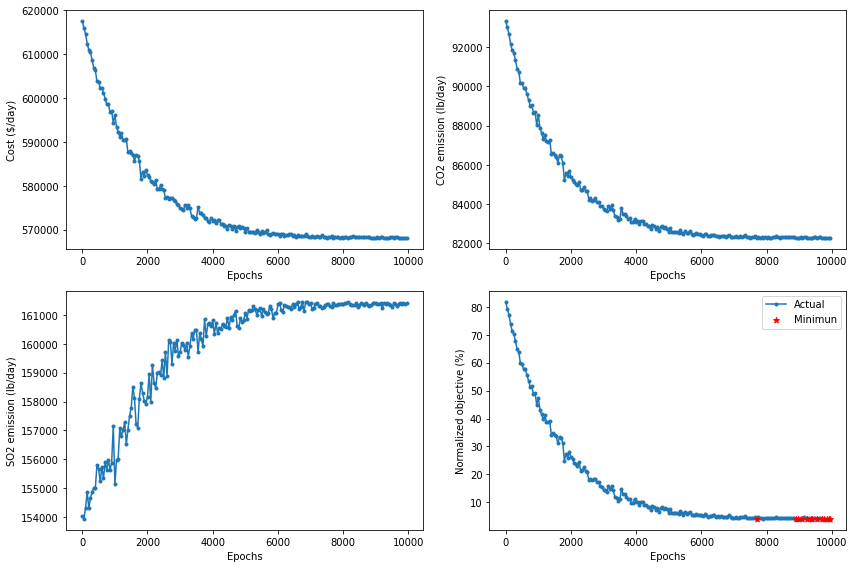

In [250]:

from matplotlib.ticker import FormatStrFormatter
# Function to create custom x-axis tick locations and labels
def custom_x_ticks(start, stop, step):
    return [start] + [i for i in range(start + step, stop + 1, step)]

x_tick_locations = custom_x_ticks(start=0, stop=10000, step=2000)
x_tick_labels = [str(val) for val in x_tick_locations]

epochs = tri_data["Epoch"]  
cost_values = tri_data["Total Cost"].to_numpy()
co2_values = tri_data["Total CO2"].to_numpy() 
so2_values = tri_data["Total SO2"].to_numpy() 
obj_values = (0.60778* (cost_values - min(cost_values)) / (max(cost_values) - min(cost_values)) +
              0.05568 * (co2_values - min(co2_values)) / (max(co2_values) - min(co2_values)) +
              0.33654 *(so2_values - min(so2_values)) / (max(so2_values) - min(so2_values))) * 100

# Reshape data to calculate the average every 100 epochs
num_averages = 50
cost_averages = np.mean(cost_values.reshape(-1, num_averages), axis=1)
so2_averages = np.mean(co2_values.reshape(-1, num_averages), axis=1)
co2_averages = np.mean(so2_values.reshape(-1, num_averages), axis=1)
obj_averages = np.mean(obj_values.reshape(-1, num_averages), axis=1)

# Create a 2x2 layout of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# First subplot (top-left)
axs[0, 0].plot(epochs[::num_averages], cost_averages, label='Cost', linestyle='-', marker='.')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Cost ($/day)')


# Second subplot (top-right)
axs[0, 1].plot(epochs[::num_averages], co2_averages, label='CO2', linestyle='-', marker='.')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('CO2 emission (lb/day)')

# Third subplot (bottom-left)
axs[1, 0].plot(epochs[::num_averages], so2_averages, label='SO2', linestyle='-', marker='.')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('SO2 emission (lb/day)')


# Fourth subplot (bottom-right) - Empty subplot
axs[1, 1].plot(epochs[::num_averages], obj_averages, label='Actual', linestyle='-', marker='.')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Normalized objective (%)')
threshold = 4.1
a = (0.60778* (568091.2 - min(cost_values)) / (max(cost_values) - min(cost_values)) +
              0.05568 * (161403.6 - min(co2_values)) / (max(co2_values) - min(co2_values)) +
              0.33654 *(82261.0 - min(so2_values)) / (max(so2_values) - min(so2_values))) * 100

print(a) #=4.1

highlighted_epochs = [epoch for epoch, obj in zip(epochs[::num_averages], obj_averages) if obj <= threshold]
highlighted_obj = [obj for obj in obj_averages if obj <= threshold]

plt.scatter(highlighted_epochs, highlighted_obj, color='red', marker='*', label='Minimun', zorder=5)
plt.legend()
plt.xticks(x_tick_locations, x_tick_labels)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()

In [81]:
# class DQNet(nn.Module):
#     def __init__(self, environ, hidden_nodes):
#         super(DQNet, self).__init__()
#         self.environ = environ
#         self.input_nodes = len(flatten(self.environ.reset()))
#         self.output_nodes = 2 * self.environ.n_units
        
#         self.model = nn.Sequential(
#             nn.Linear(self.input_nodes, hidden_nodes),
#             nn.ReLU(),
#             nn.Linear(hidden_nodes, self.output_nodes),
#             nn.ReLU()
#         )
    
#     def forward(self, state_vec):
#         return self.model(torch.as_tensor(state_vec).float())
    
# env_10 = ABRLEnv4UC(supply_df = pd.read_csv('Supply_Profiles_with_VPE_Data.csv'), 
#                          demand_df = pd.read_csv('Demand_Profiles_Data.csv'), 
#                          n_objs = "bi", 
#                          sr = 0.10, w = [1, 0]
#                    )
# DQN_model_10 = DQNet(env_10, 64)
# print(DQN_model_10)

# RL_agents_10 = DQNAgents(environ = env_10, 
#                          model = DQN_model_10, 
#                          epsilon_max = 0.0,
#                          epsilon_min = 0.00,
#                          epsilon_decay = 0.9993,
#                          lr = 0.001,
#                          lr_gamma = 0.9997)

# results_10_df = RL_agents_10.train(buffer_size = 128, batch_size = 128, num_epochs = 10)
# cost, emis, CO2, SO2, schedules_10_df = get_schedules(environ = env_10, trained_agents = RL_agents_10)
# schedules_10_df

DQNet(
  (model): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=20, bias=True)
    (3): ReLU()
  )
)
"ECONOMIC COST" Optimization


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\esawo\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Epoch: 1 | Steps = 24.0 | Rewards = 7203.32 | Eps. = 0.000 | LR = 0.001 | Cost = 613156.9 | Emis. = 47832.7 | 
Epoch: 2 | Steps = 24.0 | Rewards = 7168.99 | Eps. = 0.000 | LR = 0.001 | Cost = 609112.5 | Emis. = 49356.8 | 
Epoch: 3 | Steps = 24.0 | Rewards = 7185.32 | Eps. = 0.000 | LR = 0.001 | Cost = 613733.3 | Emis. = 49431.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7187.14 | Eps. = 0.000 | LR = 0.001 | Cost = 610637.6 | Emis. = 49726.5 | 
Epoch: 5 | Steps = 24.0 | Rewards = 7194.64 | Eps. = 0.000 | LR = 0.001 | Cost = 609519.5 | Emis. = 49173.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7207.59 | Eps. = 0.000 | LR = 0.001 | Cost = 611227.8 | Emis. = 47839.2 | 
Epoch: 7 | Steps = 24.0 | Rewards = 7198.77 | Eps. = 0.000 | LR = 0.001 | Cost = 613609.3 | Emis. = 47520.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7184.42 | Eps. = 0.000 | LR = 0.001 | Cost = 612933.5 | Emis. = 48731.3 | 
Epoch: 9 | Steps = 24.0 | Rewards = 7213.98 | Eps. = 0.000 | LR = 0.001 | Cost = 609731.4 | Emis. = 47576.1 | 
E

,Hour,Demand,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,Reserve (%),Startup Cost,Shutdown Cost,Production Cost,Total Cost,Startup Emission,Shutdown Emission,Production Emission,Total Emission
0,1,700.0,1,1,1,1,0,0,1,0,0,0,326.5,194.5,24.0,130.0,0.0,0.0,25.0,0.0,0.0,0.0,46.6,1370.0,0.0,16951.1,18321.1,0.0,0.0,906.0,906.0
1,2,750.0,1,1,1,1,0,0,1,0,0,0,249.9,215.1,130.0,130.0,0.0,0.0,25.0,0.0,0.0,0.0,25.3,0.0,0.0,17349.1,17349.1,0.0,0.0,932.1,932.1
2,3,850.0,1,1,1,1,0,0,1,0,0,0,323.1,241.9,130.0,130.0,0.0,0.0,25.0,0.0,0.0,0.0,22.4,0.0,0.0,18855.0,18855.0,0.0,0.0,1139.9,1139.9
3,4,950.0,1,1,1,1,1,0,1,0,0,0,325.8,321.9,130.0,122.3,25.0,0.0,25.0,0.0,0.0,0.0,35.2,900.0,0.0,21496.3,22396.3,0.0,0.0,1338.0,1338.0
4,5,1000.0,1,1,1,1,1,0,1,0,0,0,400.9,374.1,50.0,125.0,25.0,0.0,25.0,0.0,0.0,0.0,29.9,0.0,0.0,22202.4,22202.4,0.0,0.0,1585.8,1585.8
5,6,1100.0,1,1,1,1,1,0,1,0,0,0,403.1,374.1,96.2,130.0,71.6,0.0,25.0,0.0,0.0,0.0,22.3,0.0,0.0,23962.5,23962.5,0.0,0.0,1705.7,1705.7
6,7,1150.0,1,1,1,1,1,0,1,0,0,0,455.0,381.3,130.0,130.0,28.7,0.0,25.0,0.0,0.0,0.0,13.4,0.0,0.0,24570.8,24570.8,0.0,0.0,1979.4,1979.4
7,8,1200.0,1,1,1,1,1,1,1,0,0,0,455.0,455.0,90.0,130.0,25.0,20.0,25.0,0.0,0.0,0.0,15.0,340.0,0.0,26254.8,26594.8,0.0,0.0,2205.1,2205.1
8,9,1300.0,1,1,1,1,1,1,1,1,0,0,455.0,455.0,130.0,130.0,25.9,24.1,25.0,55.0,0.0,0.0,10.0,60.0,0.0,28876.1,28936.1,0.0,0.0,2546.4,2546.4
9,10,1400.0,1,1,1,1,1,1,1,1,1,1,455.0,455.0,130.0,130.0,69.9,74.1,25.0,10.0,10.0,41.1,12.5,120.0,0.0,32788.5,32908.5,0.0,0.0,3246.7,3246.7


In [ ]:
step = 0.01
w_cost_vec = np.arange(0, 1 + step, step)
w_cost_vec

hidden_nodes = [32, 256, 256]
dupls = [1, 5, 10]
weights_exploration = {} 

for i in range(len(dupls)):
    results = []
    print("********************************************************************************************************")
    print(f"UNITS {dupls[i] * 10}")
    for w_idx in range(len(w_cost_vec)):
        w_cost = w_cost_vec[w_idx]
        class DQNet(nn.Module):
            def __init__(self, environ, hidden_nodes):
                super(DQNet, self).__init__()
                self.environ = environ
                self.input_nodes = len(flatten(self.environ.reset()))
                self.output_nodes = 2 * self.environ.n_units

                self.model = nn.Sequential(
                    nn.Linear(self.input_nodes, hidden_nodes),
                    nn.ReLU(),
                    nn.Linear(hidden_nodes, self.output_nodes),
                    nn.ReLU()
                )

            def forward(self, state_vec):
                return self.model(torch.as_tensor(state_vec).float())

        env = ABRLEnv4UC(supply_df = pd.read_csv('Supply_Profiles_with_VPE_Data.csv'), 
                         demand_df = pd.read_csv('Demand_Profiles_Data.csv'), 
                         n_objs = "bi", 
                         sr = 0.10, w = [w_cost, 1 - w_cost], duplicates = dupls[i])
        DQN_model = DQNet(env, hidden_nodes[i])
        print(DQN_model)

        RL_agents = DQNAgents(environ = env,  model = DQN_model, epsilon_max = 0.0, epsilon_min = 0.0,
                              epsilon_decay = 0.999, lr = 0.02, lr_gamma = 1.0)

        results_df = RL_agents.train(buffer_size = 32, batch_size = 32, num_epochs = 20)
        cost, emis, CO2, SO2, schedules_df = get_schedules(environ = env, trained_agents = RL_agents)
        results.append([w_cost, cost, emis, CO2, SO2])
        print(f"Units = {dupls[i] * 10}, Weight = {w_cost}, Cost = {cost}, Emis = {emis}, CO2 = {CO2}, SO2 = {SO2}")
        
    weights_exploration["Units " + str(dupls[i] * 10)] = results
    print("********************************************************************************************************")

********************************************************************************************************
UNITS 10
DQNet(
  (model): Sequential(
    (0): Linear(in_features=22, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=20, bias=True)
    (3): ReLU()
  )
)
"ENVIRONMENTAL EMISSION" Optimization


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8448.84 | Eps. = 0.000 | LR = 0.020 | Cost = 628423.6 | Emis. = 37125.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8903.25 | Eps. = 0.000 | LR = 0.020 | Cost = 628423.7 | Emis. = 37125.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8903.25 | Eps. = 0.000 | LR = 0.020 | Cost = 628423.8 | Emis. = 37125.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8903.25 | Eps. = 0.000 | LR = 0.020 | Cost = 628423.7 | Emis. = 37125.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8903.25 | Eps. = 0.000 | LR = 0.020 | Cost = 628423.8 | Emis. = 37125.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8903.25 | Eps. = 0.000 | LR = 0.020 | Cost = 628424.2 | Emis. = 37125.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8903.25 | Eps. = 0.000 | LR = 0.020 | Cost = 628423.9 | Emis. = 37125.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8903.25 | Eps. = 0.000 | LR = 0.020 | Cost = 628423.6 | Emis. = 37125.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8903.25 | Eps. = 0.000 | LR = 0.020 | Cost = 628423.6 | Emis. = 37125.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7671.27 | Eps. = 0.000 | LR = 0.020 | Cost = 625539.1 | Emis. = 38240.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7988.95 | Eps. = 0.000 | LR = 0.020 | Cost = 623338.0 | Emis. = 37913.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7988.95 | Eps. = 0.000 | LR = 0.020 | Cost = 623344.9 | Emis. = 37913.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7892.76 | Eps. = 0.000 | LR = 0.020 | Cost = 644790.3 | Emis. = 39742.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7832.44 | Eps. = 0.000 | LR = 0.020 | Cost = 623345.1 | Emis. = 37913.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7988.94 | Eps. = 0.000 | LR = 0.020 | Cost = 623344.8 | Emis. = 37913.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7988.94 | Eps. = 0.000 | LR = 0.020 | Cost = 623345.1 | Emis. = 37913.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8135.56 | Eps. = 0.000 | LR = 0.020 | Cost = 638180.4 | Emis. = 36427.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8018.24 | Eps. = 0.000 | LR = 0.020 | Cost = 634311.0 | Emis. = 36733.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7845.64 | Eps. = 0.000 | LR = 0.020 | Cost = 630151.2 | Emis. = 37456.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8003.25 | Eps. = 0.000 | LR = 0.020 | Cost = 622064.8 | Emis. = 37936.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8003.21 | Eps. = 0.000 | LR = 0.020 | Cost = 622046.5 | Emis. = 37936.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8003.22 | Eps. = 0.000 | LR = 0.020 | Cost = 622044.4 | Emis. = 37936.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8003.24 | Eps. = 0.000 | LR = 0.020 | Cost = 622067.4 | Emis. = 37936.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8003.23 | Eps. = 0.000 | LR = 0.020 | Cost = 622043.9 | Emis. = 37936.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8003.27 | Eps. = 0.000 | LR = 0.020 | Cost = 622045.0 | Emis. = 37936.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8003.25 | Eps. = 0.000 | LR = 0.020 | Cost = 622040.1 | Emis. = 37936.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8003.24 | Eps. = 0.000 | LR = 0.020 | Cost = 622043.4 | Emis. = 37936.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7741.88 | Eps. = 0.000 | LR = 0.020 | Cost = 641055.5 | Emis. = 40114.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7866.01 | Eps. = 0.000 | LR = 0.020 | Cost = 620817.9 | Emis. = 37953.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 620960.8 | Emis. = 37952.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 621536.7 | Emis. = 37947.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 620960.5 | Emis. = 37952.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8019.51 | Eps. = 0.000 | LR = 0.020 | Cost = 633151.5 | Emis. = 36343.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8019.51 | Eps. = 0.000 | LR = 0.020 | Cost = 621523.7 | Emis. = 37947.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 620955.8 | Emis. = 37952.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 621530.0 | Emis. = 37947.3

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7461.86 | Eps. = 0.000 | LR = 0.020 | Cost = 651393.5 | Emis. = 39540.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7866.01 | Eps. = 0.000 | LR = 0.020 | Cost = 641062.9 | Emis. = 40122.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7866.01 | Eps. = 0.000 | LR = 0.020 | Cost = 620154.2 | Emis. = 37974.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 620756.7 | Emis. = 37973.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 621690.5 | Emis. = 37968.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 620790.0 | Emis. = 37973.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7980.06 | Eps. = 0.000 | LR = 0.020 | Cost = 620782.0 | Emis. = 37999.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 620843.9 | Emis. = 37964.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 620811.4 | Emis. = 37964.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7671.82 | Eps. = 0.000 | LR = 0.020 | Cost = 637999.1 | Emis. = 39918.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7868.54 | Eps. = 0.000 | LR = 0.020 | Cost = 638233.4 | Emis. = 39908.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 635940.5 | Emis. = 40830.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 638514.9 | Emis. = 39942.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7870.05 | Eps. = 0.000 | LR = 0.020 | Cost = 638231.6 | Emis. = 39909.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 628734.4 | Emis. = 38920.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7868.54 | Eps. = 0.000 | LR = 0.020 | Cost = 638236.4 | Emis. = 39908.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7870.06 | Eps. = 0.000 | LR = 0.020 | Cost = 638658.4 | Emis. = 39949.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7919.87 | Eps. = 0.000 | LR = 0.020 | Cost = 627893.3 | Emis. = 38374.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7810.55 | Eps. = 0.000 | LR = 0.020 | Cost = 655563.8 | Emis. = 41998.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7699.66 | Eps. = 0.000 | LR = 0.020 | Cost = 630611.0 | Emis. = 39724.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7865.72 | Eps. = 0.000 | LR = 0.020 | Cost = 629779.4 | Emis. = 39703.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8017.30 | Eps. = 0.000 | LR = 0.020 | Cost = 620228.1 | Emis. = 38038.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8146.24 | Eps. = 0.000 | LR = 0.020 | Cost = 625820.6 | Emis. = 36643.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8148.95 | Eps. = 0.000 | LR = 0.020 | Cost = 615936.6 | Emis. = 37680.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 617780.4 | Emis. = 37712.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7980.09 | Eps. = 0.000 | LR = 0.020 | Cost = 620186.9 | Emis. = 38038.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8148.95 | Eps. = 0.000 | LR = 0.020 | Cost = 620388.0 | Emis. = 38016.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7626.68 | Eps. = 0.000 | LR = 0.020 | Cost = 629078.1 | Emis. = 39124.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7880.93 | Eps. = 0.000 | LR = 0.020 | Cost = 630138.9 | Emis. = 36389.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8148.95 | Eps. = 0.000 | LR = 0.020 | Cost = 619830.9 | Emis. = 38065.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8103.16 | Eps. = 0.000 | LR = 0.020 | Cost = 615101.2 | Emis. = 37805.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 617850.3 | Emis. = 37757.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8148.95 | Eps. = 0.000 | LR = 0.020 | Cost = 616399.5 | Emis. = 37734.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8148.95 | Eps. = 0.000 | LR = 0.020 | Cost = 620863.6 | Emis. = 37787.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8017.17 | Eps. = 0.000 | LR = 0.020 | Cost = 621202.4 | Emis. = 37793.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8093.48 | Eps. = 0.000 | LR = 0.020 | Cost = 621822.1 | Emis. = 38088.3

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8057.62 | Eps. = 0.000 | LR = 0.020 | Cost = 623010.6 | Emis. = 36670.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8150.29 | Eps. = 0.000 | LR = 0.020 | Cost = 620866.3 | Emis. = 36421.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8093.49 | Eps. = 0.000 | LR = 0.020 | Cost = 619460.0 | Emis. = 36731.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7993.59 | Eps. = 0.000 | LR = 0.020 | Cost = 612777.8 | Emis. = 37137.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7993.69 | Eps. = 0.000 | LR = 0.020 | Cost = 616105.3 | Emis. = 38024.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8135.76 | Eps. = 0.000 | LR = 0.020 | Cost = 618885.3 | Emis. = 38113.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7992.71 | Eps. = 0.000 | LR = 0.020 | Cost = 615511.6 | Emis. = 37581.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8103.69 | Eps. = 0.000 | LR = 0.020 | Cost = 618750.7 | Emis. = 38036.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8017.30 | Eps. = 0.000 | LR = 0.020 | Cost = 611590.8 | Emis. = 37714.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7713.27 | Eps. = 0.000 | LR = 0.020 | Cost = 639406.7 | Emis. = 39890.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7864.55 | Eps. = 0.000 | LR = 0.020 | Cost = 639966.3 | Emis. = 40155.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8089.55 | Eps. = 0.000 | LR = 0.020 | Cost = 620011.2 | Emis. = 37987.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7990.61 | Eps. = 0.000 | LR = 0.020 | Cost = 619271.5 | Emis. = 37534.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8017.17 | Eps. = 0.000 | LR = 0.020 | Cost = 618271.7 | Emis. = 38039.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8006.76 | Eps. = 0.000 | LR = 0.020 | Cost = 620482.0 | Emis. = 38295.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8017.30 | Eps. = 0.000 | LR = 0.020 | Cost = 617337.8 | Emis. = 38234.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8017.17 | Eps. = 0.000 | LR = 0.020 | Cost = 611154.6 | Emis. = 37845.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8160.96 | Eps. = 0.000 | LR = 0.020 | Cost = 625496.7 | Emis. = 36606.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7666.63 | Eps. = 0.000 | LR = 0.020 | Cost = 628278.7 | Emis. = 36374.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8160.31 | Eps. = 0.000 | LR = 0.020 | Cost = 615653.4 | Emis. = 38293.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8103.41 | Eps. = 0.000 | LR = 0.020 | Cost = 613675.3 | Emis. = 38002.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8103.05 | Eps. = 0.000 | LR = 0.020 | Cost = 619196.1 | Emis. = 37798.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8015.59 | Eps. = 0.000 | LR = 0.020 | Cost = 618333.0 | Emis. = 37615.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8092.86 | Eps. = 0.000 | LR = 0.020 | Cost = 614144.0 | Emis. = 36934.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8116.16 | Eps. = 0.000 | LR = 0.020 | Cost = 618953.1 | Emis. = 38123.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8103.08 | Eps. = 0.000 | LR = 0.020 | Cost = 613290.9 | Emis. = 38083.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8149.11 | Eps. = 0.000 | LR = 0.020 | Cost = 620004.3 | Emis. = 38236.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8143.40 | Eps. = 0.000 | LR = 0.020 | Cost = 620847.8 | Emis. = 36601.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8105.20 | Eps. = 0.000 | LR = 0.020 | Cost = 615367.5 | Emis. = 38003.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8099.24 | Eps. = 0.000 | LR = 0.020 | Cost = 611887.5 | Emis. = 37261.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8125.36 | Eps. = 0.000 | LR = 0.020 | Cost = 613143.5 | Emis. = 37654.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8019.63 | Eps. = 0.000 | LR = 0.020 | Cost = 615018.7 | Emis. = 38278.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8017.17 | Eps. = 0.000 | LR = 0.020 | Cost = 609366.7 | Emis. = 37810.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7990.59 | Eps. = 0.000 | LR = 0.020 | Cost = 617274.7 | Emis. = 38202.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7977.29 | Eps. = 0.000 | LR = 0.020 | Cost = 608661.7 | Emis. = 37842.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8015.24 | Eps. = 0.000 | LR = 0.020 | Cost = 616907.1 | Emis. = 38159.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8120.00 | Eps. = 0.000 | LR = 0.020 | Cost = 613080.5 | Emis. = 37557.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8107.01 | Eps. = 0.000 | LR = 0.020 | Cost = 615706.1 | Emis. = 38333.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8018.33 | Eps. = 0.000 | LR = 0.020 | Cost = 617248.5 | Emis. = 38541.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8017.17 | Eps. = 0.000 | LR = 0.020 | Cost = 610675.2 | Emis. = 37905.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8015.49 | Eps. = 0.000 | LR = 0.020 | Cost = 608675.9 | Emis. = 38333.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8002.84 | Eps. = 0.000 | LR = 0.020 | Cost = 610432.6 | Emis. = 38189.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8017.42 | Eps. = 0.000 | LR = 0.020 | Cost = 611788.0 | Emis. = 38087.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8106.49 | Eps. = 0.000 | LR = 0.020 | Cost = 635293.1 | Emis. = 40324.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7823.15 | Eps. = 0.000 | LR = 0.020 | Cost = 606400.2 | Emis. = 38415.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8068.98 | Eps. = 0.000 | LR = 0.020 | Cost = 649951.9 | Emis. = 38602.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7864.03 | Eps. = 0.000 | LR = 0.020 | Cost = 634834.0 | Emis. = 41003.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7855.96 | Eps. = 0.000 | LR = 0.020 | Cost = 626226.6 | Emis. = 41381.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7861.21 | Eps. = 0.000 | LR = 0.020 | Cost = 634264.1 | Emis. = 40939.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8022.99 | Eps. = 0.000 | LR = 0.020 | Cost = 609482.4 | Emis. = 37998.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8015.24 | Eps. = 0.000 | LR = 0.020 | Cost = 607265.7 | Emis. = 38266.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8002.69 | Eps. = 0.000 | LR = 0.020 | Cost = 610692.4 | Emis. = 37913.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7980.26 | Eps. = 0.000 | LR = 0.020 | Cost = 618482.9 | Emis. = 38241.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8017.38 | Eps. = 0.000 | LR = 0.020 | Cost = 611359.3 | Emis. = 38009.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7880.37 | Eps. = 0.000 | LR = 0.020 | Cost = 618141.8 | Emis. = 37609.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8121.98 | Eps. = 0.000 | LR = 0.020 | Cost = 616526.5 | Emis. = 37235.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8083.73 | Eps. = 0.000 | LR = 0.020 | Cost = 612283.0 | Emis. = 37120.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8082.92 | Eps. = 0.000 | LR = 0.020 | Cost = 608627.3 | Emis. = 38409.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7999.70 | Eps. = 0.000 | LR = 0.020 | Cost = 607396.9 | Emis. = 38036.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7993.05 | Eps. = 0.000 | LR = 0.020 | Cost = 611560.7 | Emis. = 37879.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8016.12 | Eps. = 0.000 | LR = 0.020 | Cost = 605491.1 | Emis. = 37875.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7992.88 | Eps. = 0.000 | LR = 0.020 | Cost = 609218.1 | Emis. = 38274.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8017.05 | Eps. = 0.000 | LR = 0.020 | Cost = 612030.4 | Emis. = 38249.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8022.95 | Eps. = 0.000 | LR = 0.020 | Cost = 617363.8 | Emis. = 41659.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8021.42 | Eps. = 0.000 | LR = 0.020 | Cost = 601849.5 | Emis. = 38630.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8118.37 | Eps. = 0.000 | LR = 0.020 | Cost = 611295.4 | Emis. = 37189.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7881.07 | Eps. = 0.000 | LR = 0.020 | Cost = 618018.0 | Emis. = 40749.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7859.04 | Eps. = 0.000 | LR = 0.020 | Cost = 617154.4 | Emis. = 40408.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8016.42 | Eps. = 0.000 | LR = 0.020 | Cost = 607395.7 | Emis. = 38737.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8038.09 | Eps. = 0.000 | LR = 0.020 | Cost = 606859.3 | Emis. = 38458.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8003.70 | Eps. = 0.000 | LR = 0.020 | Cost = 614879.2 | Emis. = 38389.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8015.40 | Eps. = 0.000 | LR = 0.020 | Cost = 610923.9 | Emis. = 38668.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7676.61 | Eps. = 0.000 | LR = 0.020 | Cost = 607939.5 | Emis. = 37251.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8077.23 | Eps. = 0.000 | LR = 0.020 | Cost = 622801.8 | Emis. = 37723.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8096.75 | Eps. = 0.000 | LR = 0.020 | Cost = 613652.7 | Emis. = 38449.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8110.96 | Eps. = 0.000 | LR = 0.020 | Cost = 623921.9 | Emis. = 37199.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8093.54 | Eps. = 0.000 | LR = 0.020 | Cost = 611567.9 | Emis. = 37409.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8112.29 | Eps. = 0.000 | LR = 0.020 | Cost = 616735.7 | Emis. = 37655.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8106.33 | Eps. = 0.000 | LR = 0.020 | Cost = 611967.4 | Emis. = 37515.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8115.38 | Eps. = 0.000 | LR = 0.020 | Cost = 607407.0 | Emis. = 37605.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8113.09 | Eps. = 0.000 | LR = 0.020 | Cost = 615549.5 | Emis. = 37301.3

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8049.18 | Eps. = 0.000 | LR = 0.020 | Cost = 621685.7 | Emis. = 41251.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8002.34 | Eps. = 0.000 | LR = 0.020 | Cost = 609525.2 | Emis. = 38354.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8011.77 | Eps. = 0.000 | LR = 0.020 | Cost = 606334.9 | Emis. = 38909.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8003.72 | Eps. = 0.000 | LR = 0.020 | Cost = 605094.8 | Emis. = 38580.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8119.24 | Eps. = 0.000 | LR = 0.020 | Cost = 607466.2 | Emis. = 38675.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8012.25 | Eps. = 0.000 | LR = 0.020 | Cost = 604584.1 | Emis. = 38837.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8010.11 | Eps. = 0.000 | LR = 0.020 | Cost = 613794.6 | Emis. = 38551.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7998.49 | Eps. = 0.000 | LR = 0.020 | Cost = 603423.4 | Emis. = 38847.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8001.32 | Eps. = 0.000 | LR = 0.020 | Cost = 612058.8 | Emis. = 39027.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8094.40 | Eps. = 0.000 | LR = 0.020 | Cost = 623001.8 | Emis. = 41312.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7906.49 | Eps. = 0.000 | LR = 0.020 | Cost = 604137.9 | Emis. = 38907.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8020.82 | Eps. = 0.000 | LR = 0.020 | Cost = 612245.3 | Emis. = 37725.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8023.37 | Eps. = 0.000 | LR = 0.020 | Cost = 606233.1 | Emis. = 39451.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7996.28 | Eps. = 0.000 | LR = 0.020 | Cost = 607391.5 | Emis. = 38480.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8003.25 | Eps. = 0.000 | LR = 0.020 | Cost = 599350.2 | Emis. = 38847.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8028.91 | Eps. = 0.000 | LR = 0.020 | Cost = 606311.1 | Emis. = 39273.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7993.11 | Eps. = 0.000 | LR = 0.020 | Cost = 609230.4 | Emis. = 38276.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.13 | Eps. = 0.000 | LR = 0.020 | Cost = 613788.0 | Emis. = 38733.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7879.13 | Eps. = 0.000 | LR = 0.020 | Cost = 614922.4 | Emis. = 38649.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8137.20 | Eps. = 0.000 | LR = 0.020 | Cost = 604730.6 | Emis. = 38653.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8005.56 | Eps. = 0.000 | LR = 0.020 | Cost = 605334.9 | Emis. = 38395.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8167.35 | Eps. = 0.000 | LR = 0.020 | Cost = 612665.6 | Emis. = 38115.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8124.35 | Eps. = 0.000 | LR = 0.020 | Cost = 610203.2 | Emis. = 38229.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8087.95 | Eps. = 0.000 | LR = 0.020 | Cost = 607105.7 | Emis. = 38685.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8156.49 | Eps. = 0.000 | LR = 0.020 | Cost = 603855.7 | Emis. = 38775.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8020.66 | Eps. = 0.000 | LR = 0.020 | Cost = 603521.3 | Emis. = 39206.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8036.56 | Eps. = 0.000 | LR = 0.020 | Cost = 602712.0 | Emis. = 39575.3

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7872.14 | Eps. = 0.000 | LR = 0.020 | Cost = 623998.7 | Emis. = 41351.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8157.33 | Eps. = 0.000 | LR = 0.020 | Cost = 623734.0 | Emis. = 39255.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7880.92 | Eps. = 0.000 | LR = 0.020 | Cost = 630296.1 | Emis. = 42037.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7928.94 | Eps. = 0.000 | LR = 0.020 | Cost = 626997.8 | Emis. = 41336.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7897.55 | Eps. = 0.000 | LR = 0.020 | Cost = 606055.7 | Emis. = 38031.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7963.63 | Eps. = 0.000 | LR = 0.020 | Cost = 602648.1 | Emis. = 39042.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8018.93 | Eps. = 0.000 | LR = 0.020 | Cost = 612172.3 | Emis. = 39046.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8126.00 | Eps. = 0.000 | LR = 0.020 | Cost = 605721.2 | Emis. = 38262.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8017.30 | Eps. = 0.000 | LR = 0.020 | Cost = 607284.5 | Emis. = 39219.3

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\esawo\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Epoch: 2 | Steps = 24.0 | Rewards = 7675.98 | Eps. = 0.000 | LR = 0.020 | Cost = 612523.5 | Emis. = 39360.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7864.71 | Eps. = 0.000 | LR = 0.020 | Cost = 604457.7 | Emis. = 39445.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8113.86 | Eps. = 0.000 | LR = 0.020 | Cost = 602339.7 | Emis. = 39446.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8120.72 | Eps. = 0.000 | LR = 0.020 | Cost = 604508.5 | Emis. = 38973.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8016.35 | Eps. = 0.000 | LR = 0.020 | Cost = 609036.3 | Emis. = 37979.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8016.17 | Eps. = 0.000 | LR = 0.020 | Cost = 603514.0 | Emis. = 39343.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8000.62 | Eps. = 0.000 | LR = 0.020 | Cost = 605017.2 | Emis. = 39035.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8064.49 | Eps. = 0.000 | LR = 0.020 | Cost = 603177.0 | Emis. = 39494.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7992.93 | Eps. = 0.000 | LR = 0.020 | Cost = 607605.5 | Emis. = 39053.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7650.80 | Eps. = 0.000 | LR = 0.020 | Cost = 617103.4 | Emis. = 42623.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8072.23 | Eps. = 0.000 | LR = 0.020 | Cost = 612486.1 | Emis. = 38592.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8068.90 | Eps. = 0.000 | LR = 0.020 | Cost = 610072.3 | Emis. = 39790.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7978.78 | Eps. = 0.000 | LR = 0.020 | Cost = 601992.4 | Emis. = 39812.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8117.80 | Eps. = 0.000 | LR = 0.020 | Cost = 610180.5 | Emis. = 39297.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8065.08 | Eps. = 0.000 | LR = 0.020 | Cost = 607707.8 | Emis. = 39498.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8041.34 | Eps. = 0.000 | LR = 0.020 | Cost = 605614.3 | Emis. = 39661.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8015.54 | Eps. = 0.000 | LR = 0.020 | Cost = 603434.2 | Emis. = 39673.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8009.27 | Eps. = 0.000 | LR = 0.020 | Cost = 607021.7 | Emis. = 38724.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7871.52 | Eps. = 0.000 | LR = 0.020 | Cost = 602799.3 | Emis. = 39812.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8017.12 | Eps. = 0.000 | LR = 0.020 | Cost = 600957.8 | Emis. = 39625.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8018.09 | Eps. = 0.000 | LR = 0.020 | Cost = 602572.0 | Emis. = 39704.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7989.00 | Eps. = 0.000 | LR = 0.020 | Cost = 608663.2 | Emis. = 38098.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8085.22 | Eps. = 0.000 | LR = 0.020 | Cost = 616461.3 | Emis. = 38499.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8067.17 | Eps. = 0.000 | LR = 0.020 | Cost = 600628.5 | Emis. = 39051.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8016.35 | Eps. = 0.000 | LR = 0.020 | Cost = 608110.0 | Emis. = 38709.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7961.19 | Eps. = 0.000 | LR = 0.020 | Cost = 602815.1 | Emis. = 39387.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7995.86 | Eps. = 0.000 | LR = 0.020 | Cost = 605192.3 | Emis. = 39454.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7849.06 | Eps. = 0.000 | LR = 0.020 | Cost = 625498.7 | Emis. = 43003.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7850.65 | Eps. = 0.000 | LR = 0.020 | Cost = 601390.8 | Emis. = 40224.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7826.85 | Eps. = 0.000 | LR = 0.020 | Cost = 603965.6 | Emis. = 39665.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7990.15 | Eps. = 0.000 | LR = 0.020 | Cost = 602911.7 | Emis. = 39470.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7982.09 | Eps. = 0.000 | LR = 0.020 | Cost = 607806.6 | Emis. = 38590.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8012.86 | Eps. = 0.000 | LR = 0.020 | Cost = 605391.6 | Emis. = 39486.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8005.35 | Eps. = 0.000 | LR = 0.020 | Cost = 608913.3 | Emis. = 39670.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8082.79 | Eps. = 0.000 | LR = 0.020 | Cost = 602197.7 | Emis. = 40590.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8000.01 | Eps. = 0.000 | LR = 0.020 | Cost = 604994.1 | Emis. = 40083.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7830.34 | Eps. = 0.000 | LR = 0.020 | Cost = 606022.3 | Emis. = 39059.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7795.05 | Eps. = 0.000 | LR = 0.020 | Cost = 621935.5 | Emis. = 43654.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7865.14 | Eps. = 0.000 | LR = 0.020 | Cost = 612560.2 | Emis. = 41420.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8017.17 | Eps. = 0.000 | LR = 0.020 | Cost = 608260.0 | Emis. = 39113.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8005.40 | Eps. = 0.000 | LR = 0.020 | Cost = 602233.6 | Emis. = 39684.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8049.14 | Eps. = 0.000 | LR = 0.020 | Cost = 608904.6 | Emis. = 40644.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7974.38 | Eps. = 0.000 | LR = 0.020 | Cost = 608717.3 | Emis. = 40071.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8010.92 | Eps. = 0.000 | LR = 0.020 | Cost = 608560.2 | Emis. = 39276.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8116.49 | Eps. = 0.000 | LR = 0.020 | Cost = 604496.2 | Emis. = 39100.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7823.88 | Eps. = 0.000 | LR = 0.020 | Cost = 640387.4 | Emis. = 48677.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7627.30 | Eps. = 0.000 | LR = 0.020 | Cost = 613366.5 | Emis. = 42641.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7868.84 | Eps. = 0.000 | LR = 0.020 | Cost = 620840.1 | Emis. = 43240.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7880.52 | Eps. = 0.000 | LR = 0.020 | Cost = 622983.2 | Emis. = 42728.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8111.22 | Eps. = 0.000 | LR = 0.020 | Cost = 606418.1 | Emis. = 39589.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8081.51 | Eps. = 0.000 | LR = 0.020 | Cost = 601168.2 | Emis. = 39637.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8138.57 | Eps. = 0.000 | LR = 0.020 | Cost = 603552.8 | Emis. = 39553.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8017.66 | Eps. = 0.000 | LR = 0.020 | Cost = 603791.6 | Emis. = 40007.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8061.03 | Eps. = 0.000 | LR = 0.020 | Cost = 602313.8 | Emis. = 40319.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8046.83 | Eps. = 0.000 | LR = 0.020 | Cost = 623634.3 | Emis. = 41421.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7826.22 | Eps. = 0.000 | LR = 0.020 | Cost = 625823.5 | Emis. = 44213.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7796.59 | Eps. = 0.000 | LR = 0.020 | Cost = 617012.8 | Emis. = 40144.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8041.37 | Eps. = 0.000 | LR = 0.020 | Cost = 631726.3 | Emis. = 42451.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7851.22 | Eps. = 0.000 | LR = 0.020 | Cost = 618519.8 | Emis. = 43656.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7908.96 | Eps. = 0.000 | LR = 0.020 | Cost = 623995.1 | Emis. = 42381.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8004.36 | Eps. = 0.000 | LR = 0.020 | Cost = 606168.3 | Emis. = 41422.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7783.46 | Eps. = 0.000 | LR = 0.020 | Cost = 615455.1 | Emis. = 43100.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8011.43 | Eps. = 0.000 | LR = 0.020 | Cost = 613167.5 | Emis. = 41422.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7829.61 | Eps. = 0.000 | LR = 0.020 | Cost = 630327.0 | Emis. = 42426.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8038.68 | Eps. = 0.000 | LR = 0.020 | Cost = 599909.1 | Emis. = 39705.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8127.98 | Eps. = 0.000 | LR = 0.020 | Cost = 601770.6 | Emis. = 40717.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8078.59 | Eps. = 0.000 | LR = 0.020 | Cost = 601523.9 | Emis. = 39632.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8085.22 | Eps. = 0.000 | LR = 0.020 | Cost = 603691.1 | Emis. = 39908.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8027.03 | Eps. = 0.000 | LR = 0.020 | Cost = 601214.2 | Emis. = 39689.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8127.43 | Eps. = 0.000 | LR = 0.020 | Cost = 603772.1 | Emis. = 40278.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8109.75 | Eps. = 0.000 | LR = 0.020 | Cost = 598944.2 | Emis. = 40221.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7996.62 | Eps. = 0.000 | LR = 0.020 | Cost = 607414.0 | Emis. = 40237.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7930.02 | Eps. = 0.000 | LR = 0.020 | Cost = 606722.5 | Emis. = 42031.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7865.03 | Eps. = 0.000 | LR = 0.020 | Cost = 612415.5 | Emis. = 45047.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7875.76 | Eps. = 0.000 | LR = 0.020 | Cost = 617938.5 | Emis. = 43237.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7861.23 | Eps. = 0.000 | LR = 0.020 | Cost = 616443.4 | Emis. = 43774.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7852.81 | Eps. = 0.000 | LR = 0.020 | Cost = 604565.4 | Emis. = 41928.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7852.84 | Eps. = 0.000 | LR = 0.020 | Cost = 607673.6 | Emis. = 42142.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7878.07 | Eps. = 0.000 | LR = 0.020 | Cost = 615890.6 | Emis. = 42731.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7868.84 | Eps. = 0.000 | LR = 0.020 | Cost = 614199.9 | Emis. = 43274.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8107.06 | Eps. = 0.000 | LR = 0.020 | Cost = 607959.8 | Emis. = 40917.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8085.26 | Eps. = 0.000 | LR = 0.020 | Cost = 608310.8 | Emis. = 40915.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7764.54 | Eps. = 0.000 | LR = 0.020 | Cost = 626833.7 | Emis. = 49298.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7584.69 | Eps. = 0.000 | LR = 0.020 | Cost = 630531.0 | Emis. = 50994.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7888.47 | Eps. = 0.000 | LR = 0.020 | Cost = 626868.0 | Emis. = 44313.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7808.55 | Eps. = 0.000 | LR = 0.020 | Cost = 625751.3 | Emis. = 44675.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8112.49 | Eps. = 0.000 | LR = 0.020 | Cost = 605460.5 | Emis. = 40133.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8111.80 | Eps. = 0.000 | LR = 0.020 | Cost = 603358.5 | Emis. = 41072.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8083.06 | Eps. = 0.000 | LR = 0.020 | Cost = 603369.5 | Emis. = 40845.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8004.03 | Eps. = 0.000 | LR = 0.020 | Cost = 604124.7 | Emis. = 40860.3

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8098.06 | Eps. = 0.000 | LR = 0.020 | Cost = 604287.9 | Emis. = 39896.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7935.36 | Eps. = 0.000 | LR = 0.020 | Cost = 609892.0 | Emis. = 41002.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8029.90 | Eps. = 0.000 | LR = 0.020 | Cost = 608005.7 | Emis. = 39930.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8018.15 | Eps. = 0.000 | LR = 0.020 | Cost = 608399.3 | Emis. = 39847.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8099.64 | Eps. = 0.000 | LR = 0.020 | Cost = 600571.0 | Emis. = 41602.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7986.24 | Eps. = 0.000 | LR = 0.020 | Cost = 599573.7 | Emis. = 41276.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8129.87 | Eps. = 0.000 | LR = 0.020 | Cost = 599558.1 | Emis. = 40572.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8033.07 | Eps. = 0.000 | LR = 0.020 | Cost = 607680.9 | Emis. = 40849.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8021.50 | Eps. = 0.000 | LR = 0.020 | Cost = 600854.0 | Emis. = 41230.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7730.93 | Eps. = 0.000 | LR = 0.020 | Cost = 598312.7 | Emis. = 40587.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8012.93 | Eps. = 0.000 | LR = 0.020 | Cost = 600056.7 | Emis. = 41288.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8049.04 | Eps. = 0.000 | LR = 0.020 | Cost = 600770.6 | Emis. = 41215.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8111.26 | Eps. = 0.000 | LR = 0.020 | Cost = 600822.3 | Emis. = 41089.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8014.83 | Eps. = 0.000 | LR = 0.020 | Cost = 600324.9 | Emis. = 41243.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8024.58 | Eps. = 0.000 | LR = 0.020 | Cost = 603044.5 | Emis. = 40023.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8028.97 | Eps. = 0.000 | LR = 0.020 | Cost = 602632.8 | Emis. = 42323.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8106.26 | Eps. = 0.000 | LR = 0.020 | Cost = 607486.7 | Emis. = 39435.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7981.91 | Eps. = 0.000 | LR = 0.020 | Cost = 600574.6 | Emis. = 41096.7

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8017.68 | Eps. = 0.000 | LR = 0.020 | Cost = 604963.8 | Emis. = 40573.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8139.61 | Eps. = 0.000 | LR = 0.020 | Cost = 608927.9 | Emis. = 39480.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8011.71 | Eps. = 0.000 | LR = 0.020 | Cost = 608851.6 | Emis. = 41897.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8000.21 | Eps. = 0.000 | LR = 0.020 | Cost = 599631.8 | Emis. = 41484.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8136.70 | Eps. = 0.000 | LR = 0.020 | Cost = 600969.9 | Emis. = 40872.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8058.43 | Eps. = 0.000 | LR = 0.020 | Cost = 603420.3 | Emis. = 41373.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8013.84 | Eps. = 0.000 | LR = 0.020 | Cost = 604787.5 | Emis. = 41874.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8037.91 | Eps. = 0.000 | LR = 0.020 | Cost = 604552.0 | Emis. = 40313.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8017.36 | Eps. = 0.000 | LR = 0.020 | Cost = 607507.7 | Emis. = 41620.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7848.90 | Eps. = 0.000 | LR = 0.020 | Cost = 613416.3 | Emis. = 41931.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7863.31 | Eps. = 0.000 | LR = 0.020 | Cost = 617366.1 | Emis. = 44522.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7839.80 | Eps. = 0.000 | LR = 0.020 | Cost = 617429.5 | Emis. = 43645.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7935.85 | Eps. = 0.000 | LR = 0.020 | Cost = 612023.3 | Emis. = 41094.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7809.52 | Eps. = 0.000 | LR = 0.020 | Cost = 598666.8 | Emis. = 40496.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7999.60 | Eps. = 0.000 | LR = 0.020 | Cost = 600681.5 | Emis. = 42248.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8050.15 | Eps. = 0.000 | LR = 0.020 | Cost = 607334.4 | Emis. = 41802.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8029.38 | Eps. = 0.000 | LR = 0.020 | Cost = 596796.1 | Emis. = 41683.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8035.12 | Eps. = 0.000 | LR = 0.020 | Cost = 600198.6 | Emis. = 41604.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7816.88 | Eps. = 0.000 | LR = 0.020 | Cost = 608321.6 | Emis. = 39664.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8076.44 | Eps. = 0.000 | LR = 0.020 | Cost = 601663.3 | Emis. = 41427.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8006.72 | Eps. = 0.000 | LR = 0.020 | Cost = 600462.6 | Emis. = 40800.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7959.12 | Eps. = 0.000 | LR = 0.020 | Cost = 605672.0 | Emis. = 39079.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8109.03 | Eps. = 0.000 | LR = 0.020 | Cost = 598229.6 | Emis. = 42796.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7984.16 | Eps. = 0.000 | LR = 0.020 | Cost = 604050.2 | Emis. = 41911.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8031.02 | Eps. = 0.000 | LR = 0.020 | Cost = 603893.4 | Emis. = 41461.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8017.56 | Eps. = 0.000 | LR = 0.020 | Cost = 600334.5 | Emis. = 41008.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7996.05 | Eps. = 0.000 | LR = 0.020 | Cost = 598604.2 | Emis. = 42911.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7766.39 | Eps. = 0.000 | LR = 0.020 | Cost = 599311.7 | Emis. = 41020.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7993.99 | Eps. = 0.000 | LR = 0.020 | Cost = 595445.8 | Emis. = 42204.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 605054.1 | Emis. = 43118.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7980.79 | Eps. = 0.000 | LR = 0.020 | Cost = 613045.5 | Emis. = 45358.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7784.28 | Eps. = 0.000 | LR = 0.020 | Cost = 598748.1 | Emis. = 41511.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7983.19 | Eps. = 0.000 | LR = 0.020 | Cost = 598215.9 | Emis. = 41796.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8123.99 | Eps. = 0.000 | LR = 0.020 | Cost = 598600.7 | Emis. = 41414.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8007.05 | Eps. = 0.000 | LR = 0.020 | Cost = 599030.2 | Emis. = 42858.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8014.15 | Eps. = 0.000 | LR = 0.020 | Cost = 601403.6 | Emis. = 41652.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7843.68 | Eps. = 0.000 | LR = 0.020 | Cost = 617480.7 | Emis. = 44369.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7796.71 | Eps. = 0.000 | LR = 0.020 | Cost = 598784.0 | Emis. = 42545.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7972.84 | Eps. = 0.000 | LR = 0.020 | Cost = 598699.7 | Emis. = 41226.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8035.26 | Eps. = 0.000 | LR = 0.020 | Cost = 602567.7 | Emis. = 41901.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8011.34 | Eps. = 0.000 | LR = 0.020 | Cost = 602894.7 | Emis. = 41703.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7992.97 | Eps. = 0.000 | LR = 0.020 | Cost = 604528.2 | Emis. = 41721.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8026.15 | Eps. = 0.000 | LR = 0.020 | Cost = 600376.9 | Emis. = 41664.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8011.65 | Eps. = 0.000 | LR = 0.020 | Cost = 599214.5 | Emis. = 42093.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7994.16 | Eps. = 0.000 | LR = 0.020 | Cost = 596434.5 | Emis. = 43027.3

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8114.88 | Eps. = 0.000 | LR = 0.020 | Cost = 615722.1 | Emis. = 47506.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7785.14 | Eps. = 0.000 | LR = 0.020 | Cost = 605889.4 | Emis. = 41640.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8040.25 | Eps. = 0.000 | LR = 0.020 | Cost = 606689.1 | Emis. = 43004.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8007.83 | Eps. = 0.000 | LR = 0.020 | Cost = 607420.1 | Emis. = 41265.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8012.37 | Eps. = 0.000 | LR = 0.020 | Cost = 600497.4 | Emis. = 43011.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8106.25 | Eps. = 0.000 | LR = 0.020 | Cost = 598420.2 | Emis. = 41354.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7969.61 | Eps. = 0.000 | LR = 0.020 | Cost = 598294.1 | Emis. = 41515.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7999.54 | Eps. = 0.000 | LR = 0.020 | Cost = 598379.8 | Emis. = 42052.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7992.13 | Eps. = 0.000 | LR = 0.020 | Cost = 605887.8 | Emis. = 41835.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7915.13 | Eps. = 0.000 | LR = 0.020 | Cost = 600268.9 | Emis. = 42026.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7992.25 | Eps. = 0.000 | LR = 0.020 | Cost = 605993.5 | Emis. = 45840.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7982.81 | Eps. = 0.000 | LR = 0.020 | Cost = 597256.4 | Emis. = 42976.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7973.43 | Eps. = 0.000 | LR = 0.020 | Cost = 600029.9 | Emis. = 41685.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8018.59 | Eps. = 0.000 | LR = 0.020 | Cost = 598797.2 | Emis. = 41360.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8121.56 | Eps. = 0.000 | LR = 0.020 | Cost = 604712.9 | Emis. = 42010.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8015.93 | Eps. = 0.000 | LR = 0.020 | Cost = 597017.8 | Emis. = 41326.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8012.37 | Eps. = 0.000 | LR = 0.020 | Cost = 592600.7 | Emis. = 43590.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.39 | Eps. = 0.000 | LR = 0.020 | Cost = 606398.3 | Emis. = 41564.3

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7846.41 | Eps. = 0.000 | LR = 0.020 | Cost = 621038.3 | Emis. = 46830.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8045.91 | Eps. = 0.000 | LR = 0.020 | Cost = 603265.7 | Emis. = 41714.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8036.58 | Eps. = 0.000 | LR = 0.020 | Cost = 597044.9 | Emis. = 42960.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8034.56 | Eps. = 0.000 | LR = 0.020 | Cost = 597991.7 | Emis. = 43173.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7957.13 | Eps. = 0.000 | LR = 0.020 | Cost = 595972.0 | Emis. = 43932.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8026.62 | Eps. = 0.000 | LR = 0.020 | Cost = 600083.1 | Emis. = 42016.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8112.78 | Eps. = 0.000 | LR = 0.020 | Cost = 598169.7 | Emis. = 41556.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8086.82 | Eps. = 0.000 | LR = 0.020 | Cost = 602861.1 | Emis. = 41942.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7984.51 | Eps. = 0.000 | LR = 0.020 | Cost = 597623.4 | Emis. = 43121.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7543.13 | Eps. = 0.000 | LR = 0.020 | Cost = 603918.3 | Emis. = 44933.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8043.83 | Eps. = 0.000 | LR = 0.020 | Cost = 596860.7 | Emis. = 43572.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8139.35 | Eps. = 0.000 | LR = 0.020 | Cost = 598592.9 | Emis. = 42405.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8116.67 | Eps. = 0.000 | LR = 0.020 | Cost = 598577.1 | Emis. = 41747.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8018.68 | Eps. = 0.000 | LR = 0.020 | Cost = 605044.7 | Emis. = 42572.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7992.41 | Eps. = 0.000 | LR = 0.020 | Cost = 593839.3 | Emis. = 43399.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8002.71 | Eps. = 0.000 | LR = 0.020 | Cost = 593134.7 | Emis. = 44068.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8104.61 | Eps. = 0.000 | LR = 0.020 | Cost = 599749.0 | Emis. = 41863.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8001.93 | Eps. = 0.000 | LR = 0.020 | Cost = 600530.6 | Emis. = 41552.5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7561.89 | Eps. = 0.000 | LR = 0.020 | Cost = 599490.9 | Emis. = 43193.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8002.49 | Eps. = 0.000 | LR = 0.020 | Cost = 598075.8 | Emis. = 41851.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8012.57 | Eps. = 0.000 | LR = 0.020 | Cost = 604587.4 | Emis. = 42125.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8109.29 | Eps. = 0.000 | LR = 0.020 | Cost = 601288.0 | Emis. = 42565.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7972.38 | Eps. = 0.000 | LR = 0.020 | Cost = 601107.8 | Emis. = 42362.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7979.62 | Eps. = 0.000 | LR = 0.020 | Cost = 608151.3 | Emis. = 41144.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8021.31 | Eps. = 0.000 | LR = 0.020 | Cost = 597595.5 | Emis. = 42360.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8008.17 | Eps. = 0.000 | LR = 0.020 | Cost = 598513.6 | Emis. = 42596.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7979.05 | Eps. = 0.000 | LR = 0.020 | Cost = 599357.9 | Emis. = 42200.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7596.88 | Eps. = 0.000 | LR = 0.020 | Cost = 625458.0 | Emis. = 51829.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7599.78 | Eps. = 0.000 | LR = 0.020 | Cost = 596755.9 | Emis. = 42587.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8010.88 | Eps. = 0.000 | LR = 0.020 | Cost = 600646.2 | Emis. = 43501.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8023.79 | Eps. = 0.000 | LR = 0.020 | Cost = 594349.8 | Emis. = 43560.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7998.07 | Eps. = 0.000 | LR = 0.020 | Cost = 601230.4 | Emis. = 43699.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8121.67 | Eps. = 0.000 | LR = 0.020 | Cost = 596630.1 | Emis. = 43884.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8036.17 | Eps. = 0.000 | LR = 0.020 | Cost = 601157.0 | Emis. = 41975.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8018.29 | Eps. = 0.000 | LR = 0.020 | Cost = 595779.1 | Emis. = 42088.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8002.28 | Eps. = 0.000 | LR = 0.020 | Cost = 596717.8 | Emis. = 41794.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7905.39 | Eps. = 0.000 | LR = 0.020 | Cost = 596927.0 | Emis. = 42858.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8019.38 | Eps. = 0.000 | LR = 0.020 | Cost = 592189.5 | Emis. = 44828.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7996.99 | Eps. = 0.000 | LR = 0.020 | Cost = 597073.6 | Emis. = 44242.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8120.71 | Eps. = 0.000 | LR = 0.020 | Cost = 595342.5 | Emis. = 43910.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7994.48 | Eps. = 0.000 | LR = 0.020 | Cost = 596749.9 | Emis. = 43302.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8010.20 | Eps. = 0.000 | LR = 0.020 | Cost = 600814.2 | Emis. = 41510.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7999.50 | Eps. = 0.000 | LR = 0.020 | Cost = 594250.6 | Emis. = 44214.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7995.43 | Eps. = 0.000 | LR = 0.020 | Cost = 594467.1 | Emis. = 44156.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8016.39 | Eps. = 0.000 | LR = 0.020 | Cost = 600276.2 | Emis. = 43837.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7448.85 | Eps. = 0.000 | LR = 0.020 | Cost = 639607.4 | Emis. = 51272.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7852.05 | Eps. = 0.000 | LR = 0.020 | Cost = 607185.2 | Emis. = 48454.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7849.93 | Eps. = 0.000 | LR = 0.020 | Cost = 615773.6 | Emis. = 48917.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8003.24 | Eps. = 0.000 | LR = 0.020 | Cost = 597226.8 | Emis. = 43683.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8000.31 | Eps. = 0.000 | LR = 0.020 | Cost = 597144.4 | Emis. = 42154.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7953.13 | Eps. = 0.000 | LR = 0.020 | Cost = 592114.8 | Emis. = 43541.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8022.74 | Eps. = 0.000 | LR = 0.020 | Cost = 595519.8 | Emis. = 43985.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8002.82 | Eps. = 0.000 | LR = 0.020 | Cost = 596872.3 | Emis. = 43570.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8111.96 | Eps. = 0.000 | LR = 0.020 | Cost = 600311.8 | Emis. = 41515.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8094.73 | Eps. = 0.000 | LR = 0.020 | Cost = 599926.5 | Emis. = 41565.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8121.89 | Eps. = 0.000 | LR = 0.020 | Cost = 600059.6 | Emis. = 41189.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8012.57 | Eps. = 0.000 | LR = 0.020 | Cost = 593991.9 | Emis. = 42206.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8030.98 | Eps. = 0.000 | LR = 0.020 | Cost = 596024.2 | Emis. = 43189.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8097.50 | Eps. = 0.000 | LR = 0.020 | Cost = 596908.2 | Emis. = 42059.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8016.51 | Eps. = 0.000 | LR = 0.020 | Cost = 594272.4 | Emis. = 44077.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8022.60 | Eps. = 0.000 | LR = 0.020 | Cost = 612912.8 | Emis. = 47570.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7799.02 | Eps. = 0.000 | LR = 0.020 | Cost = 607338.2 | Emis. = 46828.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8030.93 | Eps. = 0.000 | LR = 0.020 | Cost = 600448.0 | Emis. = 41989.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7594.20 | Eps. = 0.000 | LR = 0.020 | Cost = 600727.3 | Emis. = 43468.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8002.71 | Eps. = 0.000 | LR = 0.020 | Cost = 593307.9 | Emis. = 44225.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7973.71 | Eps. = 0.000 | LR = 0.020 | Cost = 598518.6 | Emis. = 43814.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7971.58 | Eps. = 0.000 | LR = 0.020 | Cost = 596039.1 | Emis. = 43524.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8000.90 | Eps. = 0.000 | LR = 0.020 | Cost = 599815.4 | Emis. = 42670.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8007.58 | Eps. = 0.000 | LR = 0.020 | Cost = 595929.5 | Emis. = 43541.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8095.85 | Eps. = 0.000 | LR = 0.020 | Cost = 595220.3 | Emis. = 43589.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8021.68 | Eps. = 0.000 | LR = 0.020 | Cost = 594244.6 | Emis. = 44068.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8012.42 | Eps. = 0.000 | LR = 0.020 | Cost = 600394.6 | Emis. = 42841.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7943.54 | Eps. = 0.000 | LR = 0.020 | Cost = 595758.0 | Emis. = 43874.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8037.86 | Eps. = 0.000 | LR = 0.020 | Cost = 602859.6 | Emis. = 43056.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8104.89 | Eps. = 0.000 | LR = 0.020 | Cost = 598726.2 | Emis. = 43113.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8044.59 | Eps. = 0.000 | LR = 0.020 | Cost = 595740.9 | Emis. = 44904.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8121.45 | Eps. = 0.000 | LR = 0.020 | Cost = 596492.7 | Emis. = 43703.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8037.87 | Eps. = 0.000 | LR = 0.020 | Cost = 596980.0 | Emis. = 43999.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7981.25 | Eps. = 0.000 | LR = 0.020 | Cost = 598096.1 | Emis. = 41845.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8046.18 | Eps. = 0.000 | LR = 0.020 | Cost = 595578.8 | Emis. = 44455.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8037.89 | Eps. = 0.000 | LR = 0.020 | Cost = 598187.1 | Emis. = 43406.5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7870.90 | Eps. = 0.000 | LR = 0.020 | Cost = 626483.5 | Emis. = 52644.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7746.48 | Eps. = 0.000 | LR = 0.020 | Cost = 595066.2 | Emis. = 42100.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8001.57 | Eps. = 0.000 | LR = 0.020 | Cost = 591100.8 | Emis. = 43957.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8006.05 | Eps. = 0.000 | LR = 0.020 | Cost = 598322.1 | Emis. = 42732.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8019.97 | Eps. = 0.000 | LR = 0.020 | Cost = 600846.1 | Emis. = 43393.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8015.95 | Eps. = 0.000 | LR = 0.020 | Cost = 593185.8 | Emis. = 43916.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8049.80 | Eps. = 0.000 | LR = 0.020 | Cost = 591457.7 | Emis. = 45256.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8117.94 | Eps. = 0.000 | LR = 0.020 | Cost = 594706.9 | Emis. = 44340.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8071.54 | Eps. = 0.000 | LR = 0.020 | Cost = 591275.7 | Emis. = 43250.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7758.91 | Eps. = 0.000 | LR = 0.020 | Cost = 598825.3 | Emis. = 44174.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8025.24 | Eps. = 0.000 | LR = 0.020 | Cost = 594796.3 | Emis. = 45363.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8017.36 | Eps. = 0.000 | LR = 0.020 | Cost = 596954.3 | Emis. = 43910.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8021.34 | Eps. = 0.000 | LR = 0.020 | Cost = 599771.6 | Emis. = 42059.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8011.00 | Eps. = 0.000 | LR = 0.020 | Cost = 590792.4 | Emis. = 44268.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7996.11 | Eps. = 0.000 | LR = 0.020 | Cost = 603388.0 | Emis. = 44227.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8009.96 | Eps. = 0.000 | LR = 0.020 | Cost = 599836.5 | Emis. = 44199.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7946.50 | Eps. = 0.000 | LR = 0.020 | Cost = 602696.8 | Emis. = 43375.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8009.96 | Eps. = 0.000 | LR = 0.020 | Cost = 599716.6 | Emis. = 46209.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8074.14 | Eps. = 0.000 | LR = 0.020 | Cost = 605552.9 | Emis. = 49574.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8075.65 | Eps. = 0.000 | LR = 0.020 | Cost = 601243.9 | Emis. = 42245.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7998.02 | Eps. = 0.000 | LR = 0.020 | Cost = 603942.3 | Emis. = 42110.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8048.58 | Eps. = 0.000 | LR = 0.020 | Cost = 596396.8 | Emis. = 43265.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8017.02 | Eps. = 0.000 | LR = 0.020 | Cost = 606531.7 | Emis. = 43539.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8025.75 | Eps. = 0.000 | LR = 0.020 | Cost = 593963.6 | Emis. = 44865.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7997.35 | Eps. = 0.000 | LR = 0.020 | Cost = 597952.9 | Emis. = 44676.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8012.76 | Eps. = 0.000 | LR = 0.020 | Cost = 596623.1 | Emis. = 44538.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8021.00 | Eps. = 0.000 | LR = 0.020 | Cost = 596573.5 | Emis. = 43919.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8194.33 | Eps. = 0.000 | LR = 0.020 | Cost = 600782.5 | Emis. = 42588.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8001.11 | Eps. = 0.000 | LR = 0.020 | Cost = 594991.0 | Emis. = 44241.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7948.98 | Eps. = 0.000 | LR = 0.020 | Cost = 603940.6 | Emis. = 41872.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7997.38 | Eps. = 0.000 | LR = 0.020 | Cost = 591981.7 | Emis. = 43634.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7990.50 | Eps. = 0.000 | LR = 0.020 | Cost = 595271.3 | Emis. = 44092.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8016.50 | Eps. = 0.000 | LR = 0.020 | Cost = 597942.6 | Emis. = 42501.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8017.54 | Eps. = 0.000 | LR = 0.020 | Cost = 595745.5 | Emis. = 44206.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7984.10 | Eps. = 0.000 | LR = 0.020 | Cost = 600381.8 | Emis. = 43653.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8005.02 | Eps. = 0.000 | LR = 0.020 | Cost = 597603.2 | Emis. = 43072.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8032.92 | Eps. = 0.000 | LR = 0.020 | Cost = 601402.9 | Emis. = 44447.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8014.90 | Eps. = 0.000 | LR = 0.020 | Cost = 594780.8 | Emis. = 44088.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7987.76 | Eps. = 0.000 | LR = 0.020 | Cost = 602922.8 | Emis. = 42674.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8003.50 | Eps. = 0.000 | LR = 0.020 | Cost = 596767.8 | Emis. = 44363.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8020.25 | Eps. = 0.000 | LR = 0.020 | Cost = 598935.4 | Emis. = 44238.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8121.35 | Eps. = 0.000 | LR = 0.020 | Cost = 598171.8 | Emis. = 44223.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8034.26 | Eps. = 0.000 | LR = 0.020 | Cost = 601316.8 | Emis. = 43372.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7998.49 | Eps. = 0.000 | LR = 0.020 | Cost = 596545.9 | Emis. = 44407.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7990.01 | Eps. = 0.000 | LR = 0.020 | Cost = 597840.7 | Emis. = 43299.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7635.71 | Eps. = 0.000 | LR = 0.020 | Cost = 611019.4 | Emis. = 46674.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8032.68 | Eps. = 0.000 | LR = 0.020 | Cost = 597603.2 | Emis. = 44796.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8018.39 | Eps. = 0.000 | LR = 0.020 | Cost = 596364.3 | Emis. = 42801.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8005.15 | Eps. = 0.000 | LR = 0.020 | Cost = 598725.0 | Emis. = 43895.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8021.20 | Eps. = 0.000 | LR = 0.020 | Cost = 607711.0 | Emis. = 49483.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7802.61 | Eps. = 0.000 | LR = 0.020 | Cost = 613829.3 | Emis. = 47766.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7763.19 | Eps. = 0.000 | LR = 0.020 | Cost = 604352.8 | Emis. = 46394.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7791.08 | Eps. = 0.000 | LR = 0.020 | Cost = 612476.1 | Emis. = 47724.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7802.45 | Eps. = 0.000 | LR = 0.020 | Cost = 602451.6 | Emis. = 47191.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7619.62 | Eps. = 0.000 | LR = 0.020 | Cost = 622376.8 | Emis. = 53968.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8005.65 | Eps. = 0.000 | LR = 0.020 | Cost = 597875.2 | Emis. = 45524.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7998.58 | Eps. = 0.000 | LR = 0.020 | Cost = 596790.2 | Emis. = 43490.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8018.43 | Eps. = 0.000 | LR = 0.020 | Cost = 592596.2 | Emis. = 43930.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7994.54 | Eps. = 0.000 | LR = 0.020 | Cost = 594270.4 | Emis. = 46021.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8022.16 | Eps. = 0.000 | LR = 0.020 | Cost = 597736.8 | Emis. = 42790.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8022.56 | Eps. = 0.000 | LR = 0.020 | Cost = 594471.6 | Emis. = 43997.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7987.19 | Eps. = 0.000 | LR = 0.020 | Cost = 597586.5 | Emis. = 43005.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7764.30 | Eps. = 0.000 | LR = 0.020 | Cost = 603443.6 | Emis. = 45263.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8004.15 | Eps. = 0.000 | LR = 0.020 | Cost = 595092.4 | Emis. = 43451.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7990.90 | Eps. = 0.000 | LR = 0.020 | Cost = 596669.9 | Emis. = 46100.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7733.18 | Eps. = 0.000 | LR = 0.020 | Cost = 605514.1 | Emis. = 48034.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7843.88 | Eps. = 0.000 | LR = 0.020 | Cost = 608951.7 | Emis. = 49329.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8116.99 | Eps. = 0.000 | LR = 0.020 | Cost = 592417.5 | Emis. = 44507.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7992.62 | Eps. = 0.000 | LR = 0.020 | Cost = 596921.0 | Emis. = 45965.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8094.71 | Eps. = 0.000 | LR = 0.020 | Cost = 594809.3 | Emis. = 45103.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8070.50 | Eps. = 0.000 | LR = 0.020 | Cost = 598666.6 | Emis. = 44178.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7987.76 | Eps. = 0.000 | LR = 0.020 | Cost = 594666.4 | Emis. = 43817.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8071.68 | Eps. = 0.000 | LR = 0.020 | Cost = 599020.1 | Emis. = 45558.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7870.26 | Eps. = 0.000 | LR = 0.020 | Cost = 605031.8 | Emis. = 49324.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7813.08 | Eps. = 0.000 | LR = 0.020 | Cost = 591517.1 | Emis. = 44029.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7840.14 | Eps. = 0.000 | LR = 0.020 | Cost = 601167.6 | Emis. = 44550.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8035.98 | Eps. = 0.000 | LR = 0.020 | Cost = 603897.5 | Emis. = 43195.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7942.61 | Eps. = 0.000 | LR = 0.020 | Cost = 598047.8 | Emis. = 43465.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7977.02 | Eps. = 0.000 | LR = 0.020 | Cost = 594234.9 | Emis. = 44910.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8002.71 | Eps. = 0.000 | LR = 0.020 | Cost = 593898.4 | Emis. = 44325.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8026.81 | Eps. = 0.000 | LR = 0.020 | Cost = 591376.2 | Emis. = 45225.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7740.23 | Eps. = 0.000 | LR = 0.020 | Cost = 608088.3 | Emis. = 47041.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8017.36 | Eps. = 0.000 | LR = 0.020 | Cost = 592099.5 | Emis. = 43623.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7994.72 | Eps. = 0.000 | LR = 0.020 | Cost = 593815.9 | Emis. = 44817.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7997.19 | Eps. = 0.000 | LR = 0.020 | Cost = 590336.9 | Emis. = 45442.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7992.04 | Eps. = 0.000 | LR = 0.020 | Cost = 598200.5 | Emis. = 44867.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8005.92 | Eps. = 0.000 | LR = 0.020 | Cost = 596589.5 | Emis. = 44752.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7998.07 | Eps. = 0.000 | LR = 0.020 | Cost = 601637.4 | Emis. = 45729.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7996.06 | Eps. = 0.000 | LR = 0.020 | Cost = 597858.7 | Emis. = 44840.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8007.95 | Eps. = 0.000 | LR = 0.020 | Cost = 590545.5 | Emis. = 44895.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7617.95 | Eps. = 0.000 | LR = 0.020 | Cost = 597406.9 | Emis. = 45128.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8012.46 | Eps. = 0.000 | LR = 0.020 | Cost = 594234.3 | Emis. = 45365.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7810.33 | Eps. = 0.000 | LR = 0.020 | Cost = 593816.4 | Emis. = 44230.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8014.84 | Eps. = 0.000 | LR = 0.020 | Cost = 595542.7 | Emis. = 45001.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7972.55 | Eps. = 0.000 | LR = 0.020 | Cost = 603242.9 | Emis. = 44918.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8019.84 | Eps. = 0.000 | LR = 0.020 | Cost = 597219.1 | Emis. = 45443.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7992.23 | Eps. = 0.000 | LR = 0.020 | Cost = 598282.3 | Emis. = 43324.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8021.43 | Eps. = 0.000 | LR = 0.020 | Cost = 599452.6 | Emis. = 43579.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7970.60 | Eps. = 0.000 | LR = 0.020 | Cost = 597897.8 | Emis. = 43836.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7772.93 | Eps. = 0.000 | LR = 0.020 | Cost = 620661.8 | Emis. = 53743.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8040.24 | Eps. = 0.000 | LR = 0.020 | Cost = 610405.2 | Emis. = 49532.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7992.66 | Eps. = 0.000 | LR = 0.020 | Cost = 592612.2 | Emis. = 44708.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7993.11 | Eps. = 0.000 | LR = 0.020 | Cost = 597513.2 | Emis. = 43075.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7971.49 | Eps. = 0.000 | LR = 0.020 | Cost = 593869.1 | Emis. = 44276.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8006.45 | Eps. = 0.000 | LR = 0.020 | Cost = 596423.6 | Emis. = 45073.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7954.77 | Eps. = 0.000 | LR = 0.020 | Cost = 591352.1 | Emis. = 45692.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7991.11 | Eps. = 0.000 | LR = 0.020 | Cost = 598447.0 | Emis. = 44630.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8001.71 | Eps. = 0.000 | LR = 0.020 | Cost = 591250.9 | Emis. = 44118.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7895.86 | Eps. = 0.000 | LR = 0.020 | Cost = 609634.6 | Emis. = 50279.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7402.37 | Eps. = 0.000 | LR = 0.020 | Cost = 615729.8 | Emis. = 52542.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7828.51 | Eps. = 0.000 | LR = 0.020 | Cost = 604892.5 | Emis. = 50882.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7995.80 | Eps. = 0.000 | LR = 0.020 | Cost = 597078.7 | Emis. = 45013.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8028.05 | Eps. = 0.000 | LR = 0.020 | Cost = 591141.5 | Emis. = 45602.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7963.08 | Eps. = 0.000 | LR = 0.020 | Cost = 592125.0 | Emis. = 44753.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7999.89 | Eps. = 0.000 | LR = 0.020 | Cost = 597947.8 | Emis. = 44235.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8078.37 | Eps. = 0.000 | LR = 0.020 | Cost = 597430.4 | Emis. = 44695.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8019.57 | Eps. = 0.000 | LR = 0.020 | Cost = 602153.8 | Emis. = 44540.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7794.89 | Eps. = 0.000 | LR = 0.020 | Cost = 607120.6 | Emis. = 49571.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7835.95 | Eps. = 0.000 | LR = 0.020 | Cost = 612058.3 | Emis. = 50408.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8019.11 | Eps. = 0.000 | LR = 0.020 | Cost = 596640.1 | Emis. = 43857.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8013.40 | Eps. = 0.000 | LR = 0.020 | Cost = 591486.9 | Emis. = 44387.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8018.43 | Eps. = 0.000 | LR = 0.020 | Cost = 593846.9 | Emis. = 44727.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8000.21 | Eps. = 0.000 | LR = 0.020 | Cost = 590219.2 | Emis. = 43909.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7957.42 | Eps. = 0.000 | LR = 0.020 | Cost = 600043.0 | Emis. = 45611.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8015.96 | Eps. = 0.000 | LR = 0.020 | Cost = 594079.3 | Emis. = 44525.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8080.93 | Eps. = 0.000 | LR = 0.020 | Cost = 591344.2 | Emis. = 44432.7

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7877.31 | Eps. = 0.000 | LR = 0.020 | Cost = 613798.0 | Emis. = 53209.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7961.95 | Eps. = 0.000 | LR = 0.020 | Cost = 598410.2 | Emis. = 44150.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8002.33 | Eps. = 0.000 | LR = 0.020 | Cost = 598368.9 | Emis. = 44471.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7997.92 | Eps. = 0.000 | LR = 0.020 | Cost = 598072.2 | Emis. = 43149.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8018.43 | Eps. = 0.000 | LR = 0.020 | Cost = 593627.4 | Emis. = 44808.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7970.47 | Eps. = 0.000 | LR = 0.020 | Cost = 598193.6 | Emis. = 45007.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8114.65 | Eps. = 0.000 | LR = 0.020 | Cost = 594760.4 | Emis. = 44558.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8001.21 | Eps. = 0.000 | LR = 0.020 | Cost = 596044.7 | Emis. = 44373.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8019.28 | Eps. = 0.000 | LR = 0.020 | Cost = 590954.1 | Emis. = 45213.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8034.71 | Eps. = 0.000 | LR = 0.020 | Cost = 598056.2 | Emis. = 46645.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7838.61 | Eps. = 0.000 | LR = 0.020 | Cost = 601008.0 | Emis. = 44566.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8015.96 | Eps. = 0.000 | LR = 0.020 | Cost = 595679.9 | Emis. = 43713.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7982.31 | Eps. = 0.000 | LR = 0.020 | Cost = 594371.6 | Emis. = 45159.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 593326.5 | Emis. = 45792.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8007.17 | Eps. = 0.000 | LR = 0.020 | Cost = 598709.8 | Emis. = 44682.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8132.58 | Eps. = 0.000 | LR = 0.020 | Cost = 596350.4 | Emis. = 44207.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7996.56 | Eps. = 0.000 | LR = 0.020 | Cost = 592863.3 | Emis. = 43316.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7999.50 | Eps. = 0.000 | LR = 0.020 | Cost = 593882.6 | Emis. = 44606.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7892.37 | Eps. = 0.000 | LR = 0.020 | Cost = 596940.0 | Emis. = 46084.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7993.20 | Eps. = 0.000 | LR = 0.020 | Cost = 596578.4 | Emis. = 44322.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8084.82 | Eps. = 0.000 | LR = 0.020 | Cost = 593209.3 | Emis. = 43460.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7982.88 | Eps. = 0.000 | LR = 0.020 | Cost = 595624.4 | Emis. = 44154.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8015.98 | Eps. = 0.000 | LR = 0.020 | Cost = 591894.5 | Emis. = 45682.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7955.54 | Eps. = 0.000 | LR = 0.020 | Cost = 598972.5 | Emis. = 44124.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8019.22 | Eps. = 0.000 | LR = 0.020 | Cost = 592962.8 | Emis. = 44636.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8016.22 | Eps. = 0.000 | LR = 0.020 | Cost = 597821.1 | Emis. = 45205.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7992.90 | Eps. = 0.000 | LR = 0.020 | Cost = 598483.4 | Emis. = 43875.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7518.92 | Eps. = 0.000 | LR = 0.020 | Cost = 608608.0 | Emis. = 50734.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8078.58 | Eps. = 0.000 | LR = 0.020 | Cost = 598525.0 | Emis. = 43776.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7991.70 | Eps. = 0.000 | LR = 0.020 | Cost = 586655.2 | Emis. = 44885.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8089.40 | Eps. = 0.000 | LR = 0.020 | Cost = 593613.4 | Emis. = 44735.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8005.57 | Eps. = 0.000 | LR = 0.020 | Cost = 591984.2 | Emis. = 44769.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8024.13 | Eps. = 0.000 | LR = 0.020 | Cost = 589452.6 | Emis. = 46037.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7997.22 | Eps. = 0.000 | LR = 0.020 | Cost = 591344.2 | Emis. = 45509.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8007.98 | Eps. = 0.000 | LR = 0.020 | Cost = 598987.0 | Emis. = 46045.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8098.07 | Eps. = 0.000 | LR = 0.020 | Cost = 598583.2 | Emis. = 45287.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7528.75 | Eps. = 0.000 | LR = 0.020 | Cost = 607816.7 | Emis. = 50822.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7775.80 | Eps. = 0.000 | LR = 0.020 | Cost = 597983.2 | Emis. = 48649.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7835.67 | Eps. = 0.000 | LR = 0.020 | Cost = 610361.5 | Emis. = 49807.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7953.49 | Eps. = 0.000 | LR = 0.020 | Cost = 597460.8 | Emis. = 45402.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8121.53 | Eps. = 0.000 | LR = 0.020 | Cost = 594503.8 | Emis. = 43127.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7979.72 | Eps. = 0.000 | LR = 0.020 | Cost = 600765.4 | Emis. = 46000.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8000.80 | Eps. = 0.000 | LR = 0.020 | Cost = 595063.0 | Emis. = 45817.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8037.57 | Eps. = 0.000 | LR = 0.020 | Cost = 592046.4 | Emis. = 45305.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8021.86 | Eps. = 0.000 | LR = 0.020 | Cost = 591044.1 | Emis. = 45867.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7787.41 | Eps. = 0.000 | LR = 0.020 | Cost = 606854.0 | Emis. = 48299.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8013.22 | Eps. = 0.000 | LR = 0.020 | Cost = 592253.3 | Emis. = 47125.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8000.21 | Eps. = 0.000 | LR = 0.020 | Cost = 595089.0 | Emis. = 45489.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8000.21 | Eps. = 0.000 | LR = 0.020 | Cost = 592928.6 | Emis. = 46796.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7993.62 | Eps. = 0.000 | LR = 0.020 | Cost = 589735.2 | Emis. = 45039.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8004.59 | Eps. = 0.000 | LR = 0.020 | Cost = 594874.2 | Emis. = 45065.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7744.82 | Eps. = 0.000 | LR = 0.020 | Cost = 594665.6 | Emis. = 45501.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8037.27 | Eps. = 0.000 | LR = 0.020 | Cost = 596512.1 | Emis. = 45840.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8021.57 | Eps. = 0.000 | LR = 0.020 | Cost = 592937.8 | Emis. = 44660.5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8152.89 | Eps. = 0.000 | LR = 0.020 | Cost = 599607.9 | Emis. = 44204.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8122.30 | Eps. = 0.000 | LR = 0.020 | Cost = 593000.4 | Emis. = 45820.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8002.46 | Eps. = 0.000 | LR = 0.020 | Cost = 597862.0 | Emis. = 45527.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8025.85 | Eps. = 0.000 | LR = 0.020 | Cost = 594762.0 | Emis. = 44715.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8092.69 | Eps. = 0.000 | LR = 0.020 | Cost = 593646.6 | Emis. = 45100.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7750.63 | Eps. = 0.000 | LR = 0.020 | Cost = 592778.5 | Emis. = 44482.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8033.30 | Eps. = 0.000 | LR = 0.020 | Cost = 594890.6 | Emis. = 45578.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7994.48 | Eps. = 0.000 | LR = 0.020 | Cost = 596580.8 | Emis. = 44542.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7994.83 | Eps. = 0.000 | LR = 0.020 | Cost = 590789.5 | Emis. = 45659.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8027.56 | Eps. = 0.000 | LR = 0.020 | Cost = 600151.2 | Emis. = 43837.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8000.92 | Eps. = 0.000 | LR = 0.020 | Cost = 597637.1 | Emis. = 44687.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8044.40 | Eps. = 0.000 | LR = 0.020 | Cost = 594276.3 | Emis. = 45799.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7990.06 | Eps. = 0.000 | LR = 0.020 | Cost = 594386.4 | Emis. = 44170.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8005.27 | Eps. = 0.000 | LR = 0.020 | Cost = 598548.6 | Emis. = 45065.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8042.29 | Eps. = 0.000 | LR = 0.020 | Cost = 597645.2 | Emis. = 44374.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7969.62 | Eps. = 0.000 | LR = 0.020 | Cost = 596643.1 | Emis. = 43409.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8033.65 | Eps. = 0.000 | LR = 0.020 | Cost = 606629.2 | Emis. = 44217.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8061.43 | Eps. = 0.000 | LR = 0.020 | Cost = 597471.1 | Emis. = 45104.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8003.83 | Eps. = 0.000 | LR = 0.020 | Cost = 617823.3 | Emis. = 49202.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8117.82 | Eps. = 0.000 | LR = 0.020 | Cost = 598714.3 | Emis. = 44855.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8089.42 | Eps. = 0.000 | LR = 0.020 | Cost = 600079.2 | Emis. = 44070.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8006.04 | Eps. = 0.000 | LR = 0.020 | Cost = 602716.0 | Emis. = 44419.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8005.54 | Eps. = 0.000 | LR = 0.020 | Cost = 602147.5 | Emis. = 42727.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8043.45 | Eps. = 0.000 | LR = 0.020 | Cost = 596646.0 | Emis. = 44447.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7981.67 | Eps. = 0.000 | LR = 0.020 | Cost = 601046.3 | Emis. = 43624.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7960.89 | Eps. = 0.000 | LR = 0.020 | Cost = 592638.0 | Emis. = 46730.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8064.86 | Eps. = 0.000 | LR = 0.020 | Cost = 599488.1 | Emis. = 44138.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7833.98 | Eps. = 0.000 | LR = 0.020 | Cost = 596131.1 | Emis. = 45379.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8041.52 | Eps. = 0.000 | LR = 0.020 | Cost = 598589.6 | Emis. = 44241.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7988.91 | Eps. = 0.000 | LR = 0.020 | Cost = 596294.1 | Emis. = 45116.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8002.71 | Eps. = 0.000 | LR = 0.020 | Cost = 595860.1 | Emis. = 47068.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8040.79 | Eps. = 0.000 | LR = 0.020 | Cost = 595735.2 | Emis. = 44857.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8072.82 | Eps. = 0.000 | LR = 0.020 | Cost = 593480.7 | Emis. = 44979.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7853.96 | Eps. = 0.000 | LR = 0.020 | Cost = 606467.2 | Emis. = 51337.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7793.19 | Eps. = 0.000 | LR = 0.020 | Cost = 594092.3 | Emis. = 44546.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.57 | Eps. = 0.000 | LR = 0.020 | Cost = 589614.5 | Emis. = 45265.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8028.83 | Eps. = 0.000 | LR = 0.020 | Cost = 597508.2 | Emis. = 44282.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7816.97 | Eps. = 0.000 | LR = 0.020 | Cost = 598558.3 | Emis. = 45114.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7998.32 | Eps. = 0.000 | LR = 0.020 | Cost = 612260.0 | Emis. = 50295.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7971.87 | Eps. = 0.000 | LR = 0.020 | Cost = 597544.3 | Emis. = 45224.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8001.65 | Eps. = 0.000 | LR = 0.020 | Cost = 595837.1 | Emis. = 46114.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7989.68 | Eps. = 0.000 | LR = 0.020 | Cost = 598653.0 | Emis. = 46022.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8048.59 | Eps. = 0.000 | LR = 0.020 | Cost = 595622.3 | Emis. = 44647.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7986.08 | Eps. = 0.000 | LR = 0.020 | Cost = 593985.2 | Emis. = 46832.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8003.48 | Eps. = 0.000 | LR = 0.020 | Cost = 597253.0 | Emis. = 46039.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8085.78 | Eps. = 0.000 | LR = 0.020 | Cost = 597690.3 | Emis. = 45988.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7787.69 | Eps. = 0.000 | LR = 0.020 | Cost = 601642.4 | Emis. = 49191.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7836.04 | Eps. = 0.000 | LR = 0.020 | Cost = 601420.8 | Emis. = 48370.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7817.08 | Eps. = 0.000 | LR = 0.020 | Cost = 602192.5 | Emis. = 48562.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7816.39 | Eps. = 0.000 | LR = 0.020 | Cost = 608943.8 | Emis. = 48073.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7838.16 | Eps. = 0.000 | LR = 0.020 | Cost = 603576.1 | Emis. = 48751.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7830.61 | Eps. = 0.000 | LR = 0.020 | Cost = 609753.2 | Emis. = 48555.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7842.40 | Eps. = 0.000 | LR = 0.020 | Cost = 600718.9 | Emis. = 46284.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8024.01 | Eps. = 0.000 | LR = 0.020 | Cost = 591591.8 | Emis. = 44905.5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7756.02 | Eps. = 0.000 | LR = 0.020 | Cost = 592044.9 | Emis. = 44638.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8015.33 | Eps. = 0.000 | LR = 0.020 | Cost = 591664.5 | Emis. = 44817.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8018.43 | Eps. = 0.000 | LR = 0.020 | Cost = 593415.3 | Emis. = 46430.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8016.57 | Eps. = 0.000 | LR = 0.020 | Cost = 589644.6 | Emis. = 46184.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8001.57 | Eps. = 0.000 | LR = 0.020 | Cost = 598566.0 | Emis. = 46239.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8098.29 | Eps. = 0.000 | LR = 0.020 | Cost = 594190.5 | Emis. = 45364.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7964.96 | Eps. = 0.000 | LR = 0.020 | Cost = 594603.1 | Emis. = 46399.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8035.54 | Eps. = 0.000 | LR = 0.020 | Cost = 597269.1 | Emis. = 45795.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8034.26 | Eps. = 0.000 | LR = 0.020 | Cost = 593729.3 | Emis. = 45457.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7802.27 | Eps. = 0.000 | LR = 0.020 | Cost = 619233.6 | Emis. = 53930.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8014.14 | Eps. = 0.000 | LR = 0.020 | Cost = 593027.9 | Emis. = 44428.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8057.78 | Eps. = 0.000 | LR = 0.020 | Cost = 597369.7 | Emis. = 45581.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7829.11 | Eps. = 0.000 | LR = 0.020 | Cost = 607642.4 | Emis. = 49222.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7846.58 | Eps. = 0.000 | LR = 0.020 | Cost = 594653.8 | Emis. = 44724.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7977.80 | Eps. = 0.000 | LR = 0.020 | Cost = 590105.2 | Emis. = 45438.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8041.72 | Eps. = 0.000 | LR = 0.020 | Cost = 590833.0 | Emis. = 44886.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8029.11 | Eps. = 0.000 | LR = 0.020 | Cost = 597727.7 | Emis. = 44496.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.48 | Eps. = 0.000 | LR = 0.020 | Cost = 588214.8 | Emis. = 46386.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7711.71 | Eps. = 0.000 | LR = 0.020 | Cost = 600389.1 | Emis. = 44124.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7961.95 | Eps. = 0.000 | LR = 0.020 | Cost = 605796.4 | Emis. = 51222.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8033.12 | Eps. = 0.000 | LR = 0.020 | Cost = 594911.4 | Emis. = 44480.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7963.74 | Eps. = 0.000 | LR = 0.020 | Cost = 595223.6 | Emis. = 44964.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8018.43 | Eps. = 0.000 | LR = 0.020 | Cost = 597508.2 | Emis. = 44484.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7991.04 | Eps. = 0.000 | LR = 0.020 | Cost = 592133.2 | Emis. = 44481.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7992.32 | Eps. = 0.000 | LR = 0.020 | Cost = 597086.9 | Emis. = 46099.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8026.53 | Eps. = 0.000 | LR = 0.020 | Cost = 591140.4 | Emis. = 44577.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7943.60 | Eps. = 0.000 | LR = 0.020 | Cost = 597262.6 | Emis. = 45788.7

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7819.76 | Eps. = 0.000 | LR = 0.020 | Cost = 594771.0 | Emis. = 43489.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8001.37 | Eps. = 0.000 | LR = 0.020 | Cost = 591524.0 | Emis. = 44883.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7997.38 | Eps. = 0.000 | LR = 0.020 | Cost = 591643.9 | Emis. = 45131.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8016.16 | Eps. = 0.000 | LR = 0.020 | Cost = 600812.0 | Emis. = 45001.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8001.70 | Eps. = 0.000 | LR = 0.020 | Cost = 593838.7 | Emis. = 45819.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8015.96 | Eps. = 0.000 | LR = 0.020 | Cost = 591669.4 | Emis. = 46025.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7997.38 | Eps. = 0.000 | LR = 0.020 | Cost = 595919.1 | Emis. = 46030.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8028.71 | Eps. = 0.000 | LR = 0.020 | Cost = 591469.2 | Emis. = 45267.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8023.69 | Eps. = 0.000 | LR = 0.020 | Cost = 595667.2 | Emis. = 45967.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7871.17 | Eps. = 0.000 | LR = 0.020 | Cost = 621267.9 | Emis. = 55363.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7782.21 | Eps. = 0.000 | LR = 0.020 | Cost = 597447.9 | Emis. = 44203.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8032.17 | Eps. = 0.000 | LR = 0.020 | Cost = 598451.2 | Emis. = 44389.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7987.64 | Eps. = 0.000 | LR = 0.020 | Cost = 598527.5 | Emis. = 44315.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8006.20 | Eps. = 0.000 | LR = 0.020 | Cost = 601457.3 | Emis. = 43328.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7993.69 | Eps. = 0.000 | LR = 0.020 | Cost = 595085.7 | Emis. = 45830.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7961.95 | Eps. = 0.000 | LR = 0.020 | Cost = 597374.0 | Emis. = 45124.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8086.71 | Eps. = 0.000 | LR = 0.020 | Cost = 596799.7 | Emis. = 45098.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8003.24 | Eps. = 0.000 | LR = 0.020 | Cost = 594535.8 | Emis. = 46165.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7896.02 | Eps. = 0.000 | LR = 0.020 | Cost = 596645.6 | Emis. = 44790.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8046.90 | Eps. = 0.000 | LR = 0.020 | Cost = 592169.8 | Emis. = 45288.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8003.83 | Eps. = 0.000 | LR = 0.020 | Cost = 593466.5 | Emis. = 44308.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7994.48 | Eps. = 0.000 | LR = 0.020 | Cost = 589773.6 | Emis. = 46877.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7997.38 | Eps. = 0.000 | LR = 0.020 | Cost = 600000.7 | Emis. = 45296.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7962.41 | Eps. = 0.000 | LR = 0.020 | Cost = 595153.9 | Emis. = 45358.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7997.19 | Eps. = 0.000 | LR = 0.020 | Cost = 589414.2 | Emis. = 45292.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7967.66 | Eps. = 0.000 | LR = 0.020 | Cost = 590793.1 | Emis. = 45721.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8003.63 | Eps. = 0.000 | LR = 0.020 | Cost = 590436.3 | Emis. = 47178.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7564.89 | Eps. = 0.000 | LR = 0.020 | Cost = 598442.6 | Emis. = 48503.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7995.04 | Eps. = 0.000 | LR = 0.020 | Cost = 589459.0 | Emis. = 46636.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8039.60 | Eps. = 0.000 | LR = 0.020 | Cost = 602213.4 | Emis. = 47465.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7778.42 | Eps. = 0.000 | LR = 0.020 | Cost = 609276.4 | Emis. = 50907.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7783.87 | Eps. = 0.000 | LR = 0.020 | Cost = 591616.9 | Emis. = 46962.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8004.01 | Eps. = 0.000 | LR = 0.020 | Cost = 594374.2 | Emis. = 45859.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7991.92 | Eps. = 0.000 | LR = 0.020 | Cost = 599342.9 | Emis. = 44950.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7994.48 | Eps. = 0.000 | LR = 0.020 | Cost = 592098.9 | Emis. = 46157.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7987.32 | Eps. = 0.000 | LR = 0.020 | Cost = 590780.6 | Emis. = 44456.5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7608.35 | Eps. = 0.000 | LR = 0.020 | Cost = 594963.1 | Emis. = 44314.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7970.16 | Eps. = 0.000 | LR = 0.020 | Cost = 594492.3 | Emis. = 46124.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7965.65 | Eps. = 0.000 | LR = 0.020 | Cost = 593670.8 | Emis. = 44714.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7999.50 | Eps. = 0.000 | LR = 0.020 | Cost = 595887.8 | Emis. = 43680.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7996.08 | Eps. = 0.000 | LR = 0.020 | Cost = 588810.4 | Emis. = 46326.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7965.26 | Eps. = 0.000 | LR = 0.020 | Cost = 596390.2 | Emis. = 45557.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8002.20 | Eps. = 0.000 | LR = 0.020 | Cost = 598518.9 | Emis. = 46615.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8017.36 | Eps. = 0.000 | LR = 0.020 | Cost = 595915.8 | Emis. = 44435.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7983.20 | Eps. = 0.000 | LR = 0.020 | Cost = 591139.2 | Emis. = 45489.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8032.65 | Eps. = 0.000 | LR = 0.020 | Cost = 611512.9 | Emis. = 48334.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7896.32 | Eps. = 0.000 | LR = 0.020 | Cost = 597957.2 | Emis. = 45675.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7885.16 | Eps. = 0.000 | LR = 0.020 | Cost = 591903.0 | Emis. = 44755.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8086.08 | Eps. = 0.000 | LR = 0.020 | Cost = 595384.9 | Emis. = 46956.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8123.64 | Eps. = 0.000 | LR = 0.020 | Cost = 591142.8 | Emis. = 46704.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7954.91 | Eps. = 0.000 | LR = 0.020 | Cost = 587880.3 | Emis. = 47160.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7995.04 | Eps. = 0.000 | LR = 0.020 | Cost = 598134.4 | Emis. = 47731.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7996.90 | Eps. = 0.000 | LR = 0.020 | Cost = 591379.3 | Emis. = 44844.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8001.55 | Eps. = 0.000 | LR = 0.020 | Cost = 593794.4 | Emis. = 46162.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7612.43 | Eps. = 0.000 | LR = 0.020 | Cost = 617001.5 | Emis. = 54370.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7817.88 | Eps. = 0.000 | LR = 0.020 | Cost = 595298.3 | Emis. = 47287.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7997.18 | Eps. = 0.000 | LR = 0.020 | Cost = 601944.5 | Emis. = 46293.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7869.93 | Eps. = 0.000 | LR = 0.020 | Cost = 606556.4 | Emis. = 48814.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7801.09 | Eps. = 0.000 | LR = 0.020 | Cost = 598442.3 | Emis. = 47576.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7871.17 | Eps. = 0.000 | LR = 0.020 | Cost = 603900.6 | Emis. = 50273.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7851.45 | Eps. = 0.000 | LR = 0.020 | Cost = 595945.7 | Emis. = 48026.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7836.54 | Eps. = 0.000 | LR = 0.020 | Cost = 603386.2 | Emis. = 48121.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7837.35 | Eps. = 0.000 | LR = 0.020 | Cost = 602653.9 | Emis. = 50215.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7822.78 | Eps. = 0.000 | LR = 0.020 | Cost = 592517.6 | Emis. = 45090.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7759.23 | Eps. = 0.000 | LR = 0.020 | Cost = 604540.3 | Emis. = 51736.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7745.41 | Eps. = 0.000 | LR = 0.020 | Cost = 606479.5 | Emis. = 50260.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8002.49 | Eps. = 0.000 | LR = 0.020 | Cost = 589769.4 | Emis. = 45477.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8025.42 | Eps. = 0.000 | LR = 0.020 | Cost = 593320.6 | Emis. = 43447.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8038.96 | Eps. = 0.000 | LR = 0.020 | Cost = 593519.1 | Emis. = 45858.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7994.84 | Eps. = 0.000 | LR = 0.020 | Cost = 590569.1 | Emis. = 46682.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8024.29 | Eps. = 0.000 | LR = 0.020 | Cost = 596374.0 | Emis. = 45211.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8004.90 | Eps. = 0.000 | LR = 0.020 | Cost = 597481.8 | Emis. = 46410.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7779.82 | Eps. = 0.000 | LR = 0.020 | Cost = 602613.1 | Emis. = 51632.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7773.71 | Eps. = 0.000 | LR = 0.020 | Cost = 601295.9 | Emis. = 44874.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8103.13 | Eps. = 0.000 | LR = 0.020 | Cost = 600972.8 | Emis. = 43842.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7998.27 | Eps. = 0.000 | LR = 0.020 | Cost = 594716.4 | Emis. = 44256.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8034.01 | Eps. = 0.000 | LR = 0.020 | Cost = 595309.2 | Emis. = 44898.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8011.74 | Eps. = 0.000 | LR = 0.020 | Cost = 592154.9 | Emis. = 46091.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8015.73 | Eps. = 0.000 | LR = 0.020 | Cost = 600182.8 | Emis. = 45498.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8015.96 | Eps. = 0.000 | LR = 0.020 | Cost = 593670.7 | Emis. = 47422.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7962.41 | Eps. = 0.000 | LR = 0.020 | Cost = 595964.2 | Emis. = 46246.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7532.35 | Eps. = 0.000 | LR = 0.020 | Cost = 601164.7 | Emis. = 49503.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8015.96 | Eps. = 0.000 | LR = 0.020 | Cost = 595074.5 | Emis. = 47167.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7981.14 | Eps. = 0.000 | LR = 0.020 | Cost = 592875.0 | Emis. = 46505.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8003.83 | Eps. = 0.000 | LR = 0.020 | Cost = 591091.2 | Emis. = 46551.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8002.71 | Eps. = 0.000 | LR = 0.020 | Cost = 595344.6 | Emis. = 44572.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7966.84 | Eps. = 0.000 | LR = 0.020 | Cost = 596228.0 | Emis. = 46192.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8021.57 | Eps. = 0.000 | LR = 0.020 | Cost = 595680.1 | Emis. = 46203.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8027.53 | Eps. = 0.000 | LR = 0.020 | Cost = 600772.6 | Emis. = 44451.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8034.13 | Eps. = 0.000 | LR = 0.020 | Cost = 596641.2 | Emis. = 43917.3

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7922.29 | Eps. = 0.000 | LR = 0.020 | Cost = 622182.8 | Emis. = 53792.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7967.76 | Eps. = 0.000 | LR = 0.020 | Cost = 590139.4 | Emis. = 47290.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8048.27 | Eps. = 0.000 | LR = 0.020 | Cost = 597400.8 | Emis. = 46104.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8016.25 | Eps. = 0.000 | LR = 0.020 | Cost = 594832.2 | Emis. = 46878.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8034.44 | Eps. = 0.000 | LR = 0.020 | Cost = 596517.3 | Emis. = 45297.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8000.40 | Eps. = 0.000 | LR = 0.020 | Cost = 594275.9 | Emis. = 45643.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7988.48 | Eps. = 0.000 | LR = 0.020 | Cost = 596473.9 | Emis. = 44346.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7994.65 | Eps. = 0.000 | LR = 0.020 | Cost = 592416.7 | Emis. = 46792.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8031.19 | Eps. = 0.000 | LR = 0.020 | Cost = 591615.3 | Emis. = 46047.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8006.29 | Eps. = 0.000 | LR = 0.020 | Cost = 596414.6 | Emis. = 44325.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8019.36 | Eps. = 0.000 | LR = 0.020 | Cost = 596339.4 | Emis. = 47296.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7992.65 | Eps. = 0.000 | LR = 0.020 | Cost = 592848.8 | Emis. = 46107.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8025.62 | Eps. = 0.000 | LR = 0.020 | Cost = 598139.6 | Emis. = 45779.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7993.18 | Eps. = 0.000 | LR = 0.020 | Cost = 600621.8 | Emis. = 45029.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7999.67 | Eps. = 0.000 | LR = 0.020 | Cost = 592104.7 | Emis. = 46888.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7992.90 | Eps. = 0.000 | LR = 0.020 | Cost = 592598.6 | Emis. = 45306.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7759.23 | Eps. = 0.000 | LR = 0.020 | Cost = 603372.9 | Emis. = 50328.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7797.41 | Eps. = 0.000 | LR = 0.020 | Cost = 607889.4 | Emis. = 49867.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7673.77 | Eps. = 0.000 | LR = 0.020 | Cost = 607227.9 | Emis. = 50669.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8020.87 | Eps. = 0.000 | LR = 0.020 | Cost = 590180.6 | Emis. = 45607.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7977.85 | Eps. = 0.000 | LR = 0.020 | Cost = 597450.4 | Emis. = 48333.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7813.64 | Eps. = 0.000 | LR = 0.020 | Cost = 605961.4 | Emis. = 51085.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8025.78 | Eps. = 0.000 | LR = 0.020 | Cost = 599134.8 | Emis. = 44676.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7942.33 | Eps. = 0.000 | LR = 0.020 | Cost = 594450.7 | Emis. = 45212.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7956.70 | Eps. = 0.000 | LR = 0.020 | Cost = 601294.6 | Emis. = 44212.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7980.07 | Eps. = 0.000 | LR = 0.020 | Cost = 590477.7 | Emis. = 44576.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7965.97 | Eps. = 0.000 | LR = 0.020 | Cost = 595509.3 | Emis. = 45666.2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7746.81 | Eps. = 0.000 | LR = 0.020 | Cost = 596683.9 | Emis. = 45875.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8024.50 | Eps. = 0.000 | LR = 0.020 | Cost = 595448.3 | Emis. = 44825.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8000.62 | Eps. = 0.000 | LR = 0.020 | Cost = 594443.6 | Emis. = 44504.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7961.95 | Eps. = 0.000 | LR = 0.020 | Cost = 594446.6 | Emis. = 44507.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7993.66 | Eps. = 0.000 | LR = 0.020 | Cost = 597379.5 | Emis. = 46438.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8021.01 | Eps. = 0.000 | LR = 0.020 | Cost = 593770.2 | Emis. = 44850.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7985.40 | Eps. = 0.000 | LR = 0.020 | Cost = 594677.5 | Emis. = 45562.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7993.86 | Eps. = 0.000 | LR = 0.020 | Cost = 590901.9 | Emis. = 45452.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7964.41 | Eps. = 0.000 | LR = 0.020 | Cost = 594173.7 | Emis. = 45971.7

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7760.20 | Eps. = 0.000 | LR = 0.020 | Cost = 594518.4 | Emis. = 47048.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7998.72 | Eps. = 0.000 | LR = 0.020 | Cost = 600398.1 | Emis. = 45152.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8010.95 | Eps. = 0.000 | LR = 0.020 | Cost = 595174.6 | Emis. = 46543.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8009.84 | Eps. = 0.000 | LR = 0.020 | Cost = 591638.9 | Emis. = 47402.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7986.21 | Eps. = 0.000 | LR = 0.020 | Cost = 592968.6 | Emis. = 46740.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7994.84 | Eps. = 0.000 | LR = 0.020 | Cost = 589990.4 | Emis. = 45418.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7994.82 | Eps. = 0.000 | LR = 0.020 | Cost = 596769.7 | Emis. = 45288.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7993.21 | Eps. = 0.000 | LR = 0.020 | Cost = 591831.1 | Emis. = 46368.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8034.26 | Eps. = 0.000 | LR = 0.020 | Cost = 592150.9 | Emis. = 45807.9

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7915.45 | Eps. = 0.000 | LR = 0.020 | Cost = 621791.3 | Emis. = 55113.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7945.85 | Eps. = 0.000 | LR = 0.020 | Cost = 590609.7 | Emis. = 44725.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8015.96 | Eps. = 0.000 | LR = 0.020 | Cost = 592793.2 | Emis. = 45099.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7992.86 | Eps. = 0.000 | LR = 0.020 | Cost = 593711.4 | Emis. = 45875.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8016.24 | Eps. = 0.000 | LR = 0.020 | Cost = 595076.4 | Emis. = 46829.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7963.74 | Eps. = 0.000 | LR = 0.020 | Cost = 596668.1 | Emis. = 45317.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8013.32 | Eps. = 0.000 | LR = 0.020 | Cost = 590682.0 | Emis. = 45065.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8004.45 | Eps. = 0.000 | LR = 0.020 | Cost = 598438.1 | Emis. = 44264.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8002.67 | Eps. = 0.000 | LR = 0.020 | Cost = 594729.6 | Emis. = 44570.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7730.41 | Eps. = 0.000 | LR = 0.020 | Cost = 601335.5 | Emis. = 46386.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8035.99 | Eps. = 0.000 | LR = 0.020 | Cost = 597498.5 | Emis. = 43610.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7950.46 | Eps. = 0.000 | LR = 0.020 | Cost = 596939.0 | Emis. = 45685.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8031.11 | Eps. = 0.000 | LR = 0.020 | Cost = 591006.8 | Emis. = 45608.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8017.95 | Eps. = 0.000 | LR = 0.020 | Cost = 597478.5 | Emis. = 45806.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7994.82 | Eps. = 0.000 | LR = 0.020 | Cost = 592746.6 | Emis. = 45302.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7992.23 | Eps. = 0.000 | LR = 0.020 | Cost = 589683.6 | Emis. = 47348.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7957.27 | Eps. = 0.000 | LR = 0.020 | Cost = 594911.2 | Emis. = 45490.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7970.07 | Eps. = 0.000 | LR = 0.020 | Cost = 591749.1 | Emis. = 45327.6

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7818.68 | Eps. = 0.000 | LR = 0.020 | Cost = 622555.9 | Emis. = 56470.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8027.22 | Eps. = 0.000 | LR = 0.020 | Cost = 607519.3 | Emis. = 45644.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8019.83 | Eps. = 0.000 | LR = 0.020 | Cost = 596547.2 | Emis. = 45537.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7733.82 | Eps. = 0.000 | LR = 0.020 | Cost = 606146.2 | Emis. = 52489.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7845.36 | Eps. = 0.000 | LR = 0.020 | Cost = 598555.3 | Emis. = 44490.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7948.98 | Eps. = 0.000 | LR = 0.020 | Cost = 593632.7 | Emis. = 44889.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7994.72 | Eps. = 0.000 | LR = 0.020 | Cost = 593558.6 | Emis. = 47355.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8032.81 | Eps. = 0.000 | LR = 0.020 | Cost = 592860.8 | Emis. = 46020.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7994.33 | Eps. = 0.000 | LR = 0.020 | Cost = 591620.9 | Emis. = 45919.1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7973.91 | Eps. = 0.000 | LR = 0.020 | Cost = 601480.8 | Emis. = 47167.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8020.63 | Eps. = 0.000 | LR = 0.020 | Cost = 593958.6 | Emis. = 46518.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8034.62 | Eps. = 0.000 | LR = 0.020 | Cost = 599011.1 | Emis. = 47178.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8005.64 | Eps. = 0.000 | LR = 0.020 | Cost = 595577.4 | Emis. = 46531.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8052.42 | Eps. = 0.000 | LR = 0.020 | Cost = 591727.9 | Emis. = 45447.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8008.80 | Eps. = 0.000 | LR = 0.020 | Cost = 592609.9 | Emis. = 45201.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8086.71 | Eps. = 0.000 | LR = 0.020 | Cost = 593619.9 | Emis. = 46657.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8002.49 | Eps. = 0.000 | LR = 0.020 | Cost = 590441.2 | Emis. = 46509.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8006.74 | Eps. = 0.000 | LR = 0.020 | Cost = 591656.7 | Emis. = 45277.8

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7604.82 | Eps. = 0.000 | LR = 0.020 | Cost = 599210.7 | Emis. = 46302.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7848.42 | Eps. = 0.000 | LR = 0.020 | Cost = 605629.0 | Emis. = 48405.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8049.66 | Eps. = 0.000 | LR = 0.020 | Cost = 593536.6 | Emis. = 47075.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7963.74 | Eps. = 0.000 | LR = 0.020 | Cost = 594219.1 | Emis. = 45954.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7997.19 | Eps. = 0.000 | LR = 0.020 | Cost = 597675.1 | Emis. = 46268.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8017.36 | Eps. = 0.000 | LR = 0.020 | Cost = 588821.0 | Emis. = 44976.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7962.41 | Eps. = 0.000 | LR = 0.020 | Cost = 590135.1 | Emis. = 45335.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8018.43 | Eps. = 0.000 | LR = 0.020 | Cost = 593570.4 | Emis. = 44527.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7980.73 | Eps. = 0.000 | LR = 0.020 | Cost = 588697.1 | Emis. = 46620.5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7857.59 | Eps. = 0.000 | LR = 0.020 | Cost = 604199.4 | Emis. = 44943.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8022.05 | Eps. = 0.000 | LR = 0.020 | Cost = 604580.4 | Emis. = 46642.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8005.29 | Eps. = 0.000 | LR = 0.020 | Cost = 602235.6 | Emis. = 45507.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7999.50 | Eps. = 0.000 | LR = 0.020 | Cost = 598934.8 | Emis. = 46395.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7953.55 | Eps. = 0.000 | LR = 0.020 | Cost = 600452.2 | Emis. = 46094.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7997.93 | Eps. = 0.000 | LR = 0.020 | Cost = 591833.4 | Emis. = 46698.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7995.01 | Eps. = 0.000 | LR = 0.020 | Cost = 594459.7 | Emis. = 46673.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8106.03 | Eps. = 0.000 | LR = 0.020 | Cost = 592216.8 | Emis. = 44889.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8035.49 | Eps. = 0.000 | LR = 0.020 | Cost = 592795.4 | Emis. = 46207.0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7749.16 | Eps. = 0.000 | LR = 0.020 | Cost = 595534.0 | Emis. = 46347.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7963.84 | Eps. = 0.000 | LR = 0.020 | Cost = 596523.8 | Emis. = 46230.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8029.12 | Eps. = 0.000 | LR = 0.020 | Cost = 591170.4 | Emis. = 44425.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7994.82 | Eps. = 0.000 | LR = 0.020 | Cost = 591894.4 | Emis. = 47983.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7993.68 | Eps. = 0.000 | LR = 0.020 | Cost = 594652.7 | Emis. = 45951.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8015.96 | Eps. = 0.000 | LR = 0.020 | Cost = 598071.1 | Emis. = 44379.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7960.23 | Eps. = 0.000 | LR = 0.020 | Cost = 590621.1 | Emis. = 46681.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7981.42 | Eps. = 0.000 | LR = 0.020 | Cost = 593689.0 | Emis. = 47300.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.38 | Eps. = 0.000 | LR = 0.020 | Cost = 598548.7 | Emis. = 45382.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7227.32 | Eps. = 0.000 | LR = 0.020 | Cost = 637128.9 | Emis. = 61816.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7437.69 | Eps. = 0.000 | LR = 0.020 | Cost = 606321.4 | Emis. = 51984.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7358.89 | Eps. = 0.000 | LR = 0.020 | Cost = 595475.0 | Emis. = 46668.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7415.35 | Eps. = 0.000 | LR = 0.020 | Cost = 594887.6 | Emis. = 45795.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7414.65 | Eps. = 0.000 | LR = 0.020 | Cost = 595301.6 | Emis. = 46434.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7540.49 | Eps. = 0.000 | LR = 0.020 | Cost = 594786.7 | Emis. = 45643.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7580.70 | Eps. = 0.000 | LR = 0.020 | Cost = 592657.6 | Emis. = 46953.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7515.95 | Eps. = 0.000 | LR = 0.020 | Cost = 592236.5 | Emis. = 45569.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7525.27 | Eps. = 0.000 | LR = 0.020 | Cost = 595581.0 | Emis. = 46156.4

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8571.70 | Eps. = 0.000 | LR = 0.020 | Cost = 3062225.5 | Emis. = 209773.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8487.60 | Eps. = 0.000 | LR = 0.020 | Cost = 3062225.6 | Emis. = 209773.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8458.83 | Eps. = 0.000 | LR = 0.020 | Cost = 3062225.9 | Emis. = 209773.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8646.31 | Eps. = 0.000 | LR = 0.020 | Cost = 3014338.3 | Emis. = 201981.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8451.76 | Eps. = 0.000 | LR = 0.020 | Cost = 3007207.2 | Emis. = 202996.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8566.29 | Eps. = 0.000 | LR = 0.020 | Cost = 3009397.6 | Emis. = 203091.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8546.01 | Eps. = 0.000 | LR = 0.020 | Cost = 3030492.6 | Emis. = 204757.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8566.29 | Eps. = 0.000 | LR = 0.020 | Cost = 3007207.7 | Emis. = 202996.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8566.29 | Eps. = 0.000 | LR = 0.020 | Cost = 3007207.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7793.25 | Eps. = 0.000 | LR = 0.020 | Cost = 3104199.2 | Emis. = 213002.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7941.37 | Eps. = 0.000 | LR = 0.020 | Cost = 3060869.4 | Emis. = 207693.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7935.78 | Eps. = 0.000 | LR = 0.020 | Cost = 3066814.5 | Emis. = 210078.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7967.19 | Eps. = 0.000 | LR = 0.020 | Cost = 2993897.1 | Emis. = 202075.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7996.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2991609.1 | Emis. = 202430.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7996.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2991617.4 | Emis. = 202430.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7968.02 | Eps. = 0.000 | LR = 0.020 | Cost = 2991617.0 | Emis. = 202430.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7996.30 | Eps. = 0.000 | LR = 0.020 | Cost = 3029989.2 | Emis. = 206570.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7987.31 | Eps. = 0.000 | LR = 0.020 | Cost = 3029987.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7939.75 | Eps. = 0.000 | LR = 0.020 | Cost = 3041677.7 | Emis. = 205344.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7995.77 | Eps. = 0.000 | LR = 0.020 | Cost = 3040720.3 | Emis. = 205699.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7995.75 | Eps. = 0.000 | LR = 0.020 | Cost = 3037834.5 | Emis. = 206286.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7965.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2989291.0 | Emis. = 202481.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7998.51 | Eps. = 0.000 | LR = 0.020 | Cost = 2989288.8 | Emis. = 202482.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7967.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2989261.5 | Emis. = 202483.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7998.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2989277.1 | Emis. = 202482.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7967.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2988724.6 | Emis. = 204371.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7956.46 | Eps. = 0.000 | LR = 0.020 | Cost = 2988716.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7894.84 | Eps. = 0.000 | LR = 0.020 | Cost = 3013784.7 | Emis. = 204092.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7939.03 | Eps. = 0.000 | LR = 0.020 | Cost = 3025851.9 | Emis. = 209544.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7931.94 | Eps. = 0.000 | LR = 0.020 | Cost = 3047278.4 | Emis. = 214702.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7936.74 | Eps. = 0.000 | LR = 0.020 | Cost = 2986434.1 | Emis. = 202580.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8006.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2986056.1 | Emis. = 202576.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7977.23 | Eps. = 0.000 | LR = 0.020 | Cost = 2986707.6 | Emis. = 202561.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7994.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2986408.9 | Emis. = 202565.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7993.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2985782.7 | Emis. = 202567.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8003.38 | Eps. = 0.000 | LR = 0.020 | Cost = 2986318.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7832.72 | Eps. = 0.000 | LR = 0.020 | Cost = 3097974.5 | Emis. = 217714.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7876.75 | Eps. = 0.000 | LR = 0.020 | Cost = 3084614.2 | Emis. = 215243.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7876.22 | Eps. = 0.000 | LR = 0.020 | Cost = 2987764.5 | Emis. = 203680.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7971.63 | Eps. = 0.000 | LR = 0.020 | Cost = 2983694.9 | Emis. = 202751.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7970.94 | Eps. = 0.000 | LR = 0.020 | Cost = 2985307.2 | Emis. = 202648.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8004.57 | Eps. = 0.000 | LR = 0.020 | Cost = 2985372.0 | Emis. = 202670.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7971.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2985705.4 | Emis. = 203760.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7937.61 | Eps. = 0.000 | LR = 0.020 | Cost = 3007572.2 | Emis. = 207219.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8000.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2985643.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7820.82 | Eps. = 0.000 | LR = 0.020 | Cost = 3062027.7 | Emis. = 212613.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7899.86 | Eps. = 0.000 | LR = 0.020 | Cost = 3023645.0 | Emis. = 210060.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7937.81 | Eps. = 0.000 | LR = 0.020 | Cost = 3047581.7 | Emis. = 211957.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8014.70 | Eps. = 0.000 | LR = 0.020 | Cost = 2989051.7 | Emis. = 202793.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8001.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2986783.6 | Emis. = 202926.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8010.22 | Eps. = 0.000 | LR = 0.020 | Cost = 2987465.2 | Emis. = 202856.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8002.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2988336.6 | Emis. = 202911.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8015.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2987586.8 | Emis. = 202788.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7997.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2983625.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7784.18 | Eps. = 0.000 | LR = 0.020 | Cost = 3003462.2 | Emis. = 206768.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7996.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2988537.5 | Emis. = 203174.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7962.15 | Eps. = 0.000 | LR = 0.020 | Cost = 3003519.9 | Emis. = 203267.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8003.97 | Eps. = 0.000 | LR = 0.020 | Cost = 2988577.4 | Emis. = 202933.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7997.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2987350.7 | Emis. = 202826.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7944.67 | Eps. = 0.000 | LR = 0.020 | Cost = 2987573.6 | Emis. = 202910.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8004.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2988623.0 | Emis. = 202934.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8018.83 | Eps. = 0.000 | LR = 0.020 | Cost = 2989209.1 | Emis. = 202639.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8018.60 | Eps. = 0.000 | LR = 0.020 | Cost = 2986241.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7860.31 | Eps. = 0.000 | LR = 0.020 | Cost = 3093715.6 | Emis. = 214830.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7946.79 | Eps. = 0.000 | LR = 0.020 | Cost = 3009964.0 | Emis. = 207377.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7939.20 | Eps. = 0.000 | LR = 0.020 | Cost = 2986393.2 | Emis. = 202951.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8019.25 | Eps. = 0.000 | LR = 0.020 | Cost = 2988217.5 | Emis. = 202971.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7929.02 | Eps. = 0.000 | LR = 0.020 | Cost = 2995465.1 | Emis. = 202697.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7980.61 | Eps. = 0.000 | LR = 0.020 | Cost = 2988260.8 | Emis. = 202944.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8000.83 | Eps. = 0.000 | LR = 0.020 | Cost = 2986941.6 | Emis. = 202989.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8016.75 | Eps. = 0.000 | LR = 0.020 | Cost = 2988116.7 | Emis. = 202965.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8007.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2989451.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7812.44 | Eps. = 0.000 | LR = 0.020 | Cost = 3021356.5 | Emis. = 212489.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7984.61 | Eps. = 0.000 | LR = 0.020 | Cost = 3003563.9 | Emis. = 207575.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7967.27 | Eps. = 0.000 | LR = 0.020 | Cost = 2988168.3 | Emis. = 202803.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8012.70 | Eps. = 0.000 | LR = 0.020 | Cost = 2990507.3 | Emis. = 202769.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8007.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2988438.9 | Emis. = 203108.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7945.06 | Eps. = 0.000 | LR = 0.020 | Cost = 3010275.3 | Emis. = 207360.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8001.49 | Eps. = 0.000 | LR = 0.020 | Cost = 2987087.5 | Emis. = 203019.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8004.15 | Eps. = 0.000 | LR = 0.020 | Cost = 2989495.2 | Emis. = 203021.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7983.26 | Eps. = 0.000 | LR = 0.020 | Cost = 2990838.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7959.05 | Eps. = 0.000 | LR = 0.020 | Cost = 3054818.4 | Emis. = 214648.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7949.66 | Eps. = 0.000 | LR = 0.020 | Cost = 3056757.2 | Emis. = 212209.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7927.33 | Eps. = 0.000 | LR = 0.020 | Cost = 3036239.4 | Emis. = 210099.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7998.43 | Eps. = 0.000 | LR = 0.020 | Cost = 3026655.3 | Emis. = 206877.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8000.60 | Eps. = 0.000 | LR = 0.020 | Cost = 2993771.9 | Emis. = 203067.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7976.80 | Eps. = 0.000 | LR = 0.020 | Cost = 3007724.6 | Emis. = 207658.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7945.54 | Eps. = 0.000 | LR = 0.020 | Cost = 3016763.5 | Emis. = 205275.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7950.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2987768.5 | Emis. = 202940.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8011.89 | Eps. = 0.000 | LR = 0.020 | Cost = 2990124.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7868.61 | Eps. = 0.000 | LR = 0.020 | Cost = 3057949.6 | Emis. = 215141.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7939.06 | Eps. = 0.000 | LR = 0.020 | Cost = 3086962.5 | Emis. = 212921.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7902.34 | Eps. = 0.000 | LR = 0.020 | Cost = 3075473.8 | Emis. = 212423.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7973.37 | Eps. = 0.000 | LR = 0.020 | Cost = 3043834.0 | Emis. = 211789.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7993.27 | Eps. = 0.000 | LR = 0.020 | Cost = 2990538.5 | Emis. = 203230.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7999.92 | Eps. = 0.000 | LR = 0.020 | Cost = 2992582.1 | Emis. = 203390.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8004.92 | Eps. = 0.000 | LR = 0.020 | Cost = 2990706.6 | Emis. = 203182.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8004.87 | Eps. = 0.000 | LR = 0.020 | Cost = 2989372.1 | Emis. = 203271.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7989.88 | Eps. = 0.000 | LR = 0.020 | Cost = 2991644.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7964.82 | Eps. = 0.000 | LR = 0.020 | Cost = 2995635.0 | Emis. = 203197.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7943.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2993203.6 | Emis. = 203007.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7967.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2990842.1 | Emis. = 203434.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7972.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2993962.7 | Emis. = 203080.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7992.61 | Eps. = 0.000 | LR = 0.020 | Cost = 2986680.1 | Emis. = 203404.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8007.19 | Eps. = 0.000 | LR = 0.020 | Cost = 2995309.6 | Emis. = 203112.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8015.04 | Eps. = 0.000 | LR = 0.020 | Cost = 2994192.0 | Emis. = 203705.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7985.98 | Eps. = 0.000 | LR = 0.020 | Cost = 2991297.4 | Emis. = 203404.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8015.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2994585.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7826.81 | Eps. = 0.000 | LR = 0.020 | Cost = 3059079.1 | Emis. = 213699.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8020.55 | Eps. = 0.000 | LR = 0.020 | Cost = 3043066.0 | Emis. = 207774.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7982.50 | Eps. = 0.000 | LR = 0.020 | Cost = 2995120.0 | Emis. = 203836.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8005.15 | Eps. = 0.000 | LR = 0.020 | Cost = 2995481.5 | Emis. = 203946.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8010.20 | Eps. = 0.000 | LR = 0.020 | Cost = 2987507.0 | Emis. = 203646.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8001.91 | Eps. = 0.000 | LR = 0.020 | Cost = 2997436.8 | Emis. = 203391.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7993.24 | Eps. = 0.000 | LR = 0.020 | Cost = 2994822.0 | Emis. = 203827.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7995.89 | Eps. = 0.000 | LR = 0.020 | Cost = 2993263.1 | Emis. = 203832.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7933.79 | Eps. = 0.000 | LR = 0.020 | Cost = 2988614.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7795.94 | Eps. = 0.000 | LR = 0.020 | Cost = 3024296.3 | Emis. = 205993.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7993.83 | Eps. = 0.000 | LR = 0.020 | Cost = 3008572.1 | Emis. = 205365.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8002.53 | Eps. = 0.000 | LR = 0.020 | Cost = 2999671.1 | Emis. = 204256.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8005.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2999019.6 | Emis. = 203738.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8024.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2993812.7 | Emis. = 204167.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7996.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2992502.2 | Emis. = 203995.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8035.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2996728.6 | Emis. = 205047.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8009.48 | Eps. = 0.000 | LR = 0.020 | Cost = 2999182.2 | Emis. = 204028.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8004.45 | Eps. = 0.000 | LR = 0.020 | Cost = 2994667.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7871.80 | Eps. = 0.000 | LR = 0.020 | Cost = 3084330.2 | Emis. = 218087.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7920.24 | Eps. = 0.000 | LR = 0.020 | Cost = 3018138.7 | Emis. = 210543.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7976.01 | Eps. = 0.000 | LR = 0.020 | Cost = 3000894.4 | Emis. = 206774.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8020.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2995250.5 | Emis. = 204314.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7901.44 | Eps. = 0.000 | LR = 0.020 | Cost = 3028115.0 | Emis. = 212031.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7960.06 | Eps. = 0.000 | LR = 0.020 | Cost = 3019098.7 | Emis. = 209241.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7966.91 | Eps. = 0.000 | LR = 0.020 | Cost = 3009431.5 | Emis. = 208708.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8015.21 | Eps. = 0.000 | LR = 0.020 | Cost = 2995819.7 | Emis. = 204122.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8021.76 | Eps. = 0.000 | LR = 0.020 | Cost = 3000788.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7938.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2689186.9 | Emis. = 194661.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7909.13 | Eps. = 0.000 | LR = 0.020 | Cost = 3085548.3 | Emis. = 211361.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7861.09 | Eps. = 0.000 | LR = 0.020 | Cost = 3051887.1 | Emis. = 210717.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7931.54 | Eps. = 0.000 | LR = 0.020 | Cost = 3002447.8 | Emis. = 204863.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7967.55 | Eps. = 0.000 | LR = 0.020 | Cost = 3011694.7 | Emis. = 205904.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7970.24 | Eps. = 0.000 | LR = 0.020 | Cost = 3000659.2 | Emis. = 204517.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7988.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2995940.9 | Emis. = 204267.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8011.87 | Eps. = 0.000 | LR = 0.020 | Cost = 3008586.3 | Emis. = 207453.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7952.14 | Eps. = 0.000 | LR = 0.020 | Cost = 3016986.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7847.78 | Eps. = 0.000 | LR = 0.020 | Cost = 3164798.0 | Emis. = 221455.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7981.43 | Eps. = 0.000 | LR = 0.020 | Cost = 3048584.9 | Emis. = 209863.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8025.34 | Eps. = 0.000 | LR = 0.020 | Cost = 3034451.5 | Emis. = 207882.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8001.71 | Eps. = 0.000 | LR = 0.020 | Cost = 3011825.4 | Emis. = 205414.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7998.38 | Eps. = 0.000 | LR = 0.020 | Cost = 2997906.1 | Emis. = 204690.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8007.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2999992.9 | Emis. = 206133.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7990.05 | Eps. = 0.000 | LR = 0.020 | Cost = 3006865.3 | Emis. = 206217.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8012.39 | Eps. = 0.000 | LR = 0.020 | Cost = 3001845.9 | Emis. = 205562.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8000.78 | Eps. = 0.000 | LR = 0.020 | Cost = 3006644.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7886.55 | Eps. = 0.000 | LR = 0.020 | Cost = 3063318.2 | Emis. = 212302.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7935.13 | Eps. = 0.000 | LR = 0.020 | Cost = 3079272.5 | Emis. = 214236.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7957.09 | Eps. = 0.000 | LR = 0.020 | Cost = 3064307.9 | Emis. = 214229.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7945.47 | Eps. = 0.000 | LR = 0.020 | Cost = 3022269.5 | Emis. = 209629.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8010.82 | Eps. = 0.000 | LR = 0.020 | Cost = 3001306.6 | Emis. = 206737.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8006.18 | Eps. = 0.000 | LR = 0.020 | Cost = 3006044.7 | Emis. = 205979.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7999.18 | Eps. = 0.000 | LR = 0.020 | Cost = 3006080.2 | Emis. = 206611.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8004.96 | Eps. = 0.000 | LR = 0.020 | Cost = 3008826.3 | Emis. = 205769.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7991.96 | Eps. = 0.000 | LR = 0.020 | Cost = 3010578.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7845.82 | Eps. = 0.000 | LR = 0.020 | Cost = 3007967.1 | Emis. = 207267.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7968.80 | Eps. = 0.000 | LR = 0.020 | Cost = 3029308.8 | Emis. = 209148.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7990.00 | Eps. = 0.000 | LR = 0.020 | Cost = 3002461.8 | Emis. = 206467.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7936.72 | Eps. = 0.000 | LR = 0.020 | Cost = 3000899.9 | Emis. = 206073.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8007.17 | Eps. = 0.000 | LR = 0.020 | Cost = 2998322.4 | Emis. = 206505.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7999.41 | Eps. = 0.000 | LR = 0.020 | Cost = 3012916.1 | Emis. = 205068.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8004.59 | Eps. = 0.000 | LR = 0.020 | Cost = 3013833.2 | Emis. = 207036.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8004.28 | Eps. = 0.000 | LR = 0.020 | Cost = 3008376.8 | Emis. = 206771.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8009.58 | Eps. = 0.000 | LR = 0.020 | Cost = 3007081.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7939.42 | Eps. = 0.000 | LR = 0.020 | Cost = 3003761.9 | Emis. = 208359.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7994.71 | Eps. = 0.000 | LR = 0.020 | Cost = 3002113.3 | Emis. = 205445.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7994.58 | Eps. = 0.000 | LR = 0.020 | Cost = 3004710.0 | Emis. = 207221.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8017.27 | Eps. = 0.000 | LR = 0.020 | Cost = 2997171.6 | Emis. = 207762.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7997.84 | Eps. = 0.000 | LR = 0.020 | Cost = 3011771.7 | Emis. = 207410.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8017.55 | Eps. = 0.000 | LR = 0.020 | Cost = 3009704.2 | Emis. = 205722.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7989.40 | Eps. = 0.000 | LR = 0.020 | Cost = 3004526.2 | Emis. = 206352.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8016.84 | Eps. = 0.000 | LR = 0.020 | Cost = 3002396.0 | Emis. = 207636.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7935.12 | Eps. = 0.000 | LR = 0.020 | Cost = 2622294.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7874.13 | Eps. = 0.000 | LR = 0.020 | Cost = 3080025.6 | Emis. = 223706.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7915.95 | Eps. = 0.000 | LR = 0.020 | Cost = 3031020.9 | Emis. = 214555.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7941.64 | Eps. = 0.000 | LR = 0.020 | Cost = 3021438.0 | Emis. = 208852.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7955.74 | Eps. = 0.000 | LR = 0.020 | Cost = 3013666.6 | Emis. = 206416.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7989.71 | Eps. = 0.000 | LR = 0.020 | Cost = 3012977.4 | Emis. = 207647.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7968.80 | Eps. = 0.000 | LR = 0.020 | Cost = 3006523.9 | Emis. = 206529.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8021.08 | Eps. = 0.000 | LR = 0.020 | Cost = 3011086.3 | Emis. = 204920.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7962.82 | Eps. = 0.000 | LR = 0.020 | Cost = 3011717.2 | Emis. = 208283.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7967.16 | Eps. = 0.000 | LR = 0.020 | Cost = 3022856.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7845.10 | Eps. = 0.000 | LR = 0.020 | Cost = 3082164.4 | Emis. = 217511.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8003.27 | Eps. = 0.000 | LR = 0.020 | Cost = 3059010.9 | Emis. = 213691.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7988.12 | Eps. = 0.000 | LR = 0.020 | Cost = 3044369.7 | Emis. = 209722.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7982.77 | Eps. = 0.000 | LR = 0.020 | Cost = 3002019.5 | Emis. = 208456.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7986.68 | Eps. = 0.000 | LR = 0.020 | Cost = 3001701.9 | Emis. = 208245.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8001.67 | Eps. = 0.000 | LR = 0.020 | Cost = 3013503.4 | Emis. = 208458.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7990.10 | Eps. = 0.000 | LR = 0.020 | Cost = 3000674.6 | Emis. = 208068.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8005.73 | Eps. = 0.000 | LR = 0.020 | Cost = 2998667.3 | Emis. = 207897.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.33 | Eps. = 0.000 | LR = 0.020 | Cost = 3004277.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7975.64 | Eps. = 0.000 | LR = 0.020 | Cost = 3032317.4 | Emis. = 213016.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7994.17 | Eps. = 0.000 | LR = 0.020 | Cost = 3021618.0 | Emis. = 212347.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7957.56 | Eps. = 0.000 | LR = 0.020 | Cost = 3006366.3 | Emis. = 206676.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8000.92 | Eps. = 0.000 | LR = 0.020 | Cost = 3011338.5 | Emis. = 207493.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8010.32 | Eps. = 0.000 | LR = 0.020 | Cost = 3005182.3 | Emis. = 209799.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8021.61 | Eps. = 0.000 | LR = 0.020 | Cost = 3008784.6 | Emis. = 208129.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8007.23 | Eps. = 0.000 | LR = 0.020 | Cost = 3028761.4 | Emis. = 212464.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7946.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2628210.6 | Emis. = 184708.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8007.82 | Eps. = 0.000 | LR = 0.020 | Cost = 3009724.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7827.38 | Eps. = 0.000 | LR = 0.020 | Cost = 3058152.3 | Emis. = 220688.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7930.20 | Eps. = 0.000 | LR = 0.020 | Cost = 3041443.0 | Emis. = 216721.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7975.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2993012.2 | Emis. = 209393.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8012.64 | Eps. = 0.000 | LR = 0.020 | Cost = 3002658.7 | Emis. = 206954.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7990.68 | Eps. = 0.000 | LR = 0.020 | Cost = 3003286.8 | Emis. = 210269.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8010.51 | Eps. = 0.000 | LR = 0.020 | Cost = 2632101.5 | Emis. = 188108.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7969.53 | Eps. = 0.000 | LR = 0.020 | Cost = 3036284.5 | Emis. = 210277.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7975.87 | Eps. = 0.000 | LR = 0.020 | Cost = 3013694.5 | Emis. = 208172.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7977.61 | Eps. = 0.000 | LR = 0.020 | Cost = 3007912.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3877.59 | Eps. = 0.000 | LR = 0.020 | Cost = 3071014.7 | Emis. = 222900.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7864.02 | Eps. = 0.000 | LR = 0.020 | Cost = 3068807.3 | Emis. = 223677.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7921.78 | Eps. = 0.000 | LR = 0.020 | Cost = 3010425.5 | Emis. = 206911.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7987.79 | Eps. = 0.000 | LR = 0.020 | Cost = 3028818.8 | Emis. = 214013.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7979.87 | Eps. = 0.000 | LR = 0.020 | Cost = 3008110.8 | Emis. = 210968.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7984.01 | Eps. = 0.000 | LR = 0.020 | Cost = 3007603.6 | Emis. = 209525.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7999.63 | Eps. = 0.000 | LR = 0.020 | Cost = 3002034.6 | Emis. = 208216.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8005.17 | Eps. = 0.000 | LR = 0.020 | Cost = 3003991.8 | Emis. = 210064.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7977.26 | Eps. = 0.000 | LR = 0.020 | Cost = 3007422.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7888.09 | Eps. = 0.000 | LR = 0.020 | Cost = 3002253.5 | Emis. = 211044.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7994.04 | Eps. = 0.000 | LR = 0.020 | Cost = 3005569.9 | Emis. = 212805.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7939.49 | Eps. = 0.000 | LR = 0.020 | Cost = 2999154.4 | Emis. = 210807.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7959.82 | Eps. = 0.000 | LR = 0.020 | Cost = 3011161.4 | Emis. = 211333.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7960.19 | Eps. = 0.000 | LR = 0.020 | Cost = 3009779.0 | Emis. = 210917.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7998.26 | Eps. = 0.000 | LR = 0.020 | Cost = 3008732.2 | Emis. = 211515.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8002.05 | Eps. = 0.000 | LR = 0.020 | Cost = 3002176.2 | Emis. = 208960.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7965.15 | Eps. = 0.000 | LR = 0.020 | Cost = 3003941.8 | Emis. = 211697.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7991.66 | Eps. = 0.000 | LR = 0.020 | Cost = 3006378.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7918.75 | Eps. = 0.000 | LR = 0.020 | Cost = 3006322.4 | Emis. = 212221.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7969.33 | Eps. = 0.000 | LR = 0.020 | Cost = 3038867.8 | Emis. = 222555.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7986.32 | Eps. = 0.000 | LR = 0.020 | Cost = 3003414.8 | Emis. = 209866.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7959.35 | Eps. = 0.000 | LR = 0.020 | Cost = 3000607.4 | Emis. = 211906.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7964.36 | Eps. = 0.000 | LR = 0.020 | Cost = 3001355.1 | Emis. = 211634.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.91 | Eps. = 0.000 | LR = 0.020 | Cost = 3001446.7 | Emis. = 210812.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7987.04 | Eps. = 0.000 | LR = 0.020 | Cost = 2996738.3 | Emis. = 208411.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7961.48 | Eps. = 0.000 | LR = 0.020 | Cost = 2999640.7 | Emis. = 211125.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7979.40 | Eps. = 0.000 | LR = 0.020 | Cost = 3005049.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7830.74 | Eps. = 0.000 | LR = 0.020 | Cost = 3019815.5 | Emis. = 218181.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7942.36 | Eps. = 0.000 | LR = 0.020 | Cost = 3001526.8 | Emis. = 210926.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8011.50 | Eps. = 0.000 | LR = 0.020 | Cost = 3044775.4 | Emis. = 219251.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7955.42 | Eps. = 0.000 | LR = 0.020 | Cost = 3021139.7 | Emis. = 213022.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8012.48 | Eps. = 0.000 | LR = 0.020 | Cost = 3011871.6 | Emis. = 210881.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8019.47 | Eps. = 0.000 | LR = 0.020 | Cost = 3001207.4 | Emis. = 208508.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8027.61 | Eps. = 0.000 | LR = 0.020 | Cost = 3004123.0 | Emis. = 213731.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8034.66 | Eps. = 0.000 | LR = 0.020 | Cost = 3011736.7 | Emis. = 211276.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7975.57 | Eps. = 0.000 | LR = 0.020 | Cost = 3018065.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7787.02 | Eps. = 0.000 | LR = 0.020 | Cost = 3043305.9 | Emis. = 219129.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7950.28 | Eps. = 0.000 | LR = 0.020 | Cost = 3047938.1 | Emis. = 218583.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7924.45 | Eps. = 0.000 | LR = 0.020 | Cost = 3045067.1 | Emis. = 216242.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7956.53 | Eps. = 0.000 | LR = 0.020 | Cost = 3034034.9 | Emis. = 223255.6 | 
Epoch: 10 | Steps = 20.0 | Rewards = 3884.39 | Eps. = 0.000 | LR = 0.020 | Cost = 3027419.3 | Emis. = 222930.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7926.67 | Eps. = 0.000 | LR = 0.020 | Cost = 3016976.4 | Emis. = 219991.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7948.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2638249.3 | Emis. = 196336.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7906.74 | Eps. = 0.000 | LR = 0.020 | Cost = 3020031.3 | Emis. = 221705.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7871.42 | Eps. = 0.000 | LR = 0.020 | Cost = 3013536.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7875.16 | Eps. = 0.000 | LR = 0.020 | Cost = 3078036.6 | Emis. = 230345.9 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3870.80 | Eps. = 0.000 | LR = 0.020 | Cost = 3060740.8 | Emis. = 231646.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7861.70 | Eps. = 0.000 | LR = 0.020 | Cost = 2989890.9 | Emis. = 214823.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7957.40 | Eps. = 0.000 | LR = 0.020 | Cost = 2990930.7 | Emis. = 217300.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7886.16 | Eps. = 0.000 | LR = 0.020 | Cost = 3015808.7 | Emis. = 219486.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7934.93 | Eps. = 0.000 | LR = 0.020 | Cost = 3023085.5 | Emis. = 216893.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7950.35 | Eps. = 0.000 | LR = 0.020 | Cost = 3007833.6 | Emis. = 217614.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8006.27 | Eps. = 0.000 | LR = 0.020 | Cost = 3003635.1 | Emis. = 217021.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.89 | Eps. = 0.000 | LR = 0.020 | Cost = 2993002.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3880.44 | Eps. = 0.000 | LR = 0.020 | Cost = 3004134.9 | Emis. = 216506.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7866.82 | Eps. = 0.000 | LR = 0.020 | Cost = 3026373.8 | Emis. = 221891.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7972.34 | Eps. = 0.000 | LR = 0.020 | Cost = 3000455.5 | Emis. = 216347.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7980.67 | Eps. = 0.000 | LR = 0.020 | Cost = 2997803.6 | Emis. = 212667.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7990.38 | Eps. = 0.000 | LR = 0.020 | Cost = 3001440.8 | Emis. = 220993.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7964.36 | Eps. = 0.000 | LR = 0.020 | Cost = 2998161.7 | Emis. = 216523.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7990.83 | Eps. = 0.000 | LR = 0.020 | Cost = 2990357.5 | Emis. = 212872.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7971.50 | Eps. = 0.000 | LR = 0.020 | Cost = 2988229.2 | Emis. = 220467.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.22 | Eps. = 0.000 | LR = 0.020 | Cost = 3002871.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7725.26 | Eps. = 0.000 | LR = 0.020 | Cost = 3012858.1 | Emis. = 222469.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7870.67 | Eps. = 0.000 | LR = 0.020 | Cost = 3027993.2 | Emis. = 219922.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7935.94 | Eps. = 0.000 | LR = 0.020 | Cost = 2626915.4 | Emis. = 194741.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7979.51 | Eps. = 0.000 | LR = 0.020 | Cost = 2994184.2 | Emis. = 218140.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8000.11 | Eps. = 0.000 | LR = 0.020 | Cost = 2998644.4 | Emis. = 218027.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7946.29 | Eps. = 0.000 | LR = 0.020 | Cost = 2989654.6 | Emis. = 216296.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7972.58 | Eps. = 0.000 | LR = 0.020 | Cost = 2988182.9 | Emis. = 216662.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7979.11 | Eps. = 0.000 | LR = 0.020 | Cost = 2996353.4 | Emis. = 218994.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7921.82 | Eps. = 0.000 | LR = 0.020 | Cost = 2980460.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7789.56 | Eps. = 0.000 | LR = 0.020 | Cost = 3032671.0 | Emis. = 225125.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8002.21 | Eps. = 0.000 | LR = 0.020 | Cost = 3036221.5 | Emis. = 219768.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7900.49 | Eps. = 0.000 | LR = 0.020 | Cost = 3038364.4 | Emis. = 232152.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7920.73 | Eps. = 0.000 | LR = 0.020 | Cost = 3053105.2 | Emis. = 228796.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7975.33 | Eps. = 0.000 | LR = 0.020 | Cost = 2993850.7 | Emis. = 217194.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7940.17 | Eps. = 0.000 | LR = 0.020 | Cost = 2987242.0 | Emis. = 220695.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7969.12 | Eps. = 0.000 | LR = 0.020 | Cost = 2609741.9 | Emis. = 194456.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7978.76 | Eps. = 0.000 | LR = 0.020 | Cost = 2992285.4 | Emis. = 217116.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7978.43 | Eps. = 0.000 | LR = 0.020 | Cost = 2986267.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7819.28 | Eps. = 0.000 | LR = 0.020 | Cost = 3029015.0 | Emis. = 225269.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7941.83 | Eps. = 0.000 | LR = 0.020 | Cost = 3023015.9 | Emis. = 222174.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7943.51 | Eps. = 0.000 | LR = 0.020 | Cost = 3016964.8 | Emis. = 223712.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8005.69 | Eps. = 0.000 | LR = 0.020 | Cost = 3018022.4 | Emis. = 224283.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7935.87 | Eps. = 0.000 | LR = 0.020 | Cost = 2987956.5 | Emis. = 215562.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7919.51 | Eps. = 0.000 | LR = 0.020 | Cost = 2985831.5 | Emis. = 218052.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7963.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2988975.5 | Emis. = 222114.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8019.28 | Eps. = 0.000 | LR = 0.020 | Cost = 2987193.3 | Emis. = 217984.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7935.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2994462.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7970.90 | Eps. = 0.000 | LR = 0.020 | Cost = 2986028.7 | Emis. = 218301.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7935.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2990980.3 | Emis. = 224791.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7929.49 | Eps. = 0.000 | LR = 0.020 | Cost = 2983202.7 | Emis. = 218931.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7947.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2977256.3 | Emis. = 215155.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7983.36 | Eps. = 0.000 | LR = 0.020 | Cost = 2975860.9 | Emis. = 221832.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7952.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2986292.3 | Emis. = 218000.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8005.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2986657.6 | Emis. = 222805.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7959.27 | Eps. = 0.000 | LR = 0.020 | Cost = 2982409.6 | Emis. = 221614.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7961.73 | Eps. = 0.000 | LR = 0.020 | Cost = 2979314.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7857.25 | Eps. = 0.000 | LR = 0.020 | Cost = 2987383.3 | Emis. = 225130.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7904.25 | Eps. = 0.000 | LR = 0.020 | Cost = 3019296.0 | Emis. = 231423.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7917.26 | Eps. = 0.000 | LR = 0.020 | Cost = 2985574.7 | Emis. = 220048.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8017.64 | Eps. = 0.000 | LR = 0.020 | Cost = 2984888.7 | Emis. = 220704.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7950.38 | Eps. = 0.000 | LR = 0.020 | Cost = 2982308.4 | Emis. = 222278.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7987.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2981757.2 | Emis. = 221293.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7965.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2978352.6 | Emis. = 223248.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7980.96 | Eps. = 0.000 | LR = 0.020 | Cost = 2983024.5 | Emis. = 218808.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7987.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2983066.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8015.16 | Eps. = 0.000 | LR = 0.020 | Cost = 3013852.8 | Emis. = 229726.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7961.58 | Eps. = 0.000 | LR = 0.020 | Cost = 3007409.3 | Emis. = 228004.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7992.70 | Eps. = 0.000 | LR = 0.020 | Cost = 2974967.9 | Emis. = 223808.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7901.96 | Eps. = 0.000 | LR = 0.020 | Cost = 2981471.0 | Emis. = 220391.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7985.05 | Eps. = 0.000 | LR = 0.020 | Cost = 2997506.5 | Emis. = 226664.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7971.21 | Eps. = 0.000 | LR = 0.020 | Cost = 2987397.2 | Emis. = 224281.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7950.73 | Eps. = 0.000 | LR = 0.020 | Cost = 3000979.3 | Emis. = 225188.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7990.24 | Eps. = 0.000 | LR = 0.020 | Cost = 2983485.2 | Emis. = 226781.4 | 
Epoch: 18 | Steps = 20.0 | Rewards = 3885.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2964800.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7825.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2995894.4 | Emis. = 223453.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7968.45 | Eps. = 0.000 | LR = 0.020 | Cost = 3012040.5 | Emis. = 226257.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7990.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2980113.6 | Emis. = 221065.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7952.67 | Eps. = 0.000 | LR = 0.020 | Cost = 2983106.7 | Emis. = 223455.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7980.93 | Eps. = 0.000 | LR = 0.020 | Cost = 2980091.4 | Emis. = 225534.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8000.19 | Eps. = 0.000 | LR = 0.020 | Cost = 2974609.0 | Emis. = 225552.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7988.98 | Eps. = 0.000 | LR = 0.020 | Cost = 2970379.7 | Emis. = 225764.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7995.98 | Eps. = 0.000 | LR = 0.020 | Cost = 2977906.5 | Emis. = 224660.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7969.15 | Eps. = 0.000 | LR = 0.020 | Cost = 2972742.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3878.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2978253.6 | Emis. = 225059.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7940.80 | Eps. = 0.000 | LR = 0.020 | Cost = 2604498.2 | Emis. = 205360.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7947.98 | Eps. = 0.000 | LR = 0.020 | Cost = 2969898.2 | Emis. = 223919.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7985.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2969600.9 | Emis. = 222995.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7949.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2971233.1 | Emis. = 226168.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7942.43 | Eps. = 0.000 | LR = 0.020 | Cost = 2963464.8 | Emis. = 224855.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7942.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2976169.5 | Emis. = 223646.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7997.63 | Eps. = 0.000 | LR = 0.020 | Cost = 2971689.2 | Emis. = 224541.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8012.12 | Eps. = 0.000 | LR = 0.020 | Cost = 2965458.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7877.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2967104.4 | Emis. = 224760.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7909.59 | Eps. = 0.000 | LR = 0.020 | Cost = 2966380.9 | Emis. = 222628.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7907.17 | Eps. = 0.000 | LR = 0.020 | Cost = 2972643.2 | Emis. = 222565.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7935.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2978118.1 | Emis. = 224533.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7982.71 | Eps. = 0.000 | LR = 0.020 | Cost = 2970210.5 | Emis. = 225808.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7993.37 | Eps. = 0.000 | LR = 0.020 | Cost = 2970264.2 | Emis. = 223685.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8007.91 | Eps. = 0.000 | LR = 0.020 | Cost = 2960894.1 | Emis. = 228794.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7997.59 | Eps. = 0.000 | LR = 0.020 | Cost = 2996129.0 | Emis. = 223728.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7995.94 | Eps. = 0.000 | LR = 0.020 | Cost = 2972289.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7695.94 | Eps. = 0.000 | LR = 0.020 | Cost = 2997543.0 | Emis. = 235446.0 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3884.39 | Eps. = 0.000 | LR = 0.020 | Cost = 3011203.8 | Emis. = 235803.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7909.66 | Eps. = 0.000 | LR = 0.020 | Cost = 3018194.1 | Emis. = 237560.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7903.92 | Eps. = 0.000 | LR = 0.020 | Cost = 2974510.7 | Emis. = 225384.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7934.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2604055.0 | Emis. = 198340.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8004.56 | Eps. = 0.000 | LR = 0.020 | Cost = 2963293.4 | Emis. = 225230.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7968.88 | Eps. = 0.000 | LR = 0.020 | Cost = 2974177.3 | Emis. = 222369.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8001.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2970766.4 | Emis. = 224069.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7953.89 | Eps. = 0.000 | LR = 0.020 | Cost = 2959586.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3876.64 | Eps. = 0.000 | LR = 0.020 | Cost = 3003089.7 | Emis. = 226815.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8002.44 | Eps. = 0.000 | LR = 0.020 | Cost = 3004426.6 | Emis. = 232270.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7989.60 | Eps. = 0.000 | LR = 0.020 | Cost = 2972941.3 | Emis. = 227261.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7968.35 | Eps. = 0.000 | LR = 0.020 | Cost = 2973615.4 | Emis. = 226008.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7989.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2965343.7 | Emis. = 227469.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7951.85 | Eps. = 0.000 | LR = 0.020 | Cost = 2967980.1 | Emis. = 224008.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7990.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2968328.0 | Emis. = 224146.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7954.47 | Eps. = 0.000 | LR = 0.020 | Cost = 2963577.6 | Emis. = 227637.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7949.38 | Eps. = 0.000 | LR = 0.020 | Cost = 2957870.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7659.57 | Eps. = 0.000 | LR = 0.020 | Cost = 3020191.9 | Emis. = 238372.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7865.09 | Eps. = 0.000 | LR = 0.020 | Cost = 2631292.5 | Emis. = 216200.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7823.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2961212.8 | Emis. = 226293.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7893.58 | Eps. = 0.000 | LR = 0.020 | Cost = 2952590.8 | Emis. = 225773.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7967.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2972836.8 | Emis. = 226642.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7951.78 | Eps. = 0.000 | LR = 0.020 | Cost = 2963148.9 | Emis. = 226306.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7987.35 | Eps. = 0.000 | LR = 0.020 | Cost = 2971585.5 | Emis. = 223052.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7948.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2967594.9 | Emis. = 225311.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7976.27 | Eps. = 0.000 | LR = 0.020 | Cost = 2971824.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7824.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2970713.2 | Emis. = 234503.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7946.03 | Eps. = 0.000 | LR = 0.020 | Cost = 2975309.6 | Emis. = 236266.5 | 
Epoch: 6 | Steps = 20.0 | Rewards = 3882.49 | Eps. = 0.000 | LR = 0.020 | Cost = 2634125.2 | Emis. = 216274.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7950.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2958161.5 | Emis. = 229413.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8003.11 | Eps. = 0.000 | LR = 0.020 | Cost = 2961840.7 | Emis. = 226053.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7952.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2951961.5 | Emis. = 229222.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7954.17 | Eps. = 0.000 | LR = 0.020 | Cost = 2961899.0 | Emis. = 225915.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7981.05 | Eps. = 0.000 | LR = 0.020 | Cost = 2966651.9 | Emis. = 225614.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7967.40 | Eps. = 0.000 | LR = 0.020 | Cost = 2962191.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7768.70 | Eps. = 0.000 | LR = 0.020 | Cost = 2632943.3 | Emis. = 211635.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7886.57 | Eps. = 0.000 | LR = 0.020 | Cost = 2961505.0 | Emis. = 229516.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7957.05 | Eps. = 0.000 | LR = 0.020 | Cost = 2959499.2 | Emis. = 228852.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7979.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2985322.6 | Emis. = 233088.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7920.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2970013.5 | Emis. = 226762.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8004.22 | Eps. = 0.000 | LR = 0.020 | Cost = 2963326.4 | Emis. = 228471.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7951.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2963343.7 | Emis. = 228056.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7934.37 | Eps. = 0.000 | LR = 0.020 | Cost = 2960982.2 | Emis. = 224828.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7935.09 | Eps. = 0.000 | LR = 0.020 | Cost = 2969311.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7870.88 | Eps. = 0.000 | LR = 0.020 | Cost = 2965817.3 | Emis. = 230306.9 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3882.49 | Eps. = 0.000 | LR = 0.020 | Cost = 2968147.5 | Emis. = 226329.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7932.12 | Eps. = 0.000 | LR = 0.020 | Cost = 2969115.2 | Emis. = 228091.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7972.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2962001.0 | Emis. = 229945.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7979.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2954138.9 | Emis. = 225228.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7930.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2962637.4 | Emis. = 229886.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7967.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2979248.6 | Emis. = 235319.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7927.35 | Eps. = 0.000 | LR = 0.020 | Cost = 2955721.6 | Emis. = 229071.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7991.91 | Eps. = 0.000 | LR = 0.020 | Cost = 2965834.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7805.46 | Eps. = 0.000 | LR = 0.020 | Cost = 2991488.4 | Emis. = 237872.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7971.95 | Eps. = 0.000 | LR = 0.020 | Cost = 3012261.6 | Emis. = 232690.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7921.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2988639.6 | Emis. = 230920.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7984.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2955904.0 | Emis. = 224957.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7976.24 | Eps. = 0.000 | LR = 0.020 | Cost = 2984159.7 | Emis. = 238095.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7995.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2976732.4 | Emis. = 225529.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7928.90 | Eps. = 0.000 | LR = 0.020 | Cost = 2969644.1 | Emis. = 231586.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7973.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2956206.0 | Emis. = 227110.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7949.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2965228.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7740.71 | Eps. = 0.000 | LR = 0.020 | Cost = 2992215.9 | Emis. = 230401.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7937.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2961891.8 | Emis. = 227146.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7985.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2976880.2 | Emis. = 228360.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7925.79 | Eps. = 0.000 | LR = 0.020 | Cost = 2582288.2 | Emis. = 206438.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8006.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2973690.8 | Emis. = 228194.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7930.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2970450.7 | Emis. = 228611.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7952.24 | Eps. = 0.000 | LR = 0.020 | Cost = 2966948.9 | Emis. = 229655.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7960.82 | Eps. = 0.000 | LR = 0.020 | Cost = 2955691.2 | Emis. = 229727.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7959.05 | Eps. = 0.000 | LR = 0.020 | Cost = 2956073.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7944.88 | Eps. = 0.000 | LR = 0.020 | Cost = 2975405.3 | Emis. = 232621.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7951.21 | Eps. = 0.000 | LR = 0.020 | Cost = 2968291.4 | Emis. = 234443.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7955.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2973351.3 | Emis. = 228245.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7969.11 | Eps. = 0.000 | LR = 0.020 | Cost = 2971271.4 | Emis. = 231649.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8005.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2972909.8 | Emis. = 232928.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7957.93 | Eps. = 0.000 | LR = 0.020 | Cost = 2961367.8 | Emis. = 225954.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7892.43 | Eps. = 0.000 | LR = 0.020 | Cost = 2969419.5 | Emis. = 231905.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7965.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2957036.7 | Emis. = 227917.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7925.47 | Eps. = 0.000 | LR = 0.020 | Cost = 2957134.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7749.51 | Eps. = 0.000 | LR = 0.020 | Cost = 3005358.4 | Emis. = 246106.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7875.46 | Eps. = 0.000 | LR = 0.020 | Cost = 2953058.1 | Emis. = 231283.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7946.58 | Eps. = 0.000 | LR = 0.020 | Cost = 2952702.0 | Emis. = 229671.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7942.17 | Eps. = 0.000 | LR = 0.020 | Cost = 2979088.0 | Emis. = 234590.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7965.51 | Eps. = 0.000 | LR = 0.020 | Cost = 2950465.4 | Emis. = 231464.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7953.11 | Eps. = 0.000 | LR = 0.020 | Cost = 2960918.0 | Emis. = 228425.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7930.35 | Eps. = 0.000 | LR = 0.020 | Cost = 2947860.0 | Emis. = 229463.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7989.51 | Eps. = 0.000 | LR = 0.020 | Cost = 2958334.3 | Emis. = 229850.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7961.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2947387.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7928.84 | Eps. = 0.000 | LR = 0.020 | Cost = 2990779.1 | Emis. = 238121.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7889.01 | Eps. = 0.000 | LR = 0.020 | Cost = 2961324.9 | Emis. = 231089.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7944.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2982044.7 | Emis. = 233992.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7943.45 | Eps. = 0.000 | LR = 0.020 | Cost = 2952344.4 | Emis. = 232825.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7981.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2959262.0 | Emis. = 227633.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7953.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2968559.2 | Emis. = 230443.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7997.74 | Eps. = 0.000 | LR = 0.020 | Cost = 2949418.5 | Emis. = 228876.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7952.67 | Eps. = 0.000 | LR = 0.020 | Cost = 2949929.2 | Emis. = 231328.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7915.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2963940.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7780.37 | Eps. = 0.000 | LR = 0.020 | Cost = 2961261.8 | Emis. = 232250.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7971.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2962279.6 | Emis. = 227921.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7887.99 | Eps. = 0.000 | LR = 0.020 | Cost = 2592718.2 | Emis. = 207342.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7965.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2973070.8 | Emis. = 230161.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7943.59 | Eps. = 0.000 | LR = 0.020 | Cost = 2958736.5 | Emis. = 226123.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7961.92 | Eps. = 0.000 | LR = 0.020 | Cost = 2961443.8 | Emis. = 229492.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7954.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2971343.9 | Emis. = 229398.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7921.97 | Eps. = 0.000 | LR = 0.020 | Cost = 2965598.9 | Emis. = 230421.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7950.67 | Eps. = 0.000 | LR = 0.020 | Cost = 2963473.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3872.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2969787.7 | Emis. = 236385.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7860.29 | Eps. = 0.000 | LR = 0.020 | Cost = 2999515.1 | Emis. = 245434.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7836.93 | Eps. = 0.000 | LR = 0.020 | Cost = 3008704.7 | Emis. = 241988.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7961.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2971909.6 | Emis. = 233158.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7922.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2970424.2 | Emis. = 227454.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7951.64 | Eps. = 0.000 | LR = 0.020 | Cost = 2963006.9 | Emis. = 235993.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7945.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2970633.6 | Emis. = 233308.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7891.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2968485.8 | Emis. = 230214.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7871.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2968541.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7789.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2991492.9 | Emis. = 229769.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7896.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2966719.1 | Emis. = 236411.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7889.91 | Eps. = 0.000 | LR = 0.020 | Cost = 2973904.6 | Emis. = 233317.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7853.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2965743.5 | Emis. = 228266.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7929.71 | Eps. = 0.000 | LR = 0.020 | Cost = 2964488.7 | Emis. = 226723.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8018.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2944922.6 | Emis. = 231565.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7965.12 | Eps. = 0.000 | LR = 0.020 | Cost = 2951689.7 | Emis. = 231914.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7948.47 | Eps. = 0.000 | LR = 0.020 | Cost = 2960914.7 | Emis. = 229433.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7990.79 | Eps. = 0.000 | LR = 0.020 | Cost = 2960993.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7869.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2969367.3 | Emis. = 226760.7 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3883.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2951745.8 | Emis. = 229761.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7977.21 | Eps. = 0.000 | LR = 0.020 | Cost = 2956811.9 | Emis. = 234712.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7943.75 | Eps. = 0.000 | LR = 0.020 | Cost = 2963021.4 | Emis. = 232616.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7956.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2963109.0 | Emis. = 230833.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7924.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2960239.9 | Emis. = 234880.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7958.21 | Eps. = 0.000 | LR = 0.020 | Cost = 2969753.3 | Emis. = 234927.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7906.26 | Eps. = 0.000 | LR = 0.020 | Cost = 2939406.2 | Emis. = 230389.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7934.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2974510.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7893.37 | Eps. = 0.000 | LR = 0.020 | Cost = 2581397.0 | Emis. = 203946.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7964.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2946571.4 | Emis. = 228481.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7972.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2986148.1 | Emis. = 238341.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7950.90 | Eps. = 0.000 | LR = 0.020 | Cost = 2963791.0 | Emis. = 227191.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7920.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2951153.0 | Emis. = 233276.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7895.82 | Eps. = 0.000 | LR = 0.020 | Cost = 2961874.1 | Emis. = 236151.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7908.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2962501.9 | Emis. = 228140.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8021.67 | Eps. = 0.000 | LR = 0.020 | Cost = 2584694.3 | Emis. = 204271.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7928.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2954323.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7921.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2953823.3 | Emis. = 230380.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7943.14 | Eps. = 0.000 | LR = 0.020 | Cost = 3000244.9 | Emis. = 242515.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7942.90 | Eps. = 0.000 | LR = 0.020 | Cost = 2960633.3 | Emis. = 233958.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7928.93 | Eps. = 0.000 | LR = 0.020 | Cost = 2959693.9 | Emis. = 227165.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7921.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2958739.9 | Emis. = 227741.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2954130.1 | Emis. = 233347.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7940.83 | Eps. = 0.000 | LR = 0.020 | Cost = 2950977.8 | Emis. = 230435.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7946.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2952351.8 | Emis. = 225892.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7954.57 | Eps. = 0.000 | LR = 0.020 | Cost = 2950307.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3886.29 | Eps. = 0.000 | LR = 0.020 | Cost = 2972792.9 | Emis. = 236917.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7946.03 | Eps. = 0.000 | LR = 0.020 | Cost = 2961004.7 | Emis. = 232920.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7943.96 | Eps. = 0.000 | LR = 0.020 | Cost = 2962688.9 | Emis. = 234895.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7941.50 | Eps. = 0.000 | LR = 0.020 | Cost = 2952254.8 | Emis. = 229477.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7934.47 | Eps. = 0.000 | LR = 0.020 | Cost = 2960064.0 | Emis. = 237138.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.35 | Eps. = 0.000 | LR = 0.020 | Cost = 2959356.1 | Emis. = 229932.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7949.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2961692.2 | Emis. = 229413.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7979.73 | Eps. = 0.000 | LR = 0.020 | Cost = 2968364.8 | Emis. = 237572.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7861.83 | Eps. = 0.000 | LR = 0.020 | Cost = 2956854.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7701.40 | Eps. = 0.000 | LR = 0.020 | Cost = 2948408.5 | Emis. = 234712.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7914.29 | Eps. = 0.000 | LR = 0.020 | Cost = 2956000.9 | Emis. = 237288.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7976.09 | Eps. = 0.000 | LR = 0.020 | Cost = 2951600.7 | Emis. = 232581.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8005.90 | Eps. = 0.000 | LR = 0.020 | Cost = 2949041.3 | Emis. = 230837.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7967.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2949404.8 | Emis. = 228420.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7961.82 | Eps. = 0.000 | LR = 0.020 | Cost = 2976295.7 | Emis. = 235222.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7944.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2942511.9 | Emis. = 231691.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7978.01 | Eps. = 0.000 | LR = 0.020 | Cost = 2954455.0 | Emis. = 233586.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7950.85 | Eps. = 0.000 | LR = 0.020 | Cost = 2949843.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7930.74 | Eps. = 0.000 | LR = 0.020 | Cost = 2959674.6 | Emis. = 232710.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7921.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2961692.5 | Emis. = 237266.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7986.58 | Eps. = 0.000 | LR = 0.020 | Cost = 2958616.5 | Emis. = 235119.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7917.70 | Eps. = 0.000 | LR = 0.020 | Cost = 2947382.8 | Emis. = 233086.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8000.36 | Eps. = 0.000 | LR = 0.020 | Cost = 2945976.1 | Emis. = 231507.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7991.88 | Eps. = 0.000 | LR = 0.020 | Cost = 2945738.9 | Emis. = 231930.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8003.22 | Eps. = 0.000 | LR = 0.020 | Cost = 2960722.0 | Emis. = 230881.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7924.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2955944.5 | Emis. = 233692.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7978.85 | Eps. = 0.000 | LR = 0.020 | Cost = 2946175.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7782.63 | Eps. = 0.000 | LR = 0.020 | Cost = 3016927.2 | Emis. = 249674.3 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3876.64 | Eps. = 0.000 | LR = 0.020 | Cost = 2974765.7 | Emis. = 242042.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7916.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2945701.1 | Emis. = 229846.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7944.71 | Eps. = 0.000 | LR = 0.020 | Cost = 2956296.5 | Emis. = 231364.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7983.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2954859.1 | Emis. = 232760.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7949.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2951297.6 | Emis. = 237029.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7967.16 | Eps. = 0.000 | LR = 0.020 | Cost = 2962127.8 | Emis. = 230858.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7981.88 | Eps. = 0.000 | LR = 0.020 | Cost = 2942009.3 | Emis. = 234178.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7943.48 | Eps. = 0.000 | LR = 0.020 | Cost = 2953439.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7731.58 | Eps. = 0.000 | LR = 0.020 | Cost = 2944276.9 | Emis. = 232522.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7993.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2975491.8 | Emis. = 238719.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7924.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2961545.3 | Emis. = 229698.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7957.19 | Eps. = 0.000 | LR = 0.020 | Cost = 2952180.6 | Emis. = 232603.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7925.20 | Eps. = 0.000 | LR = 0.020 | Cost = 2933247.1 | Emis. = 231864.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7942.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2953695.3 | Emis. = 233035.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7954.64 | Eps. = 0.000 | LR = 0.020 | Cost = 2948294.6 | Emis. = 228904.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7978.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2955935.9 | Emis. = 230676.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7936.64 | Eps. = 0.000 | LR = 0.020 | Cost = 2958462.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7840.87 | Eps. = 0.000 | LR = 0.020 | Cost = 2996353.2 | Emis. = 238998.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7957.65 | Eps. = 0.000 | LR = 0.020 | Cost = 2971572.5 | Emis. = 238958.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7974.16 | Eps. = 0.000 | LR = 0.020 | Cost = 2985795.1 | Emis. = 241047.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7957.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2954105.3 | Emis. = 232820.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7948.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2957889.3 | Emis. = 231120.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7941.98 | Eps. = 0.000 | LR = 0.020 | Cost = 2946516.0 | Emis. = 234815.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7947.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2943651.6 | Emis. = 229277.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7974.02 | Eps. = 0.000 | LR = 0.020 | Cost = 2956200.4 | Emis. = 232070.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7977.80 | Eps. = 0.000 | LR = 0.020 | Cost = 2950427.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7908.49 | Eps. = 0.000 | LR = 0.020 | Cost = 2957063.7 | Emis. = 231826.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7926.57 | Eps. = 0.000 | LR = 0.020 | Cost = 2946478.3 | Emis. = 235786.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7977.57 | Eps. = 0.000 | LR = 0.020 | Cost = 2969356.0 | Emis. = 237306.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7902.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2946478.5 | Emis. = 233252.9 | 
Epoch: 10 | Steps = 20.0 | Rewards = 3883.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2950790.4 | Emis. = 230507.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7926.97 | Eps. = 0.000 | LR = 0.020 | Cost = 2958409.3 | Emis. = 235703.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7948.65 | Eps. = 0.000 | LR = 0.020 | Cost = 2956466.4 | Emis. = 230004.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7953.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2956622.1 | Emis. = 234336.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7968.29 | Eps. = 0.000 | LR = 0.020 | Cost = 2937149.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7763.23 | Eps. = 0.000 | LR = 0.020 | Cost = 2989334.1 | Emis. = 244820.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7841.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2967281.8 | Emis. = 233975.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7906.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2979283.4 | Emis. = 239482.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7974.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2944072.8 | Emis. = 234894.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7997.19 | Eps. = 0.000 | LR = 0.020 | Cost = 2972152.0 | Emis. = 234381.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7965.48 | Eps. = 0.000 | LR = 0.020 | Cost = 2965732.8 | Emis. = 230141.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7976.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2945541.2 | Emis. = 229854.9 | 
Epoch: 16 | Steps = 20.0 | Rewards = 3881.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2954347.8 | Emis. = 231894.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7958.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2947073.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7890.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2615567.9 | Emis. = 213846.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7883.43 | Eps. = 0.000 | LR = 0.020 | Cost = 2962176.5 | Emis. = 230388.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7873.38 | Eps. = 0.000 | LR = 0.020 | Cost = 2601342.9 | Emis. = 209266.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7929.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2992885.1 | Emis. = 233712.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7931.96 | Eps. = 0.000 | LR = 0.020 | Cost = 2970481.0 | Emis. = 237908.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2955611.2 | Emis. = 229540.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7957.45 | Eps. = 0.000 | LR = 0.020 | Cost = 2952126.0 | Emis. = 231362.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7894.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2949396.4 | Emis. = 236029.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7921.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2945063.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7708.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2977661.2 | Emis. = 232400.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7899.82 | Eps. = 0.000 | LR = 0.020 | Cost = 2951398.6 | Emis. = 235015.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7976.55 | Eps. = 0.000 | LR = 0.020 | Cost = 2963077.1 | Emis. = 229015.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7966.04 | Eps. = 0.000 | LR = 0.020 | Cost = 2956157.7 | Emis. = 234925.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7911.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2955355.7 | Emis. = 234677.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7930.75 | Eps. = 0.000 | LR = 0.020 | Cost = 2951304.2 | Emis. = 233486.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7939.50 | Eps. = 0.000 | LR = 0.020 | Cost = 2943681.7 | Emis. = 234382.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7920.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2953891.1 | Emis. = 234416.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7932.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2960686.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3870.80 | Eps. = 0.000 | LR = 0.020 | Cost = 2944913.5 | Emis. = 233950.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7885.45 | Eps. = 0.000 | LR = 0.020 | Cost = 2965823.5 | Emis. = 237143.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7923.87 | Eps. = 0.000 | LR = 0.020 | Cost = 2964275.2 | Emis. = 232202.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7933.23 | Eps. = 0.000 | LR = 0.020 | Cost = 2964847.6 | Emis. = 237675.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7900.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2946727.6 | Emis. = 229678.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7954.57 | Eps. = 0.000 | LR = 0.020 | Cost = 2958404.6 | Emis. = 233649.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7983.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2945384.0 | Emis. = 231692.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8007.25 | Eps. = 0.000 | LR = 0.020 | Cost = 2945706.8 | Emis. = 232631.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7931.96 | Eps. = 0.000 | LR = 0.020 | Cost = 2949403.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7886.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2939063.2 | Emis. = 231836.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7974.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2970524.2 | Emis. = 234548.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7943.42 | Eps. = 0.000 | LR = 0.020 | Cost = 2943208.9 | Emis. = 233682.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7970.84 | Eps. = 0.000 | LR = 0.020 | Cost = 2952679.7 | Emis. = 233005.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7963.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2946254.5 | Emis. = 234424.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7932.05 | Eps. = 0.000 | LR = 0.020 | Cost = 2964457.2 | Emis. = 230942.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7980.11 | Eps. = 0.000 | LR = 0.020 | Cost = 2949425.0 | Emis. = 235200.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8001.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2943418.2 | Emis. = 235883.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7981.43 | Eps. = 0.000 | LR = 0.020 | Cost = 2948532.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7853.80 | Eps. = 0.000 | LR = 0.020 | Cost = 2992862.4 | Emis. = 244166.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7811.40 | Eps. = 0.000 | LR = 0.020 | Cost = 2976364.2 | Emis. = 241822.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7941.83 | Eps. = 0.000 | LR = 0.020 | Cost = 2939668.6 | Emis. = 234732.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7955.35 | Eps. = 0.000 | LR = 0.020 | Cost = 2948842.8 | Emis. = 231852.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7953.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2945307.7 | Emis. = 230128.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7991.84 | Eps. = 0.000 | LR = 0.020 | Cost = 2945525.2 | Emis. = 234558.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7982.38 | Eps. = 0.000 | LR = 0.020 | Cost = 2943414.2 | Emis. = 233776.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8012.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2953125.0 | Emis. = 234941.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7925.24 | Eps. = 0.000 | LR = 0.020 | Cost = 2955307.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7929.55 | Eps. = 0.000 | LR = 0.020 | Cost = 2963542.5 | Emis. = 234589.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7855.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2957111.6 | Emis. = 236628.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7960.53 | Eps. = 0.000 | LR = 0.020 | Cost = 2944380.6 | Emis. = 235905.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7957.65 | Eps. = 0.000 | LR = 0.020 | Cost = 2936901.2 | Emis. = 234370.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7894.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2961080.6 | Emis. = 235273.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7921.97 | Eps. = 0.000 | LR = 0.020 | Cost = 2977628.8 | Emis. = 243803.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7900.19 | Eps. = 0.000 | LR = 0.020 | Cost = 2986188.9 | Emis. = 246109.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7888.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2964628.6 | Emis. = 239060.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7932.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2978022.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3869.85 | Eps. = 0.000 | LR = 0.020 | Cost = 2615649.0 | Emis. = 217584.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7907.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2972840.7 | Emis. = 237757.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7958.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2953183.9 | Emis. = 232280.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7902.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2975026.3 | Emis. = 238218.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7956.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2939635.4 | Emis. = 233168.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7945.36 | Eps. = 0.000 | LR = 0.020 | Cost = 2961970.2 | Emis. = 237122.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7945.46 | Eps. = 0.000 | LR = 0.020 | Cost = 2956401.8 | Emis. = 238206.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7939.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2959826.2 | Emis. = 237938.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7954.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2950411.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3881.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2995626.5 | Emis. = 242894.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7792.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2990569.2 | Emis. = 246234.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7931.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2951729.1 | Emis. = 233321.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7958.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2972251.5 | Emis. = 233848.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7958.29 | Eps. = 0.000 | LR = 0.020 | Cost = 2944357.7 | Emis. = 235008.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7930.36 | Eps. = 0.000 | LR = 0.020 | Cost = 2953543.4 | Emis. = 232941.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7933.65 | Eps. = 0.000 | LR = 0.020 | Cost = 2938747.8 | Emis. = 234172.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7923.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2945480.9 | Emis. = 232427.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7956.33 | Eps. = 0.000 | LR = 0.020 | Cost = 2949732.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7818.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2985522.3 | Emis. = 248183.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7899.15 | Eps. = 0.000 | LR = 0.020 | Cost = 2991704.5 | Emis. = 242843.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7907.37 | Eps. = 0.000 | LR = 0.020 | Cost = 2966198.1 | Emis. = 242177.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7914.84 | Eps. = 0.000 | LR = 0.020 | Cost = 2957404.9 | Emis. = 238998.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7918.12 | Eps. = 0.000 | LR = 0.020 | Cost = 2955334.8 | Emis. = 238218.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7915.93 | Eps. = 0.000 | LR = 0.020 | Cost = 2963013.0 | Emis. = 233737.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7956.91 | Eps. = 0.000 | LR = 0.020 | Cost = 2944818.9 | Emis. = 232291.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7960.97 | Eps. = 0.000 | LR = 0.020 | Cost = 2953877.6 | Emis. = 234034.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7947.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2945854.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7831.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2583529.3 | Emis. = 210772.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7983.73 | Eps. = 0.000 | LR = 0.020 | Cost = 2949146.6 | Emis. = 236987.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7936.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2948682.9 | Emis. = 235011.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7959.96 | Eps. = 0.000 | LR = 0.020 | Cost = 2948602.2 | Emis. = 233440.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7982.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2946958.0 | Emis. = 235977.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7923.02 | Eps. = 0.000 | LR = 0.020 | Cost = 2957899.2 | Emis. = 233522.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7966.74 | Eps. = 0.000 | LR = 0.020 | Cost = 2952948.4 | Emis. = 231273.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7968.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2951136.5 | Emis. = 234943.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7971.42 | Eps. = 0.000 | LR = 0.020 | Cost = 2940007.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7707.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2984085.7 | Emis. = 241492.0 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3883.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2983354.1 | Emis. = 243278.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7961.90 | Eps. = 0.000 | LR = 0.020 | Cost = 2946903.9 | Emis. = 233972.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7942.91 | Eps. = 0.000 | LR = 0.020 | Cost = 2946686.6 | Emis. = 233920.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7920.93 | Eps. = 0.000 | LR = 0.020 | Cost = 2978756.5 | Emis. = 235496.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.25 | Eps. = 0.000 | LR = 0.020 | Cost = 2942998.5 | Emis. = 232415.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7929.36 | Eps. = 0.000 | LR = 0.020 | Cost = 2960940.8 | Emis. = 234086.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7972.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2949662.3 | Emis. = 233440.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7964.50 | Eps. = 0.000 | LR = 0.020 | Cost = 2944845.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7718.13 | Eps. = 0.000 | LR = 0.020 | Cost = 3041566.4 | Emis. = 263343.8 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3878.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2615866.6 | Emis. = 218356.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7862.12 | Eps. = 0.000 | LR = 0.020 | Cost = 2979418.6 | Emis. = 244180.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7985.26 | Eps. = 0.000 | LR = 0.020 | Cost = 2942508.2 | Emis. = 232376.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7954.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2942414.4 | Emis. = 232353.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7899.25 | Eps. = 0.000 | LR = 0.020 | Cost = 2945014.6 | Emis. = 236787.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7911.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2947758.4 | Emis. = 238139.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7936.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2946471.5 | Emis. = 230872.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7887.84 | Eps. = 0.000 | LR = 0.020 | Cost = 2948328.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3877.59 | Eps. = 0.000 | LR = 0.020 | Cost = 2959578.7 | Emis. = 238921.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7920.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2950868.4 | Emis. = 237766.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7992.67 | Eps. = 0.000 | LR = 0.020 | Cost = 2956820.1 | Emis. = 241515.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7950.11 | Eps. = 0.000 | LR = 0.020 | Cost = 2579734.6 | Emis. = 212849.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7890.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2957732.5 | Emis. = 241229.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7977.91 | Eps. = 0.000 | LR = 0.020 | Cost = 2946550.3 | Emis. = 234309.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7985.28 | Eps. = 0.000 | LR = 0.020 | Cost = 2953447.2 | Emis. = 233670.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7963.28 | Eps. = 0.000 | LR = 0.020 | Cost = 2943963.1 | Emis. = 233242.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7927.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2943093.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7844.58 | Eps. = 0.000 | LR = 0.020 | Cost = 2936420.7 | Emis. = 236462.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7973.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2947580.3 | Emis. = 230670.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7877.43 | Eps. = 0.000 | LR = 0.020 | Cost = 2964043.9 | Emis. = 241621.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7903.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2958776.8 | Emis. = 240555.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7850.50 | Eps. = 0.000 | LR = 0.020 | Cost = 2983924.9 | Emis. = 243377.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2953246.4 | Emis. = 231667.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7947.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2940050.6 | Emis. = 234274.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7970.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2944365.1 | Emis. = 234948.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7952.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2950438.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7892.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2970259.1 | Emis. = 237645.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7956.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2602798.3 | Emis. = 214732.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7911.40 | Eps. = 0.000 | LR = 0.020 | Cost = 2965945.2 | Emis. = 237750.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7935.47 | Eps. = 0.000 | LR = 0.020 | Cost = 2979489.0 | Emis. = 239194.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7972.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2983241.2 | Emis. = 244489.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7899.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2964495.8 | Emis. = 239614.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7930.36 | Eps. = 0.000 | LR = 0.020 | Cost = 2953253.1 | Emis. = 233193.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7960.63 | Eps. = 0.000 | LR = 0.020 | Cost = 2947994.1 | Emis. = 238342.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7932.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2943757.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7829.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2971630.5 | Emis. = 237591.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7966.56 | Eps. = 0.000 | LR = 0.020 | Cost = 2963286.4 | Emis. = 239842.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7843.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2971265.2 | Emis. = 249054.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7904.01 | Eps. = 0.000 | LR = 0.020 | Cost = 2958683.8 | Emis. = 243811.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7914.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2951593.0 | Emis. = 236235.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.04 | Eps. = 0.000 | LR = 0.020 | Cost = 2939311.4 | Emis. = 237582.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7960.16 | Eps. = 0.000 | LR = 0.020 | Cost = 2940476.2 | Emis. = 235336.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7950.57 | Eps. = 0.000 | LR = 0.020 | Cost = 2948347.8 | Emis. = 236540.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7973.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2948180.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7836.12 | Eps. = 0.000 | LR = 0.020 | Cost = 2952048.0 | Emis. = 233632.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7737.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2989275.6 | Emis. = 238920.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7837.29 | Eps. = 0.000 | LR = 0.020 | Cost = 2968926.6 | Emis. = 244798.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7906.80 | Eps. = 0.000 | LR = 0.020 | Cost = 2977152.6 | Emis. = 242424.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7928.63 | Eps. = 0.000 | LR = 0.020 | Cost = 2949796.5 | Emis. = 235660.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7901.15 | Eps. = 0.000 | LR = 0.020 | Cost = 2944723.2 | Emis. = 233261.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8015.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2949356.1 | Emis. = 235910.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7976.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2954740.1 | Emis. = 233374.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7928.22 | Eps. = 0.000 | LR = 0.020 | Cost = 2947244.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7916.78 | Eps. = 0.000 | LR = 0.020 | Cost = 2938879.7 | Emis. = 242222.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7965.51 | Eps. = 0.000 | LR = 0.020 | Cost = 2958846.5 | Emis. = 237533.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7826.21 | Eps. = 0.000 | LR = 0.020 | Cost = 2952097.0 | Emis. = 237603.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7893.23 | Eps. = 0.000 | LR = 0.020 | Cost = 2596217.6 | Emis. = 215262.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7975.27 | Eps. = 0.000 | LR = 0.020 | Cost = 2953388.6 | Emis. = 239539.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7846.22 | Eps. = 0.000 | LR = 0.020 | Cost = 2952988.6 | Emis. = 234718.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7950.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2958106.5 | Emis. = 236663.0 | 
Epoch: 16 | Steps = 20.0 | Rewards = 3880.60 | Eps. = 0.000 | LR = 0.020 | Cost = 2945076.3 | Emis. = 236141.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7960.02 | Eps. = 0.000 | LR = 0.020 | Cost = 2949414.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7764.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2949859.1 | Emis. = 236160.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7922.21 | Eps. = 0.000 | LR = 0.020 | Cost = 2945505.4 | Emis. = 237388.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7913.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2947778.7 | Emis. = 235207.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7939.87 | Eps. = 0.000 | LR = 0.020 | Cost = 2941167.3 | Emis. = 234007.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7975.25 | Eps. = 0.000 | LR = 0.020 | Cost = 2955246.5 | Emis. = 235272.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8004.04 | Eps. = 0.000 | LR = 0.020 | Cost = 2573261.1 | Emis. = 209138.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7940.84 | Eps. = 0.000 | LR = 0.020 | Cost = 2946886.4 | Emis. = 235508.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7960.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2945760.5 | Emis. = 232376.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7960.06 | Eps. = 0.000 | LR = 0.020 | Cost = 2953507.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7802.47 | Eps. = 0.000 | LR = 0.020 | Cost = 3007509.2 | Emis. = 260987.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7867.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2996409.0 | Emis. = 244804.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7773.63 | Eps. = 0.000 | LR = 0.020 | Cost = 2967355.0 | Emis. = 241579.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7929.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2951918.6 | Emis. = 232346.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7996.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2940925.7 | Emis. = 235137.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7947.53 | Eps. = 0.000 | LR = 0.020 | Cost = 2956054.2 | Emis. = 231689.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7894.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2945954.8 | Emis. = 235984.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7961.98 | Eps. = 0.000 | LR = 0.020 | Cost = 2952282.7 | Emis. = 239717.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7967.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2936856.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7713.09 | Eps. = 0.000 | LR = 0.020 | Cost = 2977183.0 | Emis. = 244309.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7970.33 | Eps. = 0.000 | LR = 0.020 | Cost = 2941973.6 | Emis. = 235187.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7932.03 | Eps. = 0.000 | LR = 0.020 | Cost = 2955887.0 | Emis. = 235809.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7891.88 | Eps. = 0.000 | LR = 0.020 | Cost = 2945558.2 | Emis. = 237523.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7938.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2948164.5 | Emis. = 235776.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7917.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2956341.5 | Emis. = 238912.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7931.61 | Eps. = 0.000 | LR = 0.020 | Cost = 2962566.7 | Emis. = 239461.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7943.64 | Eps. = 0.000 | LR = 0.020 | Cost = 2950686.1 | Emis. = 237150.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7967.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2943952.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7916.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2950484.5 | Emis. = 237323.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7826.28 | Eps. = 0.000 | LR = 0.020 | Cost = 2936505.9 | Emis. = 235366.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7920.89 | Eps. = 0.000 | LR = 0.020 | Cost = 2937971.8 | Emis. = 236325.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7921.96 | Eps. = 0.000 | LR = 0.020 | Cost = 2955706.1 | Emis. = 234338.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7961.19 | Eps. = 0.000 | LR = 0.020 | Cost = 2956143.5 | Emis. = 232551.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7958.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2952150.0 | Emis. = 235311.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7967.75 | Eps. = 0.000 | LR = 0.020 | Cost = 2942978.8 | Emis. = 236331.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7927.33 | Eps. = 0.000 | LR = 0.020 | Cost = 2943074.0 | Emis. = 236117.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7973.48 | Eps. = 0.000 | LR = 0.020 | Cost = 2940349.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7847.72 | Eps. = 0.000 | LR = 0.020 | Cost = 3010109.0 | Emis. = 260084.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7870.37 | Eps. = 0.000 | LR = 0.020 | Cost = 2979147.4 | Emis. = 239948.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7871.40 | Eps. = 0.000 | LR = 0.020 | Cost = 2979746.7 | Emis. = 244209.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7991.93 | Eps. = 0.000 | LR = 0.020 | Cost = 2939688.6 | Emis. = 233342.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7920.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2938965.2 | Emis. = 233793.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7949.74 | Eps. = 0.000 | LR = 0.020 | Cost = 2946322.1 | Emis. = 236058.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7956.01 | Eps. = 0.000 | LR = 0.020 | Cost = 2949728.1 | Emis. = 235240.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7970.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2932422.1 | Emis. = 234484.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7952.89 | Eps. = 0.000 | LR = 0.020 | Cost = 2939906.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7679.42 | Eps. = 0.000 | LR = 0.020 | Cost = 2966385.8 | Emis. = 243711.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7956.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2942449.4 | Emis. = 236972.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7955.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2952810.3 | Emis. = 237690.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7879.65 | Eps. = 0.000 | LR = 0.020 | Cost = 2945499.6 | Emis. = 236560.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7926.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2947227.2 | Emis. = 234477.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7994.26 | Eps. = 0.000 | LR = 0.020 | Cost = 2936364.6 | Emis. = 235038.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7934.96 | Eps. = 0.000 | LR = 0.020 | Cost = 2942685.0 | Emis. = 231748.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7927.24 | Eps. = 0.000 | LR = 0.020 | Cost = 2952187.2 | Emis. = 241740.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7883.76 | Eps. = 0.000 | LR = 0.020 | Cost = 2957305.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7688.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2925913.2 | Emis. = 235021.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7913.71 | Eps. = 0.000 | LR = 0.020 | Cost = 2950373.9 | Emis. = 233831.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7862.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2951742.9 | Emis. = 236395.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7883.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2974994.7 | Emis. = 246636.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7824.55 | Eps. = 0.000 | LR = 0.020 | Cost = 2955118.1 | Emis. = 240622.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7869.55 | Eps. = 0.000 | LR = 0.020 | Cost = 2955265.6 | Emis. = 235842.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7974.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2954898.4 | Emis. = 232439.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7963.70 | Eps. = 0.000 | LR = 0.020 | Cost = 2947146.1 | Emis. = 232664.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7929.37 | Eps. = 0.000 | LR = 0.020 | Cost = 2945907.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7945.55 | Eps. = 0.000 | LR = 0.020 | Cost = 2966320.4 | Emis. = 236796.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7977.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2946771.4 | Emis. = 238413.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7829.09 | Eps. = 0.000 | LR = 0.020 | Cost = 2992816.9 | Emis. = 250933.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7851.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2955543.4 | Emis. = 238738.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7911.78 | Eps. = 0.000 | LR = 0.020 | Cost = 2954812.2 | Emis. = 237718.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7889.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2962836.6 | Emis. = 246968.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7862.76 | Eps. = 0.000 | LR = 0.020 | Cost = 2966439.6 | Emis. = 243369.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7849.59 | Eps. = 0.000 | LR = 0.020 | Cost = 2971434.5 | Emis. = 242379.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7865.82 | Eps. = 0.000 | LR = 0.020 | Cost = 2954334.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7697.78 | Eps. = 0.000 | LR = 0.020 | Cost = 2980504.9 | Emis. = 246081.9 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3885.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2945516.6 | Emis. = 233280.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7921.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2948762.5 | Emis. = 237255.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7944.64 | Eps. = 0.000 | LR = 0.020 | Cost = 2991664.8 | Emis. = 251355.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7898.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2957379.9 | Emis. = 242925.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7909.61 | Eps. = 0.000 | LR = 0.020 | Cost = 2941699.0 | Emis. = 234075.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7950.94 | Eps. = 0.000 | LR = 0.020 | Cost = 2954135.3 | Emis. = 240747.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7902.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2952778.7 | Emis. = 241052.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7917.66 | Eps. = 0.000 | LR = 0.020 | Cost = 2582501.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7934.20 | Eps. = 0.000 | LR = 0.020 | Cost = 2937797.5 | Emis. = 237642.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7940.50 | Eps. = 0.000 | LR = 0.020 | Cost = 2950113.1 | Emis. = 236627.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7901.62 | Eps. = 0.000 | LR = 0.020 | Cost = 2968486.8 | Emis. = 239617.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7936.64 | Eps. = 0.000 | LR = 0.020 | Cost = 2957850.0 | Emis. = 237950.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7935.74 | Eps. = 0.000 | LR = 0.020 | Cost = 2960545.9 | Emis. = 236752.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7942.89 | Eps. = 0.000 | LR = 0.020 | Cost = 2951036.6 | Emis. = 235775.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7940.90 | Eps. = 0.000 | LR = 0.020 | Cost = 2951820.4 | Emis. = 237485.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7937.26 | Eps. = 0.000 | LR = 0.020 | Cost = 2958570.8 | Emis. = 237772.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7935.09 | Eps. = 0.000 | LR = 0.020 | Cost = 2954360.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7896.60 | Eps. = 0.000 | LR = 0.020 | Cost = 2974477.0 | Emis. = 245754.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7885.58 | Eps. = 0.000 | LR = 0.020 | Cost = 2951620.3 | Emis. = 244852.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7922.47 | Eps. = 0.000 | LR = 0.020 | Cost = 2938515.4 | Emis. = 234433.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7924.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2951960.4 | Emis. = 234732.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7963.41 | Eps. = 0.000 | LR = 0.020 | Cost = 2590861.6 | Emis. = 215792.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7929.69 | Eps. = 0.000 | LR = 0.020 | Cost = 2940482.3 | Emis. = 237208.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7994.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2949335.2 | Emis. = 237395.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7944.75 | Eps. = 0.000 | LR = 0.020 | Cost = 2949360.5 | Emis. = 232480.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7966.88 | Eps. = 0.000 | LR = 0.020 | Cost = 2940604.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3881.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2951299.2 | Emis. = 238333.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7931.10 | Eps. = 0.000 | LR = 0.020 | Cost = 2948771.3 | Emis. = 234545.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7983.89 | Eps. = 0.000 | LR = 0.020 | Cost = 2945499.1 | Emis. = 236354.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7917.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2938552.7 | Emis. = 233977.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7971.72 | Eps. = 0.000 | LR = 0.020 | Cost = 2946926.9 | Emis. = 233997.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7968.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2956387.6 | Emis. = 234237.6 | 
Epoch: 14 | Steps = 20.0 | Rewards = 3883.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2949508.6 | Emis. = 234971.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7944.56 | Eps. = 0.000 | LR = 0.020 | Cost = 2947741.5 | Emis. = 235870.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7987.81 | Eps. = 0.000 | LR = 0.020 | Cost = 2957792.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7765.07 | Eps. = 0.000 | LR = 0.020 | Cost = 2973268.4 | Emis. = 242128.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7878.87 | Eps. = 0.000 | LR = 0.020 | Cost = 2971563.3 | Emis. = 246598.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7845.60 | Eps. = 0.000 | LR = 0.020 | Cost = 2966762.5 | Emis. = 246543.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7914.42 | Eps. = 0.000 | LR = 0.020 | Cost = 2967688.1 | Emis. = 239783.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7941.68 | Eps. = 0.000 | LR = 0.020 | Cost = 2951435.1 | Emis. = 233085.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7944.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2948201.0 | Emis. = 238428.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7944.45 | Eps. = 0.000 | LR = 0.020 | Cost = 2942500.9 | Emis. = 236977.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7923.21 | Eps. = 0.000 | LR = 0.020 | Cost = 2944785.7 | Emis. = 231700.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7912.80 | Eps. = 0.000 | LR = 0.020 | Cost = 2958135.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7718.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2953094.0 | Emis. = 240059.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7838.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2953723.9 | Emis. = 234953.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7907.22 | Eps. = 0.000 | LR = 0.020 | Cost = 2945382.0 | Emis. = 237968.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7920.54 | Eps. = 0.000 | LR = 0.020 | Cost = 2958870.8 | Emis. = 242146.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7887.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2951797.2 | Emis. = 234488.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7908.79 | Eps. = 0.000 | LR = 0.020 | Cost = 2973150.3 | Emis. = 246031.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7953.77 | Eps. = 0.000 | LR = 0.020 | Cost = 2946173.2 | Emis. = 233362.7 | 
Epoch: 16 | Steps = 20.0 | Rewards = 3884.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2945075.3 | Emis. = 235550.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7967.01 | Eps. = 0.000 | LR = 0.020 | Cost = 2941764.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3884.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2958668.7 | Emis. = 240602.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7944.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2947922.4 | Emis. = 240982.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7951.38 | Eps. = 0.000 | LR = 0.020 | Cost = 2958114.8 | Emis. = 246015.7 | 
Epoch: 8 | Steps = 20.0 | Rewards = 3883.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2952899.5 | Emis. = 236388.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7797.79 | Eps. = 0.000 | LR = 0.020 | Cost = 2979185.8 | Emis. = 250189.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7927.42 | Eps. = 0.000 | LR = 0.020 | Cost = 2957783.5 | Emis. = 245076.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7883.13 | Eps. = 0.000 | LR = 0.020 | Cost = 2937365.7 | Emis. = 234570.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7911.42 | Eps. = 0.000 | LR = 0.020 | Cost = 2945903.6 | Emis. = 233777.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7929.08 | Eps. = 0.000 | LR = 0.020 | Cost = 2943936.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7758.00 | Eps. = 0.000 | LR = 0.020 | Cost = 2998081.1 | Emis. = 255356.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7947.09 | Eps. = 0.000 | LR = 0.020 | Cost = 2991947.4 | Emis. = 252167.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7866.40 | Eps. = 0.000 | LR = 0.020 | Cost = 2947390.5 | Emis. = 235054.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7929.48 | Eps. = 0.000 | LR = 0.020 | Cost = 2944265.3 | Emis. = 234583.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7966.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2950274.3 | Emis. = 237731.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7914.32 | Eps. = 0.000 | LR = 0.020 | Cost = 2958550.2 | Emis. = 238271.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7901.34 | Eps. = 0.000 | LR = 0.020 | Cost = 2942740.6 | Emis. = 239588.8 | 
Epoch: 16 | Steps = 20.0 | Rewards = 3883.44 | Eps. = 0.000 | LR = 0.020 | Cost = 2944797.8 | Emis. = 237025.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7904.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2956535.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7935.47 | Eps. = 0.000 | LR = 0.020 | Cost = 2948083.5 | Emis. = 237289.7 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7908.60 | Eps. = 0.000 | LR = 0.020 | Cost = 2959056.8 | Emis. = 240270.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7927.38 | Eps. = 0.000 | LR = 0.020 | Cost = 2971437.2 | Emis. = 241888.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7890.14 | Eps. = 0.000 | LR = 0.020 | Cost = 2951005.2 | Emis. = 240826.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7907.31 | Eps. = 0.000 | LR = 0.020 | Cost = 2953587.8 | Emis. = 239488.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7935.86 | Eps. = 0.000 | LR = 0.020 | Cost = 2953358.3 | Emis. = 242195.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7959.18 | Eps. = 0.000 | LR = 0.020 | Cost = 2950120.1 | Emis. = 234757.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7872.24 | Eps. = 0.000 | LR = 0.020 | Cost = 2969653.8 | Emis. = 241931.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7909.47 | Eps. = 0.000 | LR = 0.020 | Cost = 2951405.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7267.22 | Eps. = 0.000 | LR = 0.020 | Cost = 3001529.5 | Emis. = 256596.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7346.17 | Eps. = 0.000 | LR = 0.020 | Cost = 2615568.8 | Emis. = 221663.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7385.39 | Eps. = 0.000 | LR = 0.020 | Cost = 2602029.0 | Emis. = 213435.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7448.95 | Eps. = 0.000 | LR = 0.020 | Cost = 2944420.1 | Emis. = 234390.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7386.27 | Eps. = 0.000 | LR = 0.020 | Cost = 2947719.9 | Emis. = 241135.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7434.50 | Eps. = 0.000 | LR = 0.020 | Cost = 2972928.5 | Emis. = 242372.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7391.30 | Eps. = 0.000 | LR = 0.020 | Cost = 2956416.1 | Emis. = 243287.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7375.45 | Eps. = 0.000 | LR = 0.020 | Cost = 2958614.9 | Emis. = 243609.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7396.52 | Eps. = 0.000 | LR = 0.020 | Cost = 2957314.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 8254.30 | Eps. = 0.000 | LR = 0.020 | Cost = 6174347.2 | Emis. = 428957.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 8406.08 | Eps. = 0.000 | LR = 0.020 | Cost = 6154445.5 | Emis. = 426178.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 8464.71 | Eps. = 0.000 | LR = 0.020 | Cost = 6070137.5 | Emis. = 414240.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 8472.86 | Eps. = 0.000 | LR = 0.020 | Cost = 6042538.2 | Emis. = 411609.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 8490.49 | Eps. = 0.000 | LR = 0.020 | Cost = 6045897.6 | Emis. = 411192.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 8511.35 | Eps. = 0.000 | LR = 0.020 | Cost = 6043139.2 | Emis. = 411522.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 8472.86 | Eps. = 0.000 | LR = 0.020 | Cost = 6044400.8 | Emis. = 412819.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 8468.24 | Eps. = 0.000 | LR = 0.020 | Cost = 6059795.9 | Emis. = 413621.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 8461.61 | Eps. = 0.000 | LR = 0.020 | Cost = 6062654.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7853.22 | Eps. = 0.000 | LR = 0.020 | Cost = 6099014.4 | Emis. = 425825.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7949.47 | Eps. = 0.000 | LR = 0.020 | Cost = 6038532.0 | Emis. = 416313.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7903.12 | Eps. = 0.000 | LR = 0.020 | Cost = 6025192.9 | Emis. = 413153.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7949.94 | Eps. = 0.000 | LR = 0.020 | Cost = 6012204.7 | Emis. = 416370.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7949.94 | Eps. = 0.000 | LR = 0.020 | Cost = 5995996.6 | Emis. = 411507.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7959.74 | Eps. = 0.000 | LR = 0.020 | Cost = 5995990.4 | Emis. = 411507.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7959.74 | Eps. = 0.000 | LR = 0.020 | Cost = 5995995.4 | Emis. = 411507.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7959.74 | Eps. = 0.000 | LR = 0.020 | Cost = 5995991.8 | Emis. = 411507.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7959.74 | Eps. = 0.000 | LR = 0.020 | Cost = 5995992.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7880.43 | Eps. = 0.000 | LR = 0.020 | Cost = 6073597.4 | Emis. = 416231.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7921.36 | Eps. = 0.000 | LR = 0.020 | Cost = 6046882.1 | Emis. = 416804.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7933.91 | Eps. = 0.000 | LR = 0.020 | Cost = 6006788.2 | Emis. = 414321.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7958.16 | Eps. = 0.000 | LR = 0.020 | Cost = 5990689.1 | Emis. = 411620.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7949.31 | Eps. = 0.000 | LR = 0.020 | Cost = 5990656.6 | Emis. = 411620.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7958.16 | Eps. = 0.000 | LR = 0.020 | Cost = 6003748.4 | Emis. = 414657.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7958.16 | Eps. = 0.000 | LR = 0.020 | Cost = 5990665.2 | Emis. = 411620.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7958.16 | Eps. = 0.000 | LR = 0.020 | Cost = 5990654.4 | Emis. = 411620.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7958.16 | Eps. = 0.000 | LR = 0.020 | Cost = 5992845.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7916.37 | Eps. = 0.000 | LR = 0.020 | Cost = 6085753.6 | Emis. = 425958.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7975.57 | Eps. = 0.000 | LR = 0.020 | Cost = 6052686.8 | Emis. = 419222.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7945.05 | Eps. = 0.000 | LR = 0.020 | Cost = 5990442.0 | Emis. = 411856.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7955.66 | Eps. = 0.000 | LR = 0.020 | Cost = 6004298.7 | Emis. = 415051.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7958.03 | Eps. = 0.000 | LR = 0.020 | Cost = 5990843.5 | Emis. = 411859.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7957.77 | Eps. = 0.000 | LR = 0.020 | Cost = 6010829.2 | Emis. = 415868.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7955.16 | Eps. = 0.000 | LR = 0.020 | Cost = 5991142.5 | Emis. = 411852.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7959.41 | Eps. = 0.000 | LR = 0.020 | Cost = 5989976.5 | Emis. = 411844.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7958.63 | Eps. = 0.000 | LR = 0.020 | Cost = 5989647.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7966.45 | Eps. = 0.000 | LR = 0.020 | Cost = 6088276.6 | Emis. = 418451.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7981.17 | Eps. = 0.000 | LR = 0.020 | Cost = 6060696.9 | Emis. = 416948.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7969.46 | Eps. = 0.000 | LR = 0.020 | Cost = 6042512.5 | Emis. = 416648.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7942.68 | Eps. = 0.000 | LR = 0.020 | Cost = 6003362.3 | Emis. = 414518.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7959.26 | Eps. = 0.000 | LR = 0.020 | Cost = 6015114.7 | Emis. = 415807.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7929.81 | Eps. = 0.000 | LR = 0.020 | Cost = 6016105.6 | Emis. = 415806.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7961.07 | Eps. = 0.000 | LR = 0.020 | Cost = 5993332.4 | Emis. = 411636.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7966.40 | Eps. = 0.000 | LR = 0.020 | Cost = 5990844.0 | Emis. = 411602.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7974.12 | Eps. = 0.000 | LR = 0.020 | Cost = 5991200.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7795.69 | Eps. = 0.000 | LR = 0.020 | Cost = 6100570.7 | Emis. = 424430.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7890.71 | Eps. = 0.000 | LR = 0.020 | Cost = 6143998.4 | Emis. = 425626.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7895.93 | Eps. = 0.000 | LR = 0.020 | Cost = 6052921.1 | Emis. = 416756.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7902.58 | Eps. = 0.000 | LR = 0.020 | Cost = 5993501.1 | Emis. = 411467.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7957.85 | Eps. = 0.000 | LR = 0.020 | Cost = 5994181.8 | Emis. = 412239.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7956.01 | Eps. = 0.000 | LR = 0.020 | Cost = 5998589.0 | Emis. = 412252.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7948.52 | Eps. = 0.000 | LR = 0.020 | Cost = 5989073.8 | Emis. = 412631.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7963.11 | Eps. = 0.000 | LR = 0.020 | Cost = 6004614.1 | Emis. = 415573.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7961.06 | Eps. = 0.000 | LR = 0.020 | Cost = 5998796.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7865.45 | Eps. = 0.000 | LR = 0.020 | Cost = 6160215.1 | Emis. = 424801.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7954.30 | Eps. = 0.000 | LR = 0.020 | Cost = 6077611.4 | Emis. = 419111.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7945.78 | Eps. = 0.000 | LR = 0.020 | Cost = 6034637.6 | Emis. = 416415.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7915.25 | Eps. = 0.000 | LR = 0.020 | Cost = 5995907.3 | Emis. = 412379.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7956.23 | Eps. = 0.000 | LR = 0.020 | Cost = 6014140.6 | Emis. = 416120.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7948.78 | Eps. = 0.000 | LR = 0.020 | Cost = 5996777.2 | Emis. = 412270.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7946.42 | Eps. = 0.000 | LR = 0.020 | Cost = 5996919.4 | Emis. = 411848.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7946.11 | Eps. = 0.000 | LR = 0.020 | Cost = 5996854.8 | Emis. = 412244.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7945.09 | Eps. = 0.000 | LR = 0.020 | Cost = 5994423.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7823.66 | Eps. = 0.000 | LR = 0.020 | Cost = 6014192.6 | Emis. = 415219.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7942.54 | Eps. = 0.000 | LR = 0.020 | Cost = 6007521.6 | Emis. = 415786.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7933.97 | Eps. = 0.000 | LR = 0.020 | Cost = 6009040.3 | Emis. = 412795.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7961.05 | Eps. = 0.000 | LR = 0.020 | Cost = 6016376.7 | Emis. = 416634.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7948.75 | Eps. = 0.000 | LR = 0.020 | Cost = 5994162.3 | Emis. = 411861.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7951.22 | Eps. = 0.000 | LR = 0.020 | Cost = 5998343.2 | Emis. = 412505.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7946.59 | Eps. = 0.000 | LR = 0.020 | Cost = 6008724.2 | Emis. = 412866.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7953.98 | Eps. = 0.000 | LR = 0.020 | Cost = 6007987.1 | Emis. = 412812.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7955.14 | Eps. = 0.000 | LR = 0.020 | Cost = 6005166.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7861.71 | Eps. = 0.000 | LR = 0.020 | Cost = 6012466.7 | Emis. = 414529.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7941.79 | Eps. = 0.000 | LR = 0.020 | Cost = 6037271.4 | Emis. = 419778.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7972.14 | Eps. = 0.000 | LR = 0.020 | Cost = 6000415.7 | Emis. = 412690.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7957.27 | Eps. = 0.000 | LR = 0.020 | Cost = 5995262.4 | Emis. = 412753.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7953.22 | Eps. = 0.000 | LR = 0.020 | Cost = 5992892.6 | Emis. = 412744.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7956.87 | Eps. = 0.000 | LR = 0.020 | Cost = 5995468.4 | Emis. = 412709.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7948.84 | Eps. = 0.000 | LR = 0.020 | Cost = 5996773.5 | Emis. = 412787.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7956.32 | Eps. = 0.000 | LR = 0.020 | Cost = 5997704.1 | Emis. = 412634.1 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7944.26 | Eps. = 0.000 | LR = 0.020 | Cost = 5997403.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7809.18 | Eps. = 0.000 | LR = 0.020 | Cost = 6047458.9 | Emis. = 422249.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7914.48 | Eps. = 0.000 | LR = 0.020 | Cost = 6015189.7 | Emis. = 415769.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7964.18 | Eps. = 0.000 | LR = 0.020 | Cost = 6016052.3 | Emis. = 416801.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7954.56 | Eps. = 0.000 | LR = 0.020 | Cost = 5997556.0 | Emis. = 412968.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7981.77 | Eps. = 0.000 | LR = 0.020 | Cost = 6000799.1 | Emis. = 413357.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7951.73 | Eps. = 0.000 | LR = 0.020 | Cost = 6001955.0 | Emis. = 412706.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7971.58 | Eps. = 0.000 | LR = 0.020 | Cost = 6003886.8 | Emis. = 412958.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7952.26 | Eps. = 0.000 | LR = 0.020 | Cost = 6003035.5 | Emis. = 414008.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7954.63 | Eps. = 0.000 | LR = 0.020 | Cost = 6022300.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7809.89 | Eps. = 0.000 | LR = 0.020 | Cost = 6099112.4 | Emis. = 423357.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7983.06 | Eps. = 0.000 | LR = 0.020 | Cost = 6038298.8 | Emis. = 414932.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7966.02 | Eps. = 0.000 | LR = 0.020 | Cost = 6020053.8 | Emis. = 416961.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7928.11 | Eps. = 0.000 | LR = 0.020 | Cost = 6026374.2 | Emis. = 415214.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7980.23 | Eps. = 0.000 | LR = 0.020 | Cost = 6013251.0 | Emis. = 414275.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.48 | Eps. = 0.000 | LR = 0.020 | Cost = 6010699.1 | Emis. = 412782.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7951.38 | Eps. = 0.000 | LR = 0.020 | Cost = 6012432.7 | Emis. = 414173.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7955.48 | Eps. = 0.000 | LR = 0.020 | Cost = 6015999.2 | Emis. = 413949.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7993.49 | Eps. = 0.000 | LR = 0.020 | Cost = 6022163.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7928.76 | Eps. = 0.000 | LR = 0.020 | Cost = 6105434.0 | Emis. = 427378.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7943.51 | Eps. = 0.000 | LR = 0.020 | Cost = 6026782.0 | Emis. = 415119.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7951.43 | Eps. = 0.000 | LR = 0.020 | Cost = 6000218.9 | Emis. = 413765.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7953.60 | Eps. = 0.000 | LR = 0.020 | Cost = 6022439.5 | Emis. = 417620.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7957.71 | Eps. = 0.000 | LR = 0.020 | Cost = 6005711.7 | Emis. = 415200.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7965.73 | Eps. = 0.000 | LR = 0.020 | Cost = 6024378.9 | Emis. = 418244.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7950.39 | Eps. = 0.000 | LR = 0.020 | Cost = 6031309.1 | Emis. = 418042.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7955.49 | Eps. = 0.000 | LR = 0.020 | Cost = 6016611.1 | Emis. = 417924.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7954.30 | Eps. = 0.000 | LR = 0.020 | Cost = 6029459.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7874.15 | Eps. = 0.000 | LR = 0.020 | Cost = 6090568.5 | Emis. = 425394.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7963.95 | Eps. = 0.000 | LR = 0.020 | Cost = 6056581.9 | Emis. = 423842.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7943.97 | Eps. = 0.000 | LR = 0.020 | Cost = 6100075.9 | Emis. = 430455.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7893.32 | Eps. = 0.000 | LR = 0.020 | Cost = 6065618.3 | Emis. = 425267.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7915.03 | Eps. = 0.000 | LR = 0.020 | Cost = 6017252.0 | Emis. = 418304.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7962.35 | Eps. = 0.000 | LR = 0.020 | Cost = 6012450.8 | Emis. = 418301.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7968.41 | Eps. = 0.000 | LR = 0.020 | Cost = 6016089.5 | Emis. = 415276.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7970.87 | Eps. = 0.000 | LR = 0.020 | Cost = 6012875.3 | Emis. = 416155.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7969.45 | Eps. = 0.000 | LR = 0.020 | Cost = 6014374.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7833.90 | Eps. = 0.000 | LR = 0.020 | Cost = 6040925.3 | Emis. = 416287.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7962.60 | Eps. = 0.000 | LR = 0.020 | Cost = 6031902.2 | Emis. = 418996.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7893.91 | Eps. = 0.000 | LR = 0.020 | Cost = 6059104.3 | Emis. = 420896.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7914.29 | Eps. = 0.000 | LR = 0.020 | Cost = 6031932.7 | Emis. = 418644.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7967.16 | Eps. = 0.000 | LR = 0.020 | Cost = 6021946.7 | Emis. = 418058.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7956.04 | Eps. = 0.000 | LR = 0.020 | Cost = 6017299.6 | Emis. = 416908.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7961.64 | Eps. = 0.000 | LR = 0.020 | Cost = 6016650.8 | Emis. = 416134.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7953.20 | Eps. = 0.000 | LR = 0.020 | Cost = 6017929.6 | Emis. = 417007.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7935.82 | Eps. = 0.000 | LR = 0.020 | Cost = 6007280.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7900.23 | Eps. = 0.000 | LR = 0.020 | Cost = 6128722.4 | Emis. = 435221.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7947.48 | Eps. = 0.000 | LR = 0.020 | Cost = 6110266.4 | Emis. = 429682.6 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7905.63 | Eps. = 0.000 | LR = 0.020 | Cost = 6086518.7 | Emis. = 426233.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7962.19 | Eps. = 0.000 | LR = 0.020 | Cost = 6024750.7 | Emis. = 418856.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7930.75 | Eps. = 0.000 | LR = 0.020 | Cost = 6053537.1 | Emis. = 422795.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7933.21 | Eps. = 0.000 | LR = 0.020 | Cost = 6044422.0 | Emis. = 422833.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7935.13 | Eps. = 0.000 | LR = 0.020 | Cost = 6052839.1 | Emis. = 420042.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7923.83 | Eps. = 0.000 | LR = 0.020 | Cost = 6037330.6 | Emis. = 421052.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7936.69 | Eps. = 0.000 | LR = 0.020 | Cost = 6041083.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7938.31 | Eps. = 0.000 | LR = 0.020 | Cost = 6133562.7 | Emis. = 429134.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7950.55 | Eps. = 0.000 | LR = 0.020 | Cost = 6136011.4 | Emis. = 426727.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7925.42 | Eps. = 0.000 | LR = 0.020 | Cost = 6062303.0 | Emis. = 418944.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7905.58 | Eps. = 0.000 | LR = 0.020 | Cost = 6056256.6 | Emis. = 423282.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7930.21 | Eps. = 0.000 | LR = 0.020 | Cost = 6026724.8 | Emis. = 419810.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7954.56 | Eps. = 0.000 | LR = 0.020 | Cost = 6026065.5 | Emis. = 418921.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7945.06 | Eps. = 0.000 | LR = 0.020 | Cost = 6032999.8 | Emis. = 420037.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7947.56 | Eps. = 0.000 | LR = 0.020 | Cost = 6030765.6 | Emis. = 418073.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7964.59 | Eps. = 0.000 | LR = 0.020 | Cost = 6024586.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7842.72 | Eps. = 0.000 | LR = 0.020 | Cost = 6080733.5 | Emis. = 420507.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7951.25 | Eps. = 0.000 | LR = 0.020 | Cost = 6121850.6 | Emis. = 430209.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7938.67 | Eps. = 0.000 | LR = 0.020 | Cost = 6086676.4 | Emis. = 430994.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7906.35 | Eps. = 0.000 | LR = 0.020 | Cost = 6058392.7 | Emis. = 424946.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7931.60 | Eps. = 0.000 | LR = 0.020 | Cost = 6037731.3 | Emis. = 420865.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7968.07 | Eps. = 0.000 | LR = 0.020 | Cost = 6031550.2 | Emis. = 419259.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7951.36 | Eps. = 0.000 | LR = 0.020 | Cost = 6050364.4 | Emis. = 423853.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7920.70 | Eps. = 0.000 | LR = 0.020 | Cost = 6050030.1 | Emis. = 424742.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7932.93 | Eps. = 0.000 | LR = 0.020 | Cost = 6041096.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7882.66 | Eps. = 0.000 | LR = 0.020 | Cost = 6111337.9 | Emis. = 433447.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7900.11 | Eps. = 0.000 | LR = 0.020 | Cost = 6119527.1 | Emis. = 434293.7 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7927.89 | Eps. = 0.000 | LR = 0.020 | Cost = 6045795.6 | Emis. = 424658.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7964.60 | Eps. = 0.000 | LR = 0.020 | Cost = 6038539.2 | Emis. = 421849.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7974.82 | Eps. = 0.000 | LR = 0.020 | Cost = 6034687.1 | Emis. = 420087.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7946.21 | Eps. = 0.000 | LR = 0.020 | Cost = 6037508.8 | Emis. = 421152.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7961.27 | Eps. = 0.000 | LR = 0.020 | Cost = 6044203.2 | Emis. = 422563.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7969.35 | Eps. = 0.000 | LR = 0.020 | Cost = 6031360.2 | Emis. = 419292.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7957.07 | Eps. = 0.000 | LR = 0.020 | Cost = 6047608.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7803.85 | Eps. = 0.000 | LR = 0.020 | Cost = 6079287.8 | Emis. = 425854.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7950.90 | Eps. = 0.000 | LR = 0.020 | Cost = 6067600.0 | Emis. = 430058.7 | 
Epoch: 6 | Steps = 20.0 | Rewards = 3882.08 | Eps. = 0.000 | LR = 0.020 | Cost = 6026833.3 | Emis. = 420377.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7962.91 | Eps. = 0.000 | LR = 0.020 | Cost = 6036967.7 | Emis. = 422627.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7942.21 | Eps. = 0.000 | LR = 0.020 | Cost = 6029529.4 | Emis. = 419724.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7947.12 | Eps. = 0.000 | LR = 0.020 | Cost = 6031774.3 | Emis. = 422697.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7938.01 | Eps. = 0.000 | LR = 0.020 | Cost = 6060568.7 | Emis. = 427414.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7928.37 | Eps. = 0.000 | LR = 0.020 | Cost = 6045149.3 | Emis. = 426246.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7952.09 | Eps. = 0.000 | LR = 0.020 | Cost = 6051477.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7847.83 | Eps. = 0.000 | LR = 0.020 | Cost = 6066224.4 | Emis. = 427802.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7949.45 | Eps. = 0.000 | LR = 0.020 | Cost = 6066104.7 | Emis. = 427775.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7971.09 | Eps. = 0.000 | LR = 0.020 | Cost = 6049878.8 | Emis. = 423152.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7969.42 | Eps. = 0.000 | LR = 0.020 | Cost = 6062877.0 | Emis. = 422356.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7966.49 | Eps. = 0.000 | LR = 0.020 | Cost = 5287559.7 | Emis. = 375363.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7949.43 | Eps. = 0.000 | LR = 0.020 | Cost = 6044881.1 | Emis. = 422905.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7948.56 | Eps. = 0.000 | LR = 0.020 | Cost = 6055769.2 | Emis. = 426636.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7930.63 | Eps. = 0.000 | LR = 0.020 | Cost = 5285805.7 | Emis. = 375837.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7919.35 | Eps. = 0.000 | LR = 0.020 | Cost = 6057327.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7891.24 | Eps. = 0.000 | LR = 0.020 | Cost = 6105816.8 | Emis. = 436910.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7963.19 | Eps. = 0.000 | LR = 0.020 | Cost = 6068342.2 | Emis. = 428800.2 | 
Epoch: 6 | Steps = 20.0 | Rewards = 3883.02 | Eps. = 0.000 | LR = 0.020 | Cost = 6084820.5 | Emis. = 423886.2 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7976.71 | Eps. = 0.000 | LR = 0.020 | Cost = 6044250.3 | Emis. = 424177.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7954.97 | Eps. = 0.000 | LR = 0.020 | Cost = 6034762.0 | Emis. = 421320.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7969.02 | Eps. = 0.000 | LR = 0.020 | Cost = 6035352.4 | Emis. = 426277.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7945.57 | Eps. = 0.000 | LR = 0.020 | Cost = 6039536.9 | Emis. = 423435.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7937.41 | Eps. = 0.000 | LR = 0.020 | Cost = 6038534.0 | Emis. = 421381.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7956.11 | Eps. = 0.000 | LR = 0.020 | Cost = 6032851.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7823.17 | Eps. = 0.000 | LR = 0.020 | Cost = 5316451.3 | Emis. = 380543.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7934.62 | Eps. = 0.000 | LR = 0.020 | Cost = 6082096.8 | Emis. = 426431.9 | 
Epoch: 6 | Steps = 20.0 | Rewards = 3883.02 | Eps. = 0.000 | LR = 0.020 | Cost = 6037395.7 | Emis. = 423686.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7939.03 | Eps. = 0.000 | LR = 0.020 | Cost = 6053829.6 | Emis. = 424103.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7966.40 | Eps. = 0.000 | LR = 0.020 | Cost = 6026935.9 | Emis. = 425340.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7946.64 | Eps. = 0.000 | LR = 0.020 | Cost = 6036934.7 | Emis. = 426421.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7944.83 | Eps. = 0.000 | LR = 0.020 | Cost = 6039382.2 | Emis. = 426064.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7963.06 | Eps. = 0.000 | LR = 0.020 | Cost = 6037218.1 | Emis. = 422715.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7948.27 | Eps. = 0.000 | LR = 0.020 | Cost = 6049605.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7893.38 | Eps. = 0.000 | LR = 0.020 | Cost = 5331823.0 | Emis. = 382625.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7960.97 | Eps. = 0.000 | LR = 0.020 | Cost = 6135603.9 | Emis. = 435571.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7919.39 | Eps. = 0.000 | LR = 0.020 | Cost = 6092981.0 | Emis. = 430848.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7911.94 | Eps. = 0.000 | LR = 0.020 | Cost = 6046095.9 | Emis. = 423398.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7926.67 | Eps. = 0.000 | LR = 0.020 | Cost = 6053792.1 | Emis. = 429460.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7962.62 | Eps. = 0.000 | LR = 0.020 | Cost = 6036775.9 | Emis. = 423862.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7954.77 | Eps. = 0.000 | LR = 0.020 | Cost = 6051527.0 | Emis. = 430182.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7940.67 | Eps. = 0.000 | LR = 0.020 | Cost = 6040370.5 | Emis. = 424562.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7958.49 | Eps. = 0.000 | LR = 0.020 | Cost = 6032747.8 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7846.62 | Eps. = 0.000 | LR = 0.020 | Cost = 6112086.7 | Emis. = 434625.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7920.61 | Eps. = 0.000 | LR = 0.020 | Cost = 6114176.4 | Emis. = 437054.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7907.72 | Eps. = 0.000 | LR = 0.020 | Cost = 6065482.4 | Emis. = 427173.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7940.76 | Eps. = 0.000 | LR = 0.020 | Cost = 6062516.5 | Emis. = 429493.4 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7951.31 | Eps. = 0.000 | LR = 0.020 | Cost = 6062685.4 | Emis. = 432461.4 | 
Epoch: 12 | Steps = 20.0 | Rewards = 3882.08 | Eps. = 0.000 | LR = 0.020 | Cost = 6049974.0 | Emis. = 429452.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7959.61 | Eps. = 0.000 | LR = 0.020 | Cost = 6036377.2 | Emis. = 428420.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7975.79 | Eps. = 0.000 | LR = 0.020 | Cost = 6031790.0 | Emis. = 427973.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7937.44 | Eps. = 0.000 | LR = 0.020 | Cost = 6038197.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7897.87 | Eps. = 0.000 | LR = 0.020 | Cost = 6092850.9 | Emis. = 440122.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7942.66 | Eps. = 0.000 | LR = 0.020 | Cost = 5278118.9 | Emis. = 381014.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7920.31 | Eps. = 0.000 | LR = 0.020 | Cost = 6066013.0 | Emis. = 428760.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7952.11 | Eps. = 0.000 | LR = 0.020 | Cost = 6048925.2 | Emis. = 428751.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7930.26 | Eps. = 0.000 | LR = 0.020 | Cost = 6040381.2 | Emis. = 431196.4 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7955.39 | Eps. = 0.000 | LR = 0.020 | Cost = 6055437.7 | Emis. = 435732.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7928.66 | Eps. = 0.000 | LR = 0.020 | Cost = 6065000.5 | Emis. = 434082.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7903.24 | Eps. = 0.000 | LR = 0.020 | Cost = 6045647.4 | Emis. = 431845.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7909.50 | Eps. = 0.000 | LR = 0.020 | Cost = 6061883.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3879.63 | Eps. = 0.000 | LR = 0.020 | Cost = 6068281.5 | Emis. = 434976.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7960.38 | Eps. = 0.000 | LR = 0.020 | Cost = 6041100.8 | Emis. = 426456.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7904.55 | Eps. = 0.000 | LR = 0.020 | Cost = 6044844.2 | Emis. = 430329.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7933.07 | Eps. = 0.000 | LR = 0.020 | Cost = 6034088.5 | Emis. = 430578.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7943.86 | Eps. = 0.000 | LR = 0.020 | Cost = 6051777.8 | Emis. = 435098.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7930.84 | Eps. = 0.000 | LR = 0.020 | Cost = 6034242.5 | Emis. = 429224.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7952.01 | Eps. = 0.000 | LR = 0.020 | Cost = 6032527.9 | Emis. = 430315.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7942.77 | Eps. = 0.000 | LR = 0.020 | Cost = 6031566.8 | Emis. = 429473.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7948.64 | Eps. = 0.000 | LR = 0.020 | Cost = 6045330.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7794.12 | Eps. = 0.000 | LR = 0.020 | Cost = 6127928.7 | Emis. = 451956.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7914.51 | Eps. = 0.000 | LR = 0.020 | Cost = 5275309.2 | Emis. = 386993.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7931.34 | Eps. = 0.000 | LR = 0.020 | Cost = 6047872.4 | Emis. = 433721.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7931.98 | Eps. = 0.000 | LR = 0.020 | Cost = 6028096.9 | Emis. = 429445.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7961.19 | Eps. = 0.000 | LR = 0.020 | Cost = 6032939.5 | Emis. = 436212.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7920.91 | Eps. = 0.000 | LR = 0.020 | Cost = 6092583.2 | Emis. = 440969.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7915.36 | Eps. = 0.000 | LR = 0.020 | Cost = 6040085.0 | Emis. = 433670.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7940.99 | Eps. = 0.000 | LR = 0.020 | Cost = 6038824.9 | Emis. = 431820.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7958.39 | Eps. = 0.000 | LR = 0.020 | Cost = 6029298.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7889.67 | Eps. = 0.000 | LR = 0.020 | Cost = 6135617.0 | Emis. = 444813.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7913.01 | Eps. = 0.000 | LR = 0.020 | Cost = 6118565.8 | Emis. = 445607.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7953.48 | Eps. = 0.000 | LR = 0.020 | Cost = 5287029.9 | Emis. = 390400.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7927.50 | Eps. = 0.000 | LR = 0.020 | Cost = 6037018.0 | Emis. = 436850.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7926.36 | Eps. = 0.000 | LR = 0.020 | Cost = 6047773.4 | Emis. = 437858.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7944.02 | Eps. = 0.000 | LR = 0.020 | Cost = 6027203.3 | Emis. = 434208.1 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7956.35 | Eps. = 0.000 | LR = 0.020 | Cost = 6020933.1 | Emis. = 437248.8 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7955.12 | Eps. = 0.000 | LR = 0.020 | Cost = 6029453.5 | Emis. = 432707.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7932.97 | Eps. = 0.000 | LR = 0.020 | Cost = 6032674.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7897.16 | Eps. = 0.000 | LR = 0.020 | Cost = 6136431.9 | Emis. = 436293.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7940.21 | Eps. = 0.000 | LR = 0.020 | Cost = 6150567.8 | Emis. = 443921.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7949.31 | Eps. = 0.000 | LR = 0.020 | Cost = 6059674.9 | Emis. = 441219.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7926.62 | Eps. = 0.000 | LR = 0.020 | Cost = 6073699.2 | Emis. = 444249.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7909.84 | Eps. = 0.000 | LR = 0.020 | Cost = 6094535.2 | Emis. = 447820.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7898.17 | Eps. = 0.000 | LR = 0.020 | Cost = 6053796.8 | Emis. = 445671.5 | 
Epoch: 14 | Steps = 20.0 | Rewards = 3882.55 | Eps. = 0.000 | LR = 0.020 | Cost = 6067311.9 | Emis. = 445935.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7928.33 | Eps. = 0.000 | LR = 0.020 | Cost = 6057317.2 | Emis. = 441647.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7923.95 | Eps. = 0.000 | LR = 0.020 | Cost = 6070658.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7698.74 | Eps. = 0.000 | LR = 0.020 | Cost = 6107075.1 | Emis. = 454861.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7845.29 | Eps. = 0.000 | LR = 0.020 | Cost = 6108343.1 | Emis. = 460513.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7857.77 | Eps. = 0.000 | LR = 0.020 | Cost = 6040475.5 | Emis. = 442713.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7937.45 | Eps. = 0.000 | LR = 0.020 | Cost = 6043858.4 | Emis. = 446650.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7930.67 | Eps. = 0.000 | LR = 0.020 | Cost = 6048930.0 | Emis. = 445324.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7931.48 | Eps. = 0.000 | LR = 0.020 | Cost = 6039717.0 | Emis. = 443415.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7929.22 | Eps. = 0.000 | LR = 0.020 | Cost = 6033526.3 | Emis. = 437848.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7943.29 | Eps. = 0.000 | LR = 0.020 | Cost = 6012918.6 | Emis. = 442493.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7935.79 | Eps. = 0.000 | LR = 0.020 | Cost = 6016667.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7932.06 | Eps. = 0.000 | LR = 0.020 | Cost = 6055541.1 | Emis. = 451653.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7897.87 | Eps. = 0.000 | LR = 0.020 | Cost = 6046044.9 | Emis. = 443973.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7942.09 | Eps. = 0.000 | LR = 0.020 | Cost = 6024793.2 | Emis. = 439443.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7972.97 | Eps. = 0.000 | LR = 0.020 | Cost = 6001798.6 | Emis. = 441971.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7935.83 | Eps. = 0.000 | LR = 0.020 | Cost = 6008798.1 | Emis. = 440778.1 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7940.79 | Eps. = 0.000 | LR = 0.020 | Cost = 6018170.4 | Emis. = 443793.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7942.88 | Eps. = 0.000 | LR = 0.020 | Cost = 6020978.6 | Emis. = 444494.7 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7977.86 | Eps. = 0.000 | LR = 0.020 | Cost = 6017004.1 | Emis. = 438690.6 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7977.12 | Eps. = 0.000 | LR = 0.020 | Cost = 6022359.4 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7825.28 | Eps. = 0.000 | LR = 0.020 | Cost = 5296613.6 | Emis. = 401860.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7924.94 | Eps. = 0.000 | LR = 0.020 | Cost = 6012968.5 | Emis. = 442469.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7950.65 | Eps. = 0.000 | LR = 0.020 | Cost = 6013427.1 | Emis. = 446414.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7968.40 | Eps. = 0.000 | LR = 0.020 | Cost = 6048142.3 | Emis. = 444237.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7939.01 | Eps. = 0.000 | LR = 0.020 | Cost = 6043364.2 | Emis. = 442616.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7945.29 | Eps. = 0.000 | LR = 0.020 | Cost = 6007029.6 | Emis. = 445618.6 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7959.77 | Eps. = 0.000 | LR = 0.020 | Cost = 6022715.8 | Emis. = 442722.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7984.90 | Eps. = 0.000 | LR = 0.020 | Cost = 5990508.2 | Emis. = 445778.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7926.03 | Eps. = 0.000 | LR = 0.020 | Cost = 6015143.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7794.88 | Eps. = 0.000 | LR = 0.020 | Cost = 6032566.6 | Emis. = 447770.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7903.35 | Eps. = 0.000 | LR = 0.020 | Cost = 6055068.3 | Emis. = 454763.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7930.16 | Eps. = 0.000 | LR = 0.020 | Cost = 6005278.3 | Emis. = 452329.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7958.19 | Eps. = 0.000 | LR = 0.020 | Cost = 6009042.3 | Emis. = 447048.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7927.32 | Eps. = 0.000 | LR = 0.020 | Cost = 5238695.5 | Emis. = 401456.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7936.95 | Eps. = 0.000 | LR = 0.020 | Cost = 6001591.4 | Emis. = 445586.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7936.06 | Eps. = 0.000 | LR = 0.020 | Cost = 6005563.8 | Emis. = 444435.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7952.15 | Eps. = 0.000 | LR = 0.020 | Cost = 5992166.0 | Emis. = 445491.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7944.28 | Eps. = 0.000 | LR = 0.020 | Cost = 6007773.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3880.10 | Eps. = 0.000 | LR = 0.020 | Cost = 6074194.4 | Emis. = 471973.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7883.48 | Eps. = 0.000 | LR = 0.020 | Cost = 5992736.4 | Emis. = 444248.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7938.01 | Eps. = 0.000 | LR = 0.020 | Cost = 6012677.9 | Emis. = 452620.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7916.79 | Eps. = 0.000 | LR = 0.020 | Cost = 6011632.9 | Emis. = 455664.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7929.65 | Eps. = 0.000 | LR = 0.020 | Cost = 6010268.6 | Emis. = 444618.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7965.86 | Eps. = 0.000 | LR = 0.020 | Cost = 5975679.4 | Emis. = 450321.8 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7968.55 | Eps. = 0.000 | LR = 0.020 | Cost = 6012502.2 | Emis. = 447707.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7937.91 | Eps. = 0.000 | LR = 0.020 | Cost = 5979257.4 | Emis. = 451839.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7954.12 | Eps. = 0.000 | LR = 0.020 | Cost = 5994914.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7802.51 | Eps. = 0.000 | LR = 0.020 | Cost = 6054448.9 | Emis. = 466014.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7893.01 | Eps. = 0.000 | LR = 0.020 | Cost = 6048133.8 | Emis. = 455199.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7895.86 | Eps. = 0.000 | LR = 0.020 | Cost = 6080599.5 | Emis. = 463777.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7924.30 | Eps. = 0.000 | LR = 0.020 | Cost = 6005430.6 | Emis. = 449060.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7934.50 | Eps. = 0.000 | LR = 0.020 | Cost = 6013164.2 | Emis. = 449536.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7928.70 | Eps. = 0.000 | LR = 0.020 | Cost = 5990058.0 | Emis. = 448865.5 | 
Epoch: 14 | Steps = 20.0 | Rewards = 3881.13 | Eps. = 0.000 | LR = 0.020 | Cost = 5237448.2 | Emis. = 399575.3 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7941.23 | Eps. = 0.000 | LR = 0.020 | Cost = 6004407.5 | Emis. = 446995.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7931.67 | Eps. = 0.000 | LR = 0.020 | Cost = 5991486.6 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7803.37 | Eps. = 0.000 | LR = 0.020 | Cost = 6042321.1 | Emis. = 465249.0 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3883.50 | Eps. = 0.000 | LR = 0.020 | Cost = 5258868.5 | Emis. = 411295.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7920.54 | Eps. = 0.000 | LR = 0.020 | Cost = 6039395.5 | Emis. = 457341.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7927.66 | Eps. = 0.000 | LR = 0.020 | Cost = 5956974.9 | Emis. = 451941.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7961.33 | Eps. = 0.000 | LR = 0.020 | Cost = 5972919.4 | Emis. = 455918.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7975.39 | Eps. = 0.000 | LR = 0.020 | Cost = 5970074.3 | Emis. = 453756.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7938.70 | Eps. = 0.000 | LR = 0.020 | Cost = 5956815.8 | Emis. = 461776.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7925.47 | Eps. = 0.000 | LR = 0.020 | Cost = 5962186.2 | Emis. = 455297.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7961.72 | Eps. = 0.000 | LR = 0.020 | Cost = 5982789.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3878.21 | Eps. = 0.000 | LR = 0.020 | Cost = 6100434.9 | Emis. = 469457.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7918.36 | Eps. = 0.000 | LR = 0.020 | Cost = 6020495.9 | Emis. = 456468.7 | 
Epoch: 6 | Steps = 20.0 | Rewards = 3879.15 | Eps. = 0.000 | LR = 0.020 | Cost = 5984643.5 | Emis. = 451513.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7963.78 | Eps. = 0.000 | LR = 0.020 | Cost = 5979375.8 | Emis. = 456097.9 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7939.23 | Eps. = 0.000 | LR = 0.020 | Cost = 5998720.4 | Emis. = 449178.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7942.39 | Eps. = 0.000 | LR = 0.020 | Cost = 5973104.5 | Emis. = 458511.2 | 
Epoch: 14 | Steps = 20.0 | Rewards = 3881.60 | Eps. = 0.000 | LR = 0.020 | Cost = 5967707.5 | Emis. = 455250.9 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7934.53 | Eps. = 0.000 | LR = 0.020 | Cost = 5968480.3 | Emis. = 454486.2 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7975.08 | Eps. = 0.000 | LR = 0.020 | Cost = 5963471.7 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7876.92 | Eps. = 0.000 | LR = 0.020 | Cost = 6044044.2 | Emis. = 470407.2 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7929.39 | Eps. = 0.000 | LR = 0.020 | Cost = 5254415.0 | Emis. = 408152.5 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7951.30 | Eps. = 0.000 | LR = 0.020 | Cost = 5966999.5 | Emis. = 449076.6 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7962.56 | Eps. = 0.000 | LR = 0.020 | Cost = 5966206.4 | Emis. = 456120.5 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7965.66 | Eps. = 0.000 | LR = 0.020 | Cost = 5975527.9 | Emis. = 453257.0 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7936.86 | Eps. = 0.000 | LR = 0.020 | Cost = 5969893.3 | Emis. = 456108.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7996.75 | Eps. = 0.000 | LR = 0.020 | Cost = 5960883.1 | Emis. = 459382.1 | 
Epoch: 16 | Steps = 20.0 | Rewards = 3881.60 | Eps. = 0.000 | LR = 0.020 | Cost = 5964914.5 | Emis. = 455480.5 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7944.33 | Eps. = 0.000 | LR = 0.020 | Cost = 5963933.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3869.91 | Eps. = 0.000 | LR = 0.020 | Cost = 6034534.2 | Emis. = 464911.9 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7951.92 | Eps. = 0.000 | LR = 0.020 | Cost = 6005404.7 | Emis. = 460357.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7956.08 | Eps. = 0.000 | LR = 0.020 | Cost = 5221518.5 | Emis. = 414296.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7921.09 | Eps. = 0.000 | LR = 0.020 | Cost = 5974515.0 | Emis. = 456831.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7946.93 | Eps. = 0.000 | LR = 0.020 | Cost = 5214232.1 | Emis. = 408502.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7944.61 | Eps. = 0.000 | LR = 0.020 | Cost = 5957314.3 | Emis. = 458419.7 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7945.72 | Eps. = 0.000 | LR = 0.020 | Cost = 5956778.2 | Emis. = 458478.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7945.89 | Eps. = 0.000 | LR = 0.020 | Cost = 5973614.2 | Emis. = 455929.7 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7944.16 | Eps. = 0.000 | LR = 0.020 | Cost = 5936875.3 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 20.0 | Rewards = 3877.18 | Eps. = 0.000 | LR = 0.020 | Cost = 6063838.4 | Emis. = 480495.0 | 
Epoch: 4 | Steps = 20.0 | Rewards = 3879.63 | Eps. = 0.000 | LR = 0.020 | Cost = 6004887.7 | Emis. = 470211.2 | 
Epoch: 6 | Steps = 20.0 | Rewards = 3881.60 | Eps. = 0.000 | LR = 0.020 | Cost = 5978533.3 | Emis. = 460437.3 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7945.42 | Eps. = 0.000 | LR = 0.020 | Cost = 5988642.0 | Emis. = 461997.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7899.91 | Eps. = 0.000 | LR = 0.020 | Cost = 5964924.9 | Emis. = 456861.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7914.28 | Eps. = 0.000 | LR = 0.020 | Cost = 5214519.9 | Emis. = 412507.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7905.91 | Eps. = 0.000 | LR = 0.020 | Cost = 5954611.7 | Emis. = 454632.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7926.05 | Eps. = 0.000 | LR = 0.020 | Cost = 5211973.4 | Emis. = 406345.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7922.98 | Eps. = 0.000 | LR = 0.020 | Cost = 5215156.9 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7839.71 | Eps. = 0.000 | LR = 0.020 | Cost = 5984430.6 | Emis. = 466522.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7919.88 | Eps. = 0.000 | LR = 0.020 | Cost = 5955216.1 | Emis. = 458206.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7930.28 | Eps. = 0.000 | LR = 0.020 | Cost = 5985964.9 | Emis. = 465387.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7904.92 | Eps. = 0.000 | LR = 0.020 | Cost = 5972701.0 | Emis. = 462694.2 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7916.34 | Eps. = 0.000 | LR = 0.020 | Cost = 5950613.0 | Emis. = 464507.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7933.31 | Eps. = 0.000 | LR = 0.020 | Cost = 5971496.7 | Emis. = 465599.9 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7931.82 | Eps. = 0.000 | LR = 0.020 | Cost = 5956048.7 | Emis. = 458589.1 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7943.25 | Eps. = 0.000 | LR = 0.020 | Cost = 5964822.0 | Emis. = 465289.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7930.69 | Eps. = 0.000 | LR = 0.020 | Cost = 5960313.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7856.26 | Eps. = 0.000 | LR = 0.020 | Cost = 5240842.7 | Emis. = 424591.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7935.82 | Eps. = 0.000 | LR = 0.020 | Cost = 5973860.0 | Emis. = 460107.3 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7955.45 | Eps. = 0.000 | LR = 0.020 | Cost = 5983934.2 | Emis. = 467351.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7831.34 | Eps. = 0.000 | LR = 0.020 | Cost = 6019615.7 | Emis. = 474241.1 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7870.93 | Eps. = 0.000 | LR = 0.020 | Cost = 5215794.8 | Emis. = 412695.6 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7971.95 | Eps. = 0.000 | LR = 0.020 | Cost = 5961950.1 | Emis. = 457689.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7938.99 | Eps. = 0.000 | LR = 0.020 | Cost = 5937533.8 | Emis. = 462179.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7953.67 | Eps. = 0.000 | LR = 0.020 | Cost = 5967483.8 | Emis. = 458402.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7924.09 | Eps. = 0.000 | LR = 0.020 | Cost = 5940220.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7845.23 | Eps. = 0.000 | LR = 0.020 | Cost = 5219607.8 | Emis. = 412089.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7926.81 | Eps. = 0.000 | LR = 0.020 | Cost = 5997134.1 | Emis. = 476023.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7920.40 | Eps. = 0.000 | LR = 0.020 | Cost = 5952740.4 | Emis. = 457950.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7939.75 | Eps. = 0.000 | LR = 0.020 | Cost = 5928381.0 | Emis. = 462856.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7938.52 | Eps. = 0.000 | LR = 0.020 | Cost = 5942209.9 | Emis. = 460307.2 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7927.28 | Eps. = 0.000 | LR = 0.020 | Cost = 5967687.6 | Emis. = 458668.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7940.51 | Eps. = 0.000 | LR = 0.020 | Cost = 5210007.8 | Emis. = 414010.5 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7950.09 | Eps. = 0.000 | LR = 0.020 | Cost = 5935633.6 | Emis. = 471338.0 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7908.54 | Eps. = 0.000 | LR = 0.020 | Cost = 5947157.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7798.88 | Eps. = 0.000 | LR = 0.020 | Cost = 5975463.5 | Emis. = 453859.4 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7945.04 | Eps. = 0.000 | LR = 0.020 | Cost = 5976534.7 | Emis. = 462344.8 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7901.12 | Eps. = 0.000 | LR = 0.020 | Cost = 5954156.5 | Emis. = 463492.1 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7883.74 | Eps. = 0.000 | LR = 0.020 | Cost = 5950359.6 | Emis. = 465724.0 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7940.46 | Eps. = 0.000 | LR = 0.020 | Cost = 5956737.5 | Emis. = 469008.5 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7919.82 | Eps. = 0.000 | LR = 0.020 | Cost = 5976800.1 | Emis. = 464288.2 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7943.97 | Eps. = 0.000 | LR = 0.020 | Cost = 5952168.8 | Emis. = 455092.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7942.90 | Eps. = 0.000 | LR = 0.020 | Cost = 5950371.4 | Emis. = 458553.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7948.82 | Eps. = 0.000 | LR = 0.020 | Cost = 5942157.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7838.18 | Eps. = 0.000 | LR = 0.020 | Cost = 5971848.5 | Emis. = 469854.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7897.11 | Eps. = 0.000 | LR = 0.020 | Cost = 6001172.1 | Emis. = 474127.2 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7852.12 | Eps. = 0.000 | LR = 0.020 | Cost = 5995181.0 | Emis. = 468996.9 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7910.65 | Eps. = 0.000 | LR = 0.020 | Cost = 5967249.8 | Emis. = 463954.7 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7942.54 | Eps. = 0.000 | LR = 0.020 | Cost = 5943353.6 | Emis. = 460516.3 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7921.93 | Eps. = 0.000 | LR = 0.020 | Cost = 5961622.6 | Emis. = 464161.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7964.80 | Eps. = 0.000 | LR = 0.020 | Cost = 5940006.7 | Emis. = 462451.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7929.71 | Eps. = 0.000 | LR = 0.020 | Cost = 5931822.3 | Emis. = 465396.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7968.68 | Eps. = 0.000 | LR = 0.020 | Cost = 5951451.0 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7812.44 | Eps. = 0.000 | LR = 0.020 | Cost = 5988183.9 | Emis. = 472989.0 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7836.53 | Eps. = 0.000 | LR = 0.020 | Cost = 5997780.8 | Emis. = 474370.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7916.62 | Eps. = 0.000 | LR = 0.020 | Cost = 5984986.4 | Emis. = 466579.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7958.83 | Eps. = 0.000 | LR = 0.020 | Cost = 5929355.2 | Emis. = 462764.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7951.62 | Eps. = 0.000 | LR = 0.020 | Cost = 5933268.4 | Emis. = 463722.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7979.15 | Eps. = 0.000 | LR = 0.020 | Cost = 5928866.0 | Emis. = 461149.3 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7907.84 | Eps. = 0.000 | LR = 0.020 | Cost = 5924862.7 | Emis. = 462982.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7943.11 | Eps. = 0.000 | LR = 0.020 | Cost = 5947976.4 | Emis. = 460017.4 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7965.15 | Eps. = 0.000 | LR = 0.020 | Cost = 5919341.1 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7615.05 | Eps. = 0.000 | LR = 0.020 | Cost = 5982765.2 | Emis. = 472418.6 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7888.86 | Eps. = 0.000 | LR = 0.020 | Cost = 5233426.6 | Emis. = 420269.4 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7879.42 | Eps. = 0.000 | LR = 0.020 | Cost = 5964040.6 | Emis. = 470083.5 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7962.27 | Eps. = 0.000 | LR = 0.020 | Cost = 5955536.6 | Emis. = 463752.6 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7922.23 | Eps. = 0.000 | LR = 0.020 | Cost = 5914625.1 | Emis. = 466026.0 | 
Epoch: 12 | Steps = 20.0 | Rewards = 3878.21 | Eps. = 0.000 | LR = 0.020 | Cost = 5931108.0 | Emis. = 459911.4 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7934.85 | Eps. = 0.000 | LR = 0.020 | Cost = 5933422.2 | Emis. = 468958.0 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7941.07 | Eps. = 0.000 | LR = 0.020 | Cost = 5933566.9 | Emis. = 463474.3 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7948.60 | Eps. = 0.000 | LR = 0.020 | Cost = 5907444.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7697.66 | Eps. = 0.000 | LR = 0.020 | Cost = 5214980.1 | Emis. = 414355.1 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7948.92 | Eps. = 0.000 | LR = 0.020 | Cost = 5955928.5 | Emis. = 473890.0 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7915.62 | Eps. = 0.000 | LR = 0.020 | Cost = 5941028.6 | Emis. = 465451.4 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7924.21 | Eps. = 0.000 | LR = 0.020 | Cost = 5947150.9 | Emis. = 468891.3 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7934.61 | Eps. = 0.000 | LR = 0.020 | Cost = 5944048.6 | Emis. = 466607.7 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7937.06 | Eps. = 0.000 | LR = 0.020 | Cost = 5943254.7 | Emis. = 465519.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7938.18 | Eps. = 0.000 | LR = 0.020 | Cost = 5959989.9 | Emis. = 460727.4 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7923.30 | Eps. = 0.000 | LR = 0.020 | Cost = 5938529.3 | Emis. = 465300.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7952.09 | Eps. = 0.000 | LR = 0.020 | Cost = 5943865.2 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7722.68 | Eps. = 0.000 | LR = 0.020 | Cost = 5990533.8 | Emis. = 459179.3 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7932.77 | Eps. = 0.000 | LR = 0.020 | Cost = 5969764.9 | Emis. = 466413.1 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7941.81 | Eps. = 0.000 | LR = 0.020 | Cost = 5973440.6 | Emis. = 470767.8 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7948.69 | Eps. = 0.000 | LR = 0.020 | Cost = 5952502.5 | Emis. = 463662.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7943.50 | Eps. = 0.000 | LR = 0.020 | Cost = 5929667.7 | Emis. = 468971.9 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7957.12 | Eps. = 0.000 | LR = 0.020 | Cost = 5927627.3 | Emis. = 471296.0 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7933.85 | Eps. = 0.000 | LR = 0.020 | Cost = 5924671.5 | Emis. = 464744.6 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7940.32 | Eps. = 0.000 | LR = 0.020 | Cost = 5925127.8 | Emis. = 462556.9 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7953.25 | Eps. = 0.000 | LR = 0.020 | Cost = 5927843.5 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7858.38 | Eps. = 0.000 | LR = 0.020 | Cost = 5248787.6 | Emis. = 433120.8 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7857.57 | Eps. = 0.000 | LR = 0.020 | Cost = 6017560.7 | Emis. = 487027.9 | 
Epoch: 6 | Steps = 24.0 | Rewards = 7863.97 | Eps. = 0.000 | LR = 0.020 | Cost = 5948802.3 | Emis. = 467477.7 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7954.93 | Eps. = 0.000 | LR = 0.020 | Cost = 5945548.1 | Emis. = 467149.9 | 


In [ ]:
Units_10_df = pd.DataFrame(weights_exploration['Units 10'], columns=["w_cost", "w_CO2", "w_SO2",
                                                                     'Cost10', 'Emission10', 'CO210', 'SO210'])
Units_50_df = pd.DataFrame(weights_exploration['Units 50'], columns=["w_cost", "w_CO2", "w_SO2", 
                                                                     'Cost50', 'Emission50', 'CO250', 'SO250'])
Units_100_df = pd.DataFrame(weights_exploration['Units 100'],
                            columns=["w_cost", "w_CO2", "w_SO2", 'Cost100', 'Emission100', 'CO2100', 'SO2100'])
bijective_weights_df = pd.concat([Units_10_df, Units_50_df, Units_100_df], axis=1)
# bijective_weights_df.to_excel('bijective_weights_VPE.xlsx', index = False)

In [242]:
schedules_10_df.to_excel('optimal_schedules_bijective_10unitsVPE_w_pt37.xlsx', index = False)

In [249]:
class DQNet(nn.Module):
    def __init__(self, environ, hidden_nodes):
        super(DQNet, self).__init__()
        self.environ = environ
        self.input_nodes = len(flatten(self.environ.reset()))
        self.output_nodes = 2 * self.environ.n_units
        
        self.model = nn.Sequential(
            nn.Linear(self.input_nodes, hidden_nodes),
            nn.ReLU(),
            nn.Linear(hidden_nodes, self.output_nodes),
            nn.ReLU()
        )
    
    def forward(self, state_vec):
        return self.model(torch.as_tensor(state_vec).float())
    
env_10 = ABRLEnv4UC(supply_df = pd.read_csv('Supply_Profiles_with_VPE_Data.csv'), 
                         demand_df = pd.read_csv('Demand_Profiles_Data.csv'), 
                         n_objs = "bi", 
                         sr = 0.10, w = [0.37, 1-0.37], duplicates = 1
                   )
DQN_model_10 = DQNet(env_10, 32)
print(DQN_model_10)

RL_agents_10 = DQNAgents(environ = env_10, 
                         model = DQN_model_10, 
                         epsilon_max = 0.0,
                         epsilon_min = 0.00,
                         epsilon_decay = 0.9993,
                         lr = 0.02,
                         lr_gamma = 1)

results_10_df = RL_agents_10.train(buffer_size = 128, batch_size = 128, num_epochs = 20)
cost, emis, CO2, SO2, schedules_10_df = get_schedules(environ = env_10, trained_agents = RL_agents_10)
schedules_10_df
# Stored optimal schedules are based on this, but not stable
# Test of the 10, 50 and 100 units are all as specified above sensitivity analysis

DQNet(
  (model): Sequential(
    (0): Linear(in_features=22, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=20, bias=True)
    (3): ReLU()
  )
)
DUAL OBJECTIVES: Economic Cost and Enviornmental Emission


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Steps = 24.0 | Rewards = 7849.83 | Eps. = 0.000 | LR = 0.020 | Cost = 628715.1 | Emis. = 45718.5 | 
Epoch: 4 | Steps = 24.0 | Rewards = 7820.12 | Eps. = 0.000 | LR = 0.020 | Cost = 627604.2 | Emis. = 44307.8 | 


C:\Users\esawo\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Epoch: 6 | Steps = 24.0 | Rewards = 7846.66 | Eps. = 0.000 | LR = 0.020 | Cost = 620500.5 | Emis. = 47459.0 | 
Epoch: 8 | Steps = 24.0 | Rewards = 7854.39 | Eps. = 0.000 | LR = 0.020 | Cost = 618057.3 | Emis. = 47229.8 | 
Epoch: 10 | Steps = 24.0 | Rewards = 7827.75 | Eps. = 0.000 | LR = 0.020 | Cost = 622069.2 | Emis. = 46658.8 | 
Epoch: 12 | Steps = 24.0 | Rewards = 7847.96 | Eps. = 0.000 | LR = 0.020 | Cost = 623682.0 | Emis. = 45562.5 | 
Epoch: 14 | Steps = 24.0 | Rewards = 7841.55 | Eps. = 0.000 | LR = 0.020 | Cost = 627415.4 | Emis. = 47244.2 | 
Epoch: 16 | Steps = 24.0 | Rewards = 7802.76 | Eps. = 0.000 | LR = 0.020 | Cost = 627984.1 | Emis. = 45361.8 | 
Epoch: 18 | Steps = 24.0 | Rewards = 7818.35 | Eps. = 0.000 | LR = 0.020 | Cost = 623469.9 | Emis. = 47182.5 | 
Epoch: 20 | Steps = 24.0 | Rewards = 7841.86 | Eps. = 0.000 | LR = 0.020 | Cost = 618788.6 | Emis. = 45640.9 | 
Training completed: time = 123.166 seconds.!
Total cost = $ 624031.1/day.
Total emis = lb 46141.0/day.


,Hour,Demand,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,Reserve (%),Startup Cost,Shutdown Cost,Production Cost,Total Cost,Startup Emission,Shutdown Emission,Production Emission,Total Emission
0,1,700.0,1,1,1,0,0,1,0,1,0,0,239.9,275.1,130.0,0.0,0.0,20.0,0.0,35.1,0.0,0.0,34.3,750.0,0.0,17076.0,17826.0,0.0,0.0,948.2,948.2
1,2,750.0,1,1,1,0,0,1,0,1,0,0,316.5,195.1,129.3,0.0,0.0,64.2,0.0,44.9,0.0,0.0,24.9,0.0,0.0,17507.0,17507.0,0.0,0.0,1003.1,1003.1
2,3,850.0,1,1,1,0,0,1,0,1,0,0,350.0,275.1,130.0,0.0,0.0,80.0,0.0,14.9,0.0,0.0,22.4,0.0,0.0,19966.1,19966.1,0.0,0.0,1281.8,1281.8
3,4,950.0,1,1,1,0,1,1,0,1,0,0,346.6,282.8,130.0,0.0,120.4,30.0,0.0,40.1,0.0,0.0,28.0,900.0,0.0,21617.7,22517.7,0.0,0.0,1330.5,1330.5
4,5,1000.0,1,1,1,0,1,1,0,1,0,0,403.2,281.8,130.0,0.0,103.1,70.6,0.0,11.3,0.0,0.0,22.1,0.0,0.0,23031.1,23031.1,0.0,0.0,1564.9,1564.9
5,6,1100.0,1,1,1,0,1,1,0,1,0,0,402.6,361.8,130.0,0.0,103.0,61.4,0.0,41.3,0.0,0.0,19.5,0.0,0.0,24837.4,24837.4,0.0,0.0,1720.6,1720.6
6,7,1150.0,1,1,1,0,1,1,0,1,0,0,435.1,399.1,130.0,0.0,113.9,20.0,0.0,51.9,0.0,0.0,15.4,0.0,0.0,25987.8,25987.8,0.0,0.0,1962.0,1962.0
7,8,1200.0,1,1,1,0,1,1,0,1,0,0,433.1,406.3,130.0,0.0,119.6,60.1,0.0,50.9,0.0,0.0,11.4,0.0,0.0,26518.6,26518.6,0.0,0.0,2013.8,2013.8
8,9,1300.0,1,1,1,1,1,1,0,1,0,0,413.4,455.0,130.0,130.0,70.7,80.0,0.0,20.9,0.0,0.0,9.4,1120.0,0.0,29045.7,30165.7,0.0,0.0,2200.2,2200.2
9,10,1400.0,1,1,1,1,1,1,1,1,1,0,403.1,455.0,130.0,130.0,109.7,73.9,46.2,10.0,42.1,0.0,13.6,580.0,0.0,32910.7,33490.7,0.0,0.0,2741.4,2741.4
